# When and how to nudge conversations back on track?

This notebook brings in two datasets of moderated conversations and explores the data to determine the kind of nudges that defuse a conversation that was previously likely to go awry. By awry here, we mean conversations devolving into toxicity and potential mdoeration outcomes.

## Imports

In [9]:
import math

import pandas as pd
import numpy as np
from convokit import Corpus, download


## Datasets

The first dataset, om-data.csv, is data from the PushShift API in 2018 consisting of 10k comments from 107 different subreddits, half of which are removed. Comments made by authors who have since deleted their accounts have been filtered out.

In [10]:
moderated_df = pd.read_csv('om-data-2.csv')
moderated_df.head()

/var/folders/hk/y1pwj3gd6k777h83dfxkll_00000gn/T/ipykernel_12407/1051372368.py:1: DtypeWarning: Columns (0,18,19,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  moderated_df = pd.read_csv('om-data-2.csv')


,Unnamed: 0,id,author,author_flair_css_class,author_flair_text,body,body_html,created,created_utc,distinguished,...,parent_id,score,score_hidden,stickied,subreddit,subreddit_id,ups,removed,edited,controversiality
0,0,d2p8ole,Girtag,NaN,NaN,Plot twist: The guy told the team to come.,NaN,NaN,1.462160e+09,NaN,...,t3_4hdwma,5.0,NaN,False,2007scape,t5_2wbww,5.0,False,False,0.0
1,1,d2p8spb,[deleted],NaN,NaN,[removed],NaN,NaN,1.462160e+09,NaN,...,t1_d2p8r8x,1.0,NaN,False,2007scape,t5_2wbww,1.0,True,False,0.0
2,2,d2p8e52,OSRS_HELL,wildyskull,NaN,cool story bro,NaN,NaN,1.462159e+09,NaN,...,t3_4hdwma,0.0,NaN,False,2007scape,t5_2wbww,0.0,False,False,0.0
3,3,d2p8r8x,oWallis,NaN,NaN,"I feel bad. He punched me and said, ""box me, b...",NaN,NaN,1.462160e+09,NaN,...,t1_d2p8ole,2.0,NaN,False,2007scape,t5_2wbww,2.0,False,False,0.0
4,4,d2pap5q,spotg,NaN,NaN,https://www.youtube.com/watch?v=sJ7xj_0jitw Th...,NaN,NaN,1.462164e+09,NaN,...,t3_4hdwma,3.0,NaN,False,2007scape,t5_2wbww,3.0,False,False,0.0


In [11]:
wikipedia_df = Corpus(filename=download("conversations-gone-awry-corpus"))
reddit_df = Corpus(filename=download("conversations-gone-awry-cmv-corpus-large"))

ConnectionError: HTTPSConnectionPool(host='raw.githubusercontent.com', port=443): Max retries exceeded with url: /CornellNLP/ConvoKit/master/download_config.json (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x174bca7f0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

## Data cleaning and organization

We want to analyze threads that have a high propensity to go awry but don't get moderated, or threads whose propensity to go awry suddenly drop. To do this, we need to organize the data in their conversational structure.

The ConvoKit corpus stores utterances and separately stores the order in which the utterances appeared in the thread. See the [Convokit documentation](https://convokit.cornell.edu/documentation/tutorial.html#:~:text=We%20get%20a%20%E2%80%98linear%E2%80%99%20conversation%20that%20does%20not%20branch%20out%20into%20subtrees.) for details.

## Preliminary analysis

This section dives through the dataset to get some summary statistics and understand the layout of the data.

### Reddit CMV data

In [4]:
reddit_df.print_summary_stats()

Number of Speakers: 24555
Number of Utterances: 116793
Number of Conversations: 19578


In [5]:
reddit_convo_df = reddit_df.get_conversations_dataframe()
reddit_convo_df.head()
reddit_convo_df.groupby('meta.has_removed_comment').agg(number_removed_comment=('meta.has_removed_comment', 'count'))

,number_removed_comment
meta.has_removed_comment,
False,9789
True,9789


In [6]:
reddit_utterances_df = reddit_df.get_utterances_dataframe()
reddit_utterances_df.head()
reddit_utterances_df.groupby('conversation_id').agg(conversational_depth=('speaker', 'count')).max()

conversational_depth    41
dtype: int64

### Wikipedia data

In [7]:
wikipedia_df.print_summary_stats()


Number of Speakers: 8069
Number of Utterances: 30021
Number of Conversations: 4188


In [8]:
wikipedia_convo_df = wikipedia_df.get_conversations_dataframe()
wikipedia_convo_df.groupby('meta.conversation_has_personal_attack').agg(number_personal_attack=('meta.conversation_has_personal_attack', 'count'))

,number_personal_attack
meta.conversation_has_personal_attack,
False,2094
True,2094


In [9]:
wikipedia_utterances_df = wikipedia_df.get_utterances_dataframe()
wikipedia_utterances_df.head()
wikipedia_utterances_df.groupby('conversation_id').agg(conversational_depth=('speaker', 'count')).max()

conversational_depth    20
dtype: int64

### Pushshift data

In [12]:
reddit_conversation_df = reddit_df.get_conversations_dataframe()
reddit_conversation_df["meta.has_removed_comment"].count()

NameError: name 'reddit_df' is not defined

In [13]:
print(f"Pushshift DF removed comments: {moderated_df.query('removed == True')['removed'].count()}, unremoved comments: {moderated_df.query('removed == False')['removed'].count()}")

Pushshift DF removed comments: 28892, unremoved comments: 545908


In [14]:
print(f"Pushshift DF number of unique posts: {len(moderated_df['link_id'].unique())}")

Pushshift DF number of unique posts: 10710


In [15]:
print(f"Mean conversational depth: {moderated_df.groupby('link_id').agg(conversation_depth=('parent_id', 'count'),).mean()}, Max conversational depth: {moderated_df.groupby('link_id').agg(conversation_depth=('parent_id', 'count'),).max()}")

Mean conversational depth: conversation_depth    53.676254
dtype: float64, Max conversational depth: conversation_depth    6360
dtype: int64


## Pushshift data organization

This section attempts to run a conversational derailment forecaster on the Pushshift dataset and identify false positives. Some research questions motivating the exploration below:

- where do attacks usually happen in a conversation?
- how does the pushshift structure differ from the convokit structure and how does that affect whether convokit models can be run against it?
-

In [16]:
link_id_df = moderated_df.groupby('link_id')['parent_id'].agg(list)
link_id_df

link_id
t1_d31s2kg                                           [t5_2ss5b]
t1_d320i5n                                           [t5_2ss5b]
t1_d3ww4xm                                           [t5_2rmfx]
t1_d4oh8sc                                           [t5_2r2o9]
t1_d4sfygd                                           [t5_2qh1i]
                                    ...                        
t3_5wqdcz                                [t3_5wqdcz, t3_5wqdcz]
t3_5wqwqs                                           [t3_5wqwqs]
t3_5wr5po     [t3_5wr5po, t3_5wr5po, t3_5wr5po, t3_5wr5po, t...
t3_5wr5ww                                           [t3_5wr5ww]
t3_5wrgua                                           [t3_5wrgua]
Name: parent_id, Length: 10709, dtype: object

In [17]:
moderated_df["name"] = f"t1_"+ moderated_df['id']
moderated_df.name
names_df = moderated_df[moderated_df["name"].notna()]
names_df.parent_id

0          t3_4hdwma
1         t1_d2p8r8x
2          t3_4hdwma
3         t1_d2p8ole
4          t3_4hdwma
             ...    
584920     t3_5w2tvp
584921     t3_5w2tvp
584922    t1_de6vmls
584923    t1_de6vm7z
584924     t3_5w2tvp
Name: parent_id, Length: 584896, dtype: object

In [18]:
names_df[names_df["name"] == "t1_d2p8r8x"]

,Unnamed: 0,id,author,author_flair_css_class,author_flair_text,body,body_html,created,created_utc,distinguished,...,parent_id,score,score_hidden,stickied,subreddit,subreddit_id,ups,removed,edited,controversiality
3,3,d2p8r8x,oWallis,NaN,NaN,"I feel bad. He punched me and said, ""box me, b...",NaN,NaN,1.462160e+09,NaN,...,t1_d2p8ole,2.0,NaN,False,2007scape,t5_2wbww,2.0,False,False,0.0


Sort the rows in order of created utc in order to preserve reply order

In [19]:
names_df = names_df.sort_values(by=['created_utc'])

Aggregate conversations into their conversational threads.

In [20]:
threads = (
    names_df.groupby('link_id')
    .agg({
        'body': list,
        'parent_id': list,
        'name': list,
        'removed': list
    })
    .reset_index()
)

In [21]:
threads.head()

,link_id,body,parent_id,name,removed
0,t3_3lc72w,[**Attention!**\n\n* You can post off topic/jo...,[t3_3lc72w],[t1_d8h29su],[False]
1,t3_3tbaid,"[[removed], Are you aware that a captain kidd ...","[t3_3tbaid, t3_3tbaid, t3_3tbaid, t1_cx4o4vh, ...","[t1_d2u855x, t1_d2u916e, t1_d34zgit, t1_d35jpn...","[True, False, False, False, False]"
2,t3_3umt3o,[[removed]],[t1_cxg8txs],[t1_d3g3xvn],[True]
3,t3_3v4t95,[[removed]],[t3_3v4t95],[t1_d2yh6ib],[True]
4,t3_3vaoy7,[The GAA does have All-Ireland teams in Intern...,"[t1_cxmwjir, t1_cxlst92]","[t1_d2qjl90, t1_d2qjv2q]","[False, False]"


Some links also are part of a larger conversation which should likely be the top level comment. I would be good to have that context as well within a thread. However upon checking, it seems there are no such links.

In [22]:
mask = threads['link_id'].str.contains('t1_', na=False)

# Use the boolean mask to filter the DataFrame
threads[mask]

,link_id,body,parent_id,name,removed


since we now have the threads reconstructed, let's look at the threads with moderation events that received further moderation events

In [23]:
mask = threads['removed'].apply(lambda x: sum(x) > 2 and np.prod(x) == 0) # at least two removals and one without removal. These are unrecovered conversations
threads[mask]

,link_id,body,parent_id,name,removed
68,t3_4h5hbj,[&gt; comment suggesting shadowbanning\n\nComm...,"[t1_d2nvbm7, t3_4h5hbj, t1_d2nw1va, t3_4h5hbj,...","[t1_d2nvqq4, t1_d2nw1va, t1_d2nw9ez, t1_d2nwa4...","[False, True, True, True, True, True, True, Tr..."
72,t3_4h757u,[1) This is too vague and idealist to give a g...,"[t3_4h757u, t1_d2nzha6, t3_4h757u, t1_d2nzi54,...","[t1_d2nzha6, t1_d2nzi54, t1_d2nzj32, t1_d2nzmm...","[False, False, False, False, False, False, Fal..."
81,t3_4h8dwf,[Thanks for using my referral! I appreciate yo...,"[t3_4h8dwf, t3_4h8dwf, t3_4h8dwf, t3_4h8dwf, t...","[t1_d2o9iee, t1_d2o9kdy, t1_d2o9ru8, t1_d2o9uv...","[False, False, True, False, False, False, Fals..."
87,t3_4h9dcu,"[[removed], I'm really glad they ended up gett...","[t3_4h9dcu, t3_4h9dcu, t3_4h9dcu, t3_4h9dcu, t...","[t1_d2ogyc9, t1_d2oh04a, t1_d2oivaz, t1_d2oixq...","[True, False, True, True, True, True, True, Fa..."
101,t3_4hd225,"[Oh shit waddup , Oh shit waddup, [removed], G...","[t3_4hd225, t3_4hd225, t3_4hd225, t3_4hd225, t...","[t1_d2p3q1u, t1_d2p7egv, t1_d2p7evs, t1_d2p7f5...","[False, False, False, False, True, False, Fals..."
...,...,...,...,...,...
10667,t3_5wl8qy,[Just tell them 'this is why you almost got pu...,"[t3_5wl8qy, t3_5wl8qy, t3_5wl8qy, t3_5wl8qy, t...","[t1_deb06re, t1_deb1l6e, t1_deb1sg3, t1_deb4ez...","[False, False, False, False, False, False, Fal..."
10670,t3_5wline,[To pass marijuana as legal and tax the hell o...,"[t3_5wline, t1_deb2mn1, t3_5wline, t3_5wline, ...","[t1_deb2mn1, t1_deb2qls, t1_deb2th9, t1_deb2zs...","[False, True, False, False, False, False, Fals..."
10677,t3_5wnpur,[I think that's a good move. Locking them up w...,"[t3_5wnpur, t3_5wnpur, t3_5wnpur, t3_5wnpur, t...","[t1_debgbzj, t1_debgffm, t1_debglvb, t1_debgn7...","[False, False, False, True, False, False, Fals..."
10682,t3_5womvs,[[Video](https://www.youtube.com/watch?v=bCSzr...,"[t3_5womvs, t3_5womvs, t3_5womvs, t3_5womvs, t...","[t1_debnhon, t1_debtetr, t1_dec26rq, t1_dec6u8...","[False, True, False, False, False, True, True,..."


# Creating covariates

I want to isolate the data into control and treatment, where control is the 2 moderation rows and the treatment is the single moderation rows that probably experienced a conversational nudge to put it back on track. Between these, we want to find matchings of control-treatment pairs that minimize the Standardized Mean difference between the matches.

We want to have covariates at different levels:
- conversational level (depth of moderation, number of unique participants in the conversation, number of times the op participates)
- linguistic attributes (politeness (politenessr), anger (EMtk), toxicity (detoxify) - look at NLTK or conversational resilience before and after the first moderation)
- subreddit attributes

Since we want the scores to be set before and after the first moderation, we should be able to separate the text out into two bodies of text, `text_before_mod` and `text_after_mod`.

The first step is to add those covariates to the main dataframe. We define new columns `n_comments_before_mod`, `length_of_conversation`, `mean_toxicity_score`,

In [24]:
def n_comments_before_mod(list, stop_value = True):
    counter = 0
    for element in list:
        if element == stop_value:
            return counter
        else:
            counter += 1
    return counter
threads["n_comments_before_mod"] = threads["removed"].apply(lambda x: n_comments_before_mod(x, True))
threads["n_comments_before_mod"]

0        1
1        0
2        0
3        0
4        2
        ..
10695    2
10696    1
10697    3
10698    1
10699    1
Name: n_comments_before_mod, Length: 10700, dtype: int64

In [25]:
threads["length_of_conversation"] = threads["name"].apply(lambda x: len(x))

In [26]:
mask = threads['n_comments_before_mod'].apply(lambda x: x > 0)
mask1 = threads['length_of_conversation'].apply(lambda x: x > 1)
mask3 = threads['removed'].apply(lambda x: sum(x) >= 1 and np.prod(x) == 0)
combined_mask = mask & mask1 & mask3
filtered_threads = threads[combined_mask]
filtered_threads

,link_id,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation
35,t3_4aiyjf,"[[removed], http://www.sacred-texts.com/grim/b...","[t1_d136qv3, t3_4aiyjf]","[t1_d34l6ei, t1_d4b2au3]","[False, True]",1,2
41,t3_4c467k,"[I've been trying to find out too., [removed]]","[t3_4c467k, t1_d5lr0v7]","[t1_d5lr0v7, t1_d72jbvk]","[False, True]",1,2
58,t3_4fvu8v,[I hate Beck! One of their drivers stole my br...,"[t3_4fvu8v, t3_4fvu8v]","[t1_d31l398, t1_d4ss0nm]","[False, True]",1,2
63,t3_4gfuqt,"[lol, [removed], Oh, lol, [removed], [removed]...","[t1_d2h6jie, t3_4gfuqt, t1_d2i2eeg, t1_d2hb1a2...","[t1_d78a6ty, t1_d78a6uo, t1_d78afcy, t1_d78afw...","[False, True, False, False, False, False, Fals...",1,61
68,t3_4h5hbj,[&gt; comment suggesting shadowbanning\n\nComm...,"[t1_d2nvbm7, t3_4h5hbj, t1_d2nw1va, t3_4h5hbj,...","[t1_d2nvqq4, t1_d2nw1va, t1_d2nw9ez, t1_d2nwa4...","[False, True, True, True, True, True, True, Tr...",1,64
...,...,...,...,...,...,...,...
10688,t3_5wpplw,"[Wait, are unborn children considered persons ...","[t3_5wpplw, t1_debz19s, t3_5wpplw, t3_5wpplw, ...","[t1_debz19s, t1_debzh81, t1_debzwas, t1_debzz1...","[False, False, True, False, False, False, Fals...",2,44
10690,t3_5wptho,[---\n\n&gt;\n&gt; **http://imgur.com/a/myIAb*...,"[t3_5wptho, t3_5wptho, t3_5wptho, t1_dec0it6, ...","[t1_debzsgc, t1_dec0it6, t1_dec0nz6, t1_dec0ob...","[False, False, False, False, False, True, Fals...",5,17
10692,t3_5wpw72,"[[removed], Question. Is it still bullshit, ev...","[t3_5wpw72, t3_5wpw72, t3_5wpw72, t1_dec1gcn, ...","[t1_dec0qau, t1_dec0wyy, t1_dec1gcn, t1_dec1ts...","[False, False, False, False, False, False, Fal...",28,32
10693,t3_5wpwzt,[How would you measure violence?\n\nBy body co...,"[t3_5wpwzt, t3_5wpwzt, t3_5wpwzt, t3_5wpwzt, t...","[t1_dec26kb, t1_dec26x0, t1_dec27wm, t1_dec2nf...","[False, False, False, False, False, False, Fal...",7,50


We can now split pre mod and post mod text

In [27]:
def split_thread(row):
    body_list = row['body'] if isinstance(row['body'], list) else []
    body_list = [x for x in body_list if isinstance(x, str) and x.strip()]
    n = min(int(row['n_comments_before_mod']), len(body_list))
    precursor = " ".join(body_list[:n])
    if n+1 > len(body_list):
        return pd.Series({'precursor_text': precursor, 'post_text': ''})
    post_utterances = body_list[n+1:]
    post_text = ""
    for utterance in post_utterances:
        if utterance == "[removed]":
            break
        post_text += ". " + utterance
    return pd.Series({'precursor_text': precursor, 'post_text': post_text})

filtered_threads[['precursor_text', 'post_text']] = filtered_threads.apply(split_thread, axis=1)
filtered_threads.head()

/var/folders/hk/y1pwj3gd6k777h83dfxkll_00000gn/T/ipykernel_12407/3209091952.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_threads[['precursor_text', 'post_text']] = filtered_threads.apply(split_thread, axis=1)
/var/folders/hk/y1pwj3gd6k777h83dfxkll_00000gn/T/ipykernel_12407/3209091952.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_threads[['precursor_text', 'post_text']] = filtered_threads.apply(split_thread, axis=1)


,link_id,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation,precursor_text,post_text
35,t3_4aiyjf,"[[removed], http://www.sacred-texts.com/grim/b...","[t1_d136qv3, t3_4aiyjf]","[t1_d34l6ei, t1_d4b2au3]","[False, True]",1,2,[removed],
41,t3_4c467k,"[I've been trying to find out too., [removed]]","[t3_4c467k, t1_d5lr0v7]","[t1_d5lr0v7, t1_d72jbvk]","[False, True]",1,2,I've been trying to find out too.,
58,t3_4fvu8v,[I hate Beck! One of their drivers stole my br...,"[t3_4fvu8v, t3_4fvu8v]","[t1_d31l398, t1_d4ss0nm]","[False, True]",1,2,I hate Beck! One of their drivers stole my bra...,
63,t3_4gfuqt,"[lol, [removed], Oh, lol, [removed], [removed]...","[t1_d2h6jie, t3_4gfuqt, t1_d2i2eeg, t1_d2hb1a2...","[t1_d78a6ty, t1_d78a6uo, t1_d78afcy, t1_d78afw...","[False, True, False, False, False, False, Fals...",1,61,lol,. Oh. lol
68,t3_4h5hbj,[&gt; comment suggesting shadowbanning\n\nComm...,"[t1_d2nvbm7, t3_4h5hbj, t1_d2nw1va, t3_4h5hbj,...","[t1_d2nvqq4, t1_d2nw1va, t1_d2nw9ez, t1_d2nwa4...","[False, True, True, True, True, True, True, Tr...",1,64,&gt; comment suggesting shadowbanning\n\nComme...,


In [28]:
from politenessr import Politenessr

pr = Politenessr()

11/07/2025 12:48:20 - INFO - pytorch_transformers.modeling_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at /Users/himnish.hunma/.cache/torch/pytorch_transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.9da767be51e1327499df13488672789394e2ca38b877837e52618a67d7002391
11/07/2025 12:48:20 - INFO - pytorch_transformers.modeling_utils -   Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "pad_token_id": 0,
  "pruned_heads": {},
  "torchscript": false,
  "

In [29]:
from detoxify import Detoxify

results = Detoxify('original').predict("You're terrible!")
print(results)

/Users/himnish.hunma/Repos/CS 598/nudge-convo-back/nudge-convo-back-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /bert-base-uncased/resolve/main/config.json (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x374dc4520>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))"), '(Request ID: db75cb9b-3392-4cca-b148-acb679e82a00)')' thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/config.json
11/07/2025 12:48:25 - WARNING - huggingface_hub.utils._http -   '(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /bert-base-uncased/resolve/main/config.json

KeyboardInterrupt: 

In [28]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
text = filtered_threads['precursor_text'].iloc[0]
ss = sid.polarity_scores(text)
print(ss)

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/himnish.hunma/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from politenessr import Politenessr
from detoxify import Detoxify
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# ========== Setup ==========
nltk.download('vader_lexicon', quiet=True)

politeness_model = Politenessr()
toxicity_model = Detoxify('original')
sentiment_model = SentimentIntensityAnalyzer()

# ========== Helper batch functions ==========

def batchify(series, batch_size=32):
    """Yield successive batches from a pandas Series."""
    for i in range(0, len(series), batch_size):
        yield series.iloc[i:i+batch_size]

def batch_politeness(texts):
    """Return list of politeness scores for a list of texts."""
    try:
        preds = politeness_model.predict(texts)
        # ensure it’s a flat list even for single input
        return np.atleast_1d(preds).tolist()
    except Exception as e:
        print("Politeness batch error:", e)
        return [np.nan] * len(texts)

def batch_toxicity(texts):
    """Return mean toxicity per text."""
    try:
        results = toxicity_model.predict(texts)
        # results = dict of {category: np.array([scores...])}
        toxicity_vals = np.mean(np.vstack(list(results.values())), axis=0)
        return toxicity_vals.tolist()
    except Exception as e:
        print("Detoxify batch error:", e)
        return [np.nan] * len(texts)

def batch_sentiment(texts):
    """Return VADER compound sentiment per text."""
    return [
        sentiment_model.polarity_scores(t)['compound']
        if isinstance(t, str) and t.strip() else np.nan
        for t in texts
    ]

# ========== Apply to dataframe in batches ==========

def apply_in_batches(df, text_col, prefix, batch_size=32):
    politeness_scores = []
    toxicity_scores = []
    sentiment_scores = []

    for batch in tqdm(batchify(df[text_col], batch_size=batch_size), desc=f"Processing {prefix}"):
        texts = batch.fillna("").tolist()
        batch_politeness_scores = batch_politeness(texts)
        batch_toxicity_scores = batch_toxicity(texts)
        batch_sentiment_scores = batch_sentiment(texts)

        politeness_scores.extend(batch_politeness_scores)
        toxicity_scores.extend(batch_toxicity_scores)
        sentiment_scores.extend(batch_sentiment_scores)

    df[f'{prefix}_politeness'] = politeness_scores
    df[f'{prefix}_toxicity'] = toxicity_scores
    df[f'{prefix}_sentiment'] = sentiment_scores

# ========== Run for precursor and post text ==========
apply_in_batches(filtered_threads, 'precursor_text', 'pre', batch_size=64)
# apply_in_batches(filtered_threads, 'post_text', 'post', batch_size=64)

# ========== Check output ==========
print(filtered_threads[['pre_politeness',
          'pre_toxicity',
          'pre_sentiment']].head())

In [ ]:
filtered_threads['precursor_text'].fillna('')
def apply_politeness_prediction(text):
    try:
        return politeness_model.predict([text])
    except Exception as e:
        print("Politeness prediction error:", e)
        return np.nan
filtered_threads['pre_politeness'] = filtered_threads['precursor_text'].apply(lambda x: apply_politeness_prediction(x))
#

In [30]:
filtered_threads

,link_id,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation,precursor_text,post_text
35,t3_4aiyjf,"[[removed], http://www.sacred-texts.com/grim/b...","[t1_d136qv3, t3_4aiyjf]","[t1_d34l6ei, t1_d4b2au3]","[False, True]",1,2,[removed],
41,t3_4c467k,"[I've been trying to find out too., [removed]]","[t3_4c467k, t1_d5lr0v7]","[t1_d5lr0v7, t1_d72jbvk]","[False, True]",1,2,I've been trying to find out too.,
58,t3_4fvu8v,[I hate Beck! One of their drivers stole my br...,"[t3_4fvu8v, t3_4fvu8v]","[t1_d31l398, t1_d4ss0nm]","[False, True]",1,2,I hate Beck! One of their drivers stole my bra...,
63,t3_4gfuqt,"[lol, [removed], Oh, lol, [removed], [removed]...","[t1_d2h6jie, t3_4gfuqt, t1_d2i2eeg, t1_d2hb1a2...","[t1_d78a6ty, t1_d78a6uo, t1_d78afcy, t1_d78afw...","[False, True, False, False, False, False, Fals...",1,61,lol,. Oh. lol
68,t3_4h5hbj,[&gt; comment suggesting shadowbanning\n\nComm...,"[t1_d2nvbm7, t3_4h5hbj, t1_d2nw1va, t3_4h5hbj,...","[t1_d2nvqq4, t1_d2nw1va, t1_d2nw9ez, t1_d2nwa4...","[False, True, True, True, True, True, True, Tr...",1,64,&gt; comment suggesting shadowbanning\n\nComme...,
...,...,...,...,...,...,...,...,...,...
10688,t3_5wpplw,"[Wait, are unborn children considered persons ...","[t3_5wpplw, t1_debz19s, t3_5wpplw, t3_5wpplw, ...","[t1_debz19s, t1_debzh81, t1_debzwas, t1_debzz1...","[False, False, True, False, False, False, Fals...",2,44,"Wait, are unborn children considered persons u...",. who cares if you didn't even catch the guy. ...
10690,t3_5wptho,[---\n\n&gt;\n&gt; **http://imgur.com/a/myIAb*...,"[t3_5wptho, t3_5wptho, t3_5wptho, t1_dec0it6, ...","[t1_debzsgc, t1_dec0it6, t1_dec0nz6, t1_dec0ob...","[False, False, False, False, False, True, Fals...",5,17,---\n\n&gt;\n&gt; **http://imgur.com/a/myIAb**...,. Did you just make a typo in an answer tellin...
10692,t3_5wpw72,"[[removed], Question. Is it still bullshit, ev...","[t3_5wpw72, t3_5wpw72, t3_5wpw72, t1_dec1gcn, ...","[t1_dec0qau, t1_dec0wyy, t1_dec1gcn, t1_dec1ts...","[False, False, False, False, False, False, Fal...",28,32,"[removed] Question. Is it still bullshit, even...",. SHHHHHHHHH!!!!. SHHHHHHHHHHHHHH!. What the f...
10693,t3_5wpwzt,[How would you measure violence?\n\nBy body co...,"[t3_5wpwzt, t3_5wpwzt, t3_5wpwzt, t3_5wpwzt, t...","[t1_dec26kb, t1_dec26x0, t1_dec27wm, t1_dec2nf...","[False, False, False, False, False, False, Fal...",7,50,How would you measure violence?\n\nBy body cou...,. Yes and communism/socialism is a politically...


We want to see statistics about the number of authors in a conversation. Let's model this by unique posters over total authors proportion, and let's have another column having

In [31]:
aggregated_authors = names_df.groupby('link_id').agg(authors=('author', list))
filtered_threads_with_authors = pd.merge(aggregated_authors, filtered_threads, on='link_id', how='right')

filtered_threads_with_authors

,link_id,authors,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation,precursor_text,post_text
0,t3_4aiyjf,"[[deleted], Reichsstatthalter]","[[removed], http://www.sacred-texts.com/grim/b...","[t1_d136qv3, t3_4aiyjf]","[t1_d34l6ei, t1_d4b2au3]","[False, True]",1,2,[removed],
1,t3_4c467k,"[buoninachos, [deleted]]","[I've been trying to find out too., [removed]]","[t3_4c467k, t1_d5lr0v7]","[t1_d5lr0v7, t1_d72jbvk]","[False, True]",1,2,I've been trying to find out too.,
2,t3_4fvu8v,"[oculus_reparo, [deleted]]",[I hate Beck! One of their drivers stole my br...,"[t3_4fvu8v, t3_4fvu8v]","[t1_d31l398, t1_d4ss0nm]","[False, True]",1,2,I hate Beck! One of their drivers stole my bra...,
3,t3_4gfuqt,"[Coteup, [deleted], Yji, Rynocorn, [deleted], ...","[lol, [removed], Oh, lol, [removed], [removed]...","[t1_d2h6jie, t3_4gfuqt, t1_d2i2eeg, t1_d2hb1a2...","[t1_d78a6ty, t1_d78a6uo, t1_d78afcy, t1_d78afw...","[False, True, False, False, False, False, Fals...",1,61,lol,. Oh. lol
4,t3_4h5hbj,"[Searocksandtrees, [deleted], [deleted], [dele...",[&gt; comment suggesting shadowbanning\n\nComm...,"[t1_d2nvbm7, t3_4h5hbj, t1_d2nw1va, t3_4h5hbj,...","[t1_d2nvqq4, t1_d2nw1va, t1_d2nw9ez, t1_d2nwa4...","[False, True, True, True, True, True, True, Tr...",1,64,&gt; comment suggesting shadowbanning\n\nComme...,
...,...,...,...,...,...,...,...,...,...,...
3917,t3_5wpplw,"[wedontswiminsoda, CrystalStilts, [deleted], 2...","[Wait, are unborn children considered persons ...","[t3_5wpplw, t1_debz19s, t3_5wpplw, t3_5wpplw, ...","[t1_debz19s, t1_debzh81, t1_debzwas, t1_debzz1...","[False, False, True, False, False, False, Fals...",2,44,"Wait, are unborn children considered persons u...",. who cares if you didn't even catch the guy. ...
3918,t3_5wptho,"[LocationBot, frehsprints, jellicle, KingKidd,...",[---\n\n&gt;\n&gt; **http://imgur.com/a/myIAb*...,"[t3_5wptho, t3_5wptho, t3_5wptho, t1_dec0it6, ...","[t1_debzsgc, t1_dec0it6, t1_dec0nz6, t1_dec0ob...","[False, False, False, False, False, True, Fals...",5,17,---\n\n&gt;\n&gt; **http://imgur.com/a/myIAb**...,. Did you just make a typo in an answer tellin...
3919,t3_5wpw72,"[[deleted], won_tolla, alt_for_saxx, [deleted]...","[[removed], Question. Is it still bullshit, ev...","[t3_5wpw72, t3_5wpw72, t3_5wpw72, t1_dec1gcn, ...","[t1_dec0qau, t1_dec0wyy, t1_dec1gcn, t1_dec1ts...","[False, False, False, False, False, False, Fal...",28,32,"[removed] Question. Is it still bullshit, even...",. SHHHHHHHHH!!!!. SHHHHHHHHHHHHHH!. What the f...
3920,t3_5wpwzt,"[Gourok, UGotSchlonged, politicalopinion, Broh...",[How would you measure violence?\n\nBy body co...,"[t3_5wpwzt, t3_5wpwzt, t3_5wpwzt, t3_5wpwzt, t...","[t1_dec26kb, t1_dec26x0, t1_dec27wm, t1_dec2nf...","[False, False, False, False, False, False, Fal...",7,50,How would you measure violence?\n\nBy body cou...,. Yes and communism/socialism is a politically...


In [32]:
import numpy as np

def count_op_appearances(row):
    n_comments_before_mod = row['n_comments_before_mod'] if isinstance(row['n_comments_before_mod'], int) else 0
    authors = row['authors'] if isinstance(row['authors'], list) else []

    op_author = authors[0]
    op_appearances_pre_mod = 1
    op_appearances_post_mod = 0

    for index, author in enumerate(authors[1:]):
        if author == op_author and index+1 < n_comments_before_mod:
            op_appearances_pre_mod += 1
        elif author == op_author and index+1 > n_comments_before_mod:
            op_appearances_post_mod += 1

    post_mod_comments = len(authors)-n_comments_before_mod
    op_participation_pre_mod = op_appearances_pre_mod/n_comments_before_mod if n_comments_before_mod > 0 else 0
    op_appearances_post_mod = op_appearances_post_mod/post_mod_comments if post_mod_comments > 0 else 0
    return pd.Series({'op_participation_pre_mod': op_participation_pre_mod, 'op_participation_post_mod': op_appearances_post_mod})

def count_unique_authors(authors_list):
    unique_counts = np.unique_counts(authors_list)
    try:
        specific_value = '[deleted]'
        index = np.where(unique_counts.values == specific_value)[0][0]
        # Get the count using the found index
        count_of_specific_value = unique_counts.counts[index]
        filtered_count = np.sum(unique_counts.counts) - count_of_specific_value
    except IndexError:
        filtered_count = np.sum(unique_counts.counts)
    return filtered_count/len(authors_list)

filtered_threads_with_authors['author_diversity'] = filtered_threads_with_authors['authors'].apply(lambda x: count_unique_authors(x))
filtered_threads_with_authors[['op_participation_pre_mod', 'op_participation_post_mod']] = filtered_threads_with_authors.apply(count_op_appearances, axis=1)

In [33]:
filtered_threads_with_authors

,link_id,authors,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation,precursor_text,post_text,author_diversity,op_participation_pre_mod,op_participation_post_mod
0,t3_4aiyjf,"[[deleted], Reichsstatthalter]","[[removed], http://www.sacred-texts.com/grim/b...","[t1_d136qv3, t3_4aiyjf]","[t1_d34l6ei, t1_d4b2au3]","[False, True]",1,2,[removed],,0.500000,1.000000,0.000000
1,t3_4c467k,"[buoninachos, [deleted]]","[I've been trying to find out too., [removed]]","[t3_4c467k, t1_d5lr0v7]","[t1_d5lr0v7, t1_d72jbvk]","[False, True]",1,2,I've been trying to find out too.,,0.500000,1.000000,0.000000
2,t3_4fvu8v,"[oculus_reparo, [deleted]]",[I hate Beck! One of their drivers stole my br...,"[t3_4fvu8v, t3_4fvu8v]","[t1_d31l398, t1_d4ss0nm]","[False, True]",1,2,I hate Beck! One of their drivers stole my bra...,,0.500000,1.000000,0.000000
3,t3_4gfuqt,"[Coteup, [deleted], Yji, Rynocorn, [deleted], ...","[lol, [removed], Oh, lol, [removed], [removed]...","[t1_d2h6jie, t3_4gfuqt, t1_d2i2eeg, t1_d2hb1a2...","[t1_d78a6ty, t1_d78a6uo, t1_d78afcy, t1_d78afw...","[False, True, False, False, False, False, Fals...",1,61,lol,. Oh. lol,0.950820,1.000000,0.000000
4,t3_4h5hbj,"[Searocksandtrees, [deleted], [deleted], [dele...",[&gt; comment suggesting shadowbanning\n\nComm...,"[t1_d2nvbm7, t3_4h5hbj, t1_d2nw1va, t3_4h5hbj,...","[t1_d2nvqq4, t1_d2nw1va, t1_d2nw9ez, t1_d2nwa4...","[False, True, True, True, True, True, True, Tr...",1,64,&gt; comment suggesting shadowbanning\n\nComme...,,0.437500,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3917,t3_5wpplw,"[wedontswiminsoda, CrystalStilts, [deleted], 2...","[Wait, are unborn children considered persons ...","[t3_5wpplw, t1_debz19s, t3_5wpplw, t3_5wpplw, ...","[t1_debz19s, t1_debzh81, t1_debzwas, t1_debzz1...","[False, False, True, False, False, False, Fals...",2,44,"Wait, are unborn children considered persons u...",. who cares if you didn't even catch the guy. ...,0.954545,0.500000,0.166667
3918,t3_5wptho,"[LocationBot, frehsprints, jellicle, KingKidd,...",[---\n\n&gt;\n&gt; **http://imgur.com/a/myIAb*...,"[t3_5wptho, t3_5wptho, t3_5wptho, t1_dec0it6, ...","[t1_debzsgc, t1_dec0it6, t1_dec0nz6, t1_dec0ob...","[False, False, False, False, False, True, Fals...",5,17,---\n\n&gt;\n&gt; **http://imgur.com/a/myIAb**...,. Did you just make a typo in an answer tellin...,0.941176,0.200000,0.000000
3919,t3_5wpw72,"[[deleted], won_tolla, alt_for_saxx, [deleted]...","[[removed], Question. Is it still bullshit, ev...","[t3_5wpw72, t3_5wpw72, t3_5wpw72, t1_dec1gcn, ...","[t1_dec0qau, t1_dec0wyy, t1_dec1gcn, t1_dec1ts...","[False, False, False, False, False, False, Fal...",28,32,"[removed] Question. Is it still bullshit, even...",. SHHHHHHHHH!!!!. SHHHHHHHHHHHHHH!. What the f...,0.656250,0.357143,0.000000
3920,t3_5wpwzt,"[Gourok, UGotSchlonged, politicalopinion, Broh...",[How would you measure violence?\n\nBy body co...,"[t3_5wpwzt, t3_5wpwzt, t3_5wpwzt, t3_5wpwzt, t...","[t1_dec26kb, t1_dec26x0, t1_dec27wm, t1_dec2nf...","[False, False, False, False, False, False, Fal...",7,50,How would you measure violence?\n\nBy body cou...,. Yes and communism/socialism is a politically...,0.960000,0.142857,0.069767


In [34]:
filtered_threads_with_authors_without_nulls = filtered_threads_with_authors.dropna(subset=['pre_politeness', 'pre_toxicity', 'pre_sentiment', 'author_diversity', 'op_participation_pre_mod', 'op_participation_post_mod'])
filtered_threads_with_authors_without_nulls

,link_id,authors,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation,precursor_text,post_text,author_diversity,op_participation_pre_mod,op_participation_post_mod
0,t3_4aiyjf,"[[deleted], Reichsstatthalter]","[[removed], http://www.sacred-texts.com/grim/b...","[t1_d136qv3, t3_4aiyjf]","[t1_d34l6ei, t1_d4b2au3]","[False, True]",1,2,[removed],,0.500000,1.000000,0.000000
1,t3_4c467k,"[buoninachos, [deleted]]","[I've been trying to find out too., [removed]]","[t3_4c467k, t1_d5lr0v7]","[t1_d5lr0v7, t1_d72jbvk]","[False, True]",1,2,I've been trying to find out too.,,0.500000,1.000000,0.000000
2,t3_4fvu8v,"[oculus_reparo, [deleted]]",[I hate Beck! One of their drivers stole my br...,"[t3_4fvu8v, t3_4fvu8v]","[t1_d31l398, t1_d4ss0nm]","[False, True]",1,2,I hate Beck! One of their drivers stole my bra...,,0.500000,1.000000,0.000000
3,t3_4gfuqt,"[Coteup, [deleted], Yji, Rynocorn, [deleted], ...","[lol, [removed], Oh, lol, [removed], [removed]...","[t1_d2h6jie, t3_4gfuqt, t1_d2i2eeg, t1_d2hb1a2...","[t1_d78a6ty, t1_d78a6uo, t1_d78afcy, t1_d78afw...","[False, True, False, False, False, False, Fals...",1,61,lol,. Oh. lol,0.950820,1.000000,0.000000
4,t3_4h5hbj,"[Searocksandtrees, [deleted], [deleted], [dele...",[&gt; comment suggesting shadowbanning\n\nComm...,"[t1_d2nvbm7, t3_4h5hbj, t1_d2nw1va, t3_4h5hbj,...","[t1_d2nvqq4, t1_d2nw1va, t1_d2nw9ez, t1_d2nwa4...","[False, True, True, True, True, True, True, Tr...",1,64,&gt; comment suggesting shadowbanning\n\nComme...,,0.437500,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3917,t3_5wpplw,"[wedontswiminsoda, CrystalStilts, [deleted], 2...","[Wait, are unborn children considered persons ...","[t3_5wpplw, t1_debz19s, t3_5wpplw, t3_5wpplw, ...","[t1_debz19s, t1_debzh81, t1_debzwas, t1_debzz1...","[False, False, True, False, False, False, Fals...",2,44,"Wait, are unborn children considered persons u...",. who cares if you didn't even catch the guy. ...,0.954545,0.500000,0.166667
3918,t3_5wptho,"[LocationBot, frehsprints, jellicle, KingKidd,...",[---\n\n&gt;\n&gt; **http://imgur.com/a/myIAb*...,"[t3_5wptho, t3_5wptho, t3_5wptho, t1_dec0it6, ...","[t1_debzsgc, t1_dec0it6, t1_dec0nz6, t1_dec0ob...","[False, False, False, False, False, True, Fals...",5,17,---\n\n&gt;\n&gt; **http://imgur.com/a/myIAb**...,. Did you just make a typo in an answer tellin...,0.941176,0.200000,0.000000
3919,t3_5wpw72,"[[deleted], won_tolla, alt_for_saxx, [deleted]...","[[removed], Question. Is it still bullshit, ev...","[t3_5wpw72, t3_5wpw72, t3_5wpw72, t1_dec1gcn, ...","[t1_dec0qau, t1_dec0wyy, t1_dec1gcn, t1_dec1ts...","[False, False, False, False, False, False, Fal...",28,32,"[removed] Question. Is it still bullshit, even...",. SHHHHHHHHH!!!!. SHHHHHHHHHHHHHH!. What the f...,0.656250,0.357143,0.000000
3920,t3_5wpwzt,"[Gourok, UGotSchlonged, politicalopinion, Broh...",[How would you measure violence?\n\nBy body co...,"[t3_5wpwzt, t3_5wpwzt, t3_5wpwzt, t3_5wpwzt, t...","[t1_dec26kb, t1_dec26x0, t1_dec27wm, t1_dec2nf...","[False, False, False, False, False, False, Fal...",7,50,How would you measure violence?\n\nBy body cou...,. Yes and communism/socialism is a politically...,0.960000,0.142857,0.069767


Now that we have all of our covariates, we can start matching. The steps look as follows:
- create control and treatment labels
- MDM matching
- checking SMD and seeing if standardization or log helps with SMD

In [35]:
# treatment is having a single moderation and no moderations afterwards, control is having 2+ moderations
filtered_threads_with_authors_without_nulls['treatment'] = filtered_threads_with_authors_without_nulls['removed'].apply(lambda x: sum(x) == 1)
filtered_threads_with_authors_without_nulls[filtered_threads_with_authors_without_nulls['treatment'] == True]

,link_id,authors,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation,precursor_text,post_text,author_diversity,op_participation_pre_mod,op_participation_post_mod,treatment
0,t3_4aiyjf,"[[deleted], Reichsstatthalter]","[[removed], http://www.sacred-texts.com/grim/b...","[t1_d136qv3, t3_4aiyjf]","[t1_d34l6ei, t1_d4b2au3]","[False, True]",1,2,[removed],,0.500000,1.000000,0.000000,True
1,t3_4c467k,"[buoninachos, [deleted]]","[I've been trying to find out too., [removed]]","[t3_4c467k, t1_d5lr0v7]","[t1_d5lr0v7, t1_d72jbvk]","[False, True]",1,2,I've been trying to find out too.,,0.500000,1.000000,0.000000,True
2,t3_4fvu8v,"[oculus_reparo, [deleted]]",[I hate Beck! One of their drivers stole my br...,"[t3_4fvu8v, t3_4fvu8v]","[t1_d31l398, t1_d4ss0nm]","[False, True]",1,2,I hate Beck! One of their drivers stole my bra...,,0.500000,1.000000,0.000000,True
3,t3_4gfuqt,"[Coteup, [deleted], Yji, Rynocorn, [deleted], ...","[lol, [removed], Oh, lol, [removed], [removed]...","[t1_d2h6jie, t3_4gfuqt, t1_d2i2eeg, t1_d2hb1a2...","[t1_d78a6ty, t1_d78a6uo, t1_d78afcy, t1_d78afw...","[False, True, False, False, False, False, Fals...",1,61,lol,. Oh. lol,0.950820,1.000000,0.000000,True
6,t3_4h7h32,"[AutoModerator, ScrotalAttraction, ACrusaderA,...",[[MAIN SPOILERS] means comments about any publ...,"[t3_4h7h32, t3_4h7h32, t3_4h7h32, t3_4h7h32, t...","[t1_d2o1f6s, t1_d2o1oub, t1_d2o1p8j, t1_d2o1rc...","[False, False, False, False, False, False, Fal...",26,86,[MAIN SPOILERS] means comments about any publi...,. the show doesnt show the uprising of the fai...,0.976744,0.038462,0.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3917,t3_5wpplw,"[wedontswiminsoda, CrystalStilts, [deleted], 2...","[Wait, are unborn children considered persons ...","[t3_5wpplw, t1_debz19s, t3_5wpplw, t3_5wpplw, ...","[t1_debz19s, t1_debzh81, t1_debzwas, t1_debzz1...","[False, False, True, False, False, False, Fals...",2,44,"Wait, are unborn children considered persons u...",. who cares if you didn't even catch the guy. ...,0.954545,0.500000,0.166667,True
3918,t3_5wptho,"[LocationBot, frehsprints, jellicle, KingKidd,...",[---\n\n&gt;\n&gt; **http://imgur.com/a/myIAb*...,"[t3_5wptho, t3_5wptho, t3_5wptho, t1_dec0it6, ...","[t1_debzsgc, t1_dec0it6, t1_dec0nz6, t1_dec0ob...","[False, False, False, False, False, True, Fals...",5,17,---\n\n&gt;\n&gt; **http://imgur.com/a/myIAb**...,. Did you just make a typo in an answer tellin...,0.941176,0.200000,0.000000,True
3919,t3_5wpw72,"[[deleted], won_tolla, alt_for_saxx, [deleted]...","[[removed], Question. Is it still bullshit, ev...","[t3_5wpw72, t3_5wpw72, t3_5wpw72, t1_dec1gcn, ...","[t1_dec0qau, t1_dec0wyy, t1_dec1gcn, t1_dec1ts...","[False, False, False, False, False, False, Fal...",28,32,"[removed] Question. Is it still bullshit, even...",. SHHHHHHHHH!!!!. SHHHHHHHHHHHHHH!. What the f...,0.656250,0.357143,0.000000,True
3920,t3_5wpwzt,"[Gourok, UGotSchlonged, politicalopinion, Broh...",[How would you measure violence?\n\nBy body co...,"[t3_5wpwzt, t3_5wpwzt, t3_5wpwzt, t3_5wpwzt, t...","[t1_dec26kb, t1_dec26x0, t1_dec27wm, t1_dec2nf...","[False, False, False, False, False, False, Fal...",7,50,How would you measure violence?\n\nBy body cou...,. Yes and communism/socialism is a politically...,0.960000,0.142857,0.069767,True


In [93]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

We will be using Standardized Mean Difference to evaluate how different control-treatment pairs are.

In [334]:
def pooled_sd(x_t, x_c):
    """Pooled standard deviation for two samples."""
    s_t = np.nanstd(x_t, ddof=1)
    s_c = np.nanstd(x_c, ddof=1)
    return np.sqrt((s_t**2 + s_c**2) / 2.0)

def smd_for_covariate(series, treatment_mask):
    """Compute SMD for a single covariate series.
       treatment_mask is boolean array where True indicates treated.
    """
    treated = series[treatment_mask].dropna().astype(float)
    control = series[~treatment_mask].dropna().astype(float)
    if len(treated)==0 or len(control)==0:
        return np.nan
    mean_diff = treated.mean() - control.mean()
    sd = pooled_sd(treated, control)
    if sd == 0:
        return 0.0 if mean_diff == 0 else np.nan
    return np.abs(mean_diff / sd)

def smd_table(df, covariates, treat_col='treatment'):
    """Return a DataFrame of SMDs for covariates in df."""
    mask = df[treat_col] == 1
    rows = []
    for cov in covariates:
        s = smd_for_covariate(df[cov], mask)
        rows.append({'covariate': cov, 'smd': s})
    return pd.DataFrame(rows).set_index('covariate')

Main matching logic.

In [111]:
def nn_match(df, covariates, treat_col='treatment',
             replace=False, n_neighbors=1, caliper=None, random_state=0):
    """
    Nearest-neighbor matching on covariates.
    - df: DataFrame with covariates + treatment column
    - covariates: list of column names to match on (should be numeric)
    - replace: if False, control units are taken without replacement
    - n_neighbors: neighbors per treated (usually 1)
    - caliper: optional numeric caliper on propensity score (requires propensity_score in df)
    Returns: matched_df with columns: _match_id, _is_treated, original_index
    """
    df = df.reset_index(drop=False).rename(columns={'index': '_orig_idx'})  # preserve original idx
    treated = df[df[treat_col] == 1].copy().reset_index(drop=True)
    control = df[df[treat_col] == 0].copy().reset_index(drop=True)

    print(treated.shape)
    print(control.shape)

    # ensure numeric arrays
    X_control = control[covariates].astype(float).fillna(0).values
    X_treat = treated[covariates].astype(float).fillna(0).values

    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(X_control)
    dists, idxs = nbrs.kneighbors(X_treat)  # shape: (n_treated, n_neighbors)

    matched_control_indices = []
    matched_treated_indices = []
    matched_distances = []

    used_control = set()
    for i_t, (dist_row, idx_row) in enumerate(zip(dists, idxs)):
        for k, (d, idx_c) in enumerate(zip(dist_row, idx_row)):
            # if caliper on propensity score is requested, check it
            if caliper is not None:
                if 'propensity_score' not in treated.columns or 'propensity_score' not in control.columns:
                    raise ValueError("Caliper requested but 'propensity_score' column not found in df.")
                ps_t = treated.loc[i_t, 'propensity_score']
                ps_c = control.loc[idx_c, 'propensity_score']
                if abs(ps_t - ps_c) > caliper:
                    continue

            if not replace:
                if idx_c in used_control:
                    # if control already used and no replacement allowed, skip this control
                    continue
                used_control.add(idx_c)

            matched_control_indices.append(control.loc[idx_c, '_orig_idx'])
            matched_treated_indices.append(treated.loc[i_t, '_orig_idx'])
            matched_distances.append(d)
            # if not replacing and we only want 1 neighbor, break early
            if not replace:
                break

    # Build matched DataFrame
    matched = pd.DataFrame({
        '_treated_idx': matched_treated_indices,
        '_control_idx': matched_control_indices,
        '_distance': matched_distances
    })

    # Create matched sample: rows with original indices
    # treated_matched = df[df['_orig_idx'].isin(matched['_treated_idx'])].copy()
    # control_matched = df[df['_orig_idx'].isin(matched['_control_idx'])].copy()

    # mark pair ids
    # For pairing, map each treated occurrence to the control chosen; if multiple matches per treated exist, they appear multiple rows
    pair_ids = []
    for pair_id, (_, r) in enumerate(matched.iterrows()):
        pair_ids.append((r['_treated_idx'], r['_control_idx'], pair_id))

    matched_rows = []
    for treated_idx, control_idx, pid in pair_ids:
        tr = df[df['_orig_idx'] == treated_idx].copy()
        co = df[df['_orig_idx'] == control_idx].copy()
        tr['_match_id'] = pid
        co['_match_id'] = pid
        tr['_is_treated'] = 1
        co['_is_treated'] = 0
        matched_rows.append(tr)
        matched_rows.append(co)

    if len(matched_rows) == 0:
        return pd.DataFrame()  # no matches
    matched_df = pd.concat(matched_rows, axis=0).reset_index(drop=True)
    return matched_df

Orchestration and helpers.

In [94]:
def try_transformations_and_match(df, covariates, treat_col='treatment', transforms=None,
                                  match_fn=nn_match, match_kwargs=None):
    """
    transforms: dict of name -> function that takes DataFrame and covariate list, returns transformed DataFrame (or tuple(df_trans, covariates_trans))
    match_fn: function that performs matching and returns matched_df
    Returns: dict{name: {'smd_before':df, 'smd_after':df, 'matched_df': matched_df}}
    """
    if transforms is None:
        transforms = {
            'original': lambda D, covs: (D.copy(), covs),
            'standardized': lambda D, covs: _standardize_df(D, covs),
            'log1p': lambda D, covs: _log1p_df(D, covs)
        }

    results = {}
    for name, fn in transforms.items():
        df_trans, covs_trans = fn(df.copy(), covariates)
        # optional: add propensity score if using caliper - do it on transformed covariates
        # try:
        #     df_ps, _ = add_propensity_score(df_trans, covs_trans, treat_col=treat_col)
        #     df_trans['propensity_score'] = df_ps['propensity_score']
        # except Exception:
        #     # if log1p/standardize creates NaNs or all-zeros, ignore PS
        #     pass

        smd_before = smd_table(df_trans, covs_trans, treat_col=treat_col)
        # match
        mkargs = match_kwargs or {}
        matched_df = match_fn(df_trans, covs_trans, treat_col=treat_col, **mkargs)
        if matched_df.empty:
            smd_after = pd.DataFrame({'smd': [np.nan]*len(covs_trans)}, index=covs_trans)
        else:
            smd_after = smd_table(matched_df, covs_trans, treat_col='_is_treated')
        results[name] = {
            'smd_before': smd_before,
            'smd_after': smd_after,
            'matched_df': matched_df
        }
    return results

def _standardize_df(df, covariates):
    df2 = df.copy()
    scaler = StandardScaler()
    X = df2[covariates].astype(float).fillna(0).values
    Xs = scaler.fit_transform(X)
    df2[covariates] = Xs
    return df2, covariates

def _log1p_df(df, covariates):
    df2 = df.copy()
    for c in covariates:
        # shift if negative values present: add (abs(min)+1)
        col = pd.to_numeric(df2[c], errors='coerce').fillna(0)
        minv = col.min()
        if minv <= 0:
            shift = abs(minv) + 1.0
            col = col + shift
        df2[c] = np.log1p(col)
    return df2, covariates

def plot_smd_comparison(smd_before, smd_after, title=None, figsize=(6,8)):
    covs = smd_before.index.tolist()
    before = smd_before['smd'].values
    after = smd_after['smd'].values
    y = np.arange(len(covs))
    plt.figure(figsize=figsize)
    plt.hlines(y, xmin=before, xmax=after, color='grey', alpha=0.6)
    plt.scatter(before, y, label='Before', marker='o')
    plt.scatter(after, y, label='After', marker='s')
    plt.yticks(y, covs)
    plt.axvline(0, color='k', linewidth=0.5)
    plt.xlabel('Standardized Mean Difference (SMD)')
    plt.legend()
    if title:
        plt.title(title)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

def add_propensity_score(df, covariates, treat_col='treatment', random_state=0):
    """Fit logistic regression on covariates and add column 'propensity_score' to df."""
    df2 = df.copy()
    X = df2[covariates].astype(float).fillna(0).values
    y = df2[treat_col].astype(int).values
    model = LogisticRegression(max_iter=1000, random_state=random_state)
    model.fit(X, y)
    ps = model.predict_proba(X)[:, 1]
    df2['propensity_score'] = ps
    return df2, model

In [41]:
covariates = ['pre_politeness', 'pre_toxicity', 'pre_sentiment', 'n_comments_before_mod', 'op_participation_pre_mod', 'length_of_conversation']

In [42]:
match_kwargs = {
    'replace': False,
    'n_neighbors': 3,
    #'caliper': 0.05  # optional: requires propensity_score present (add_propensity_score runs automatically inside the try)
}
results = try_transformations_and_match(filtered_threads_with_authors_without_nulls, covariates, treat_col='treatment',
                                       transforms=None, match_fn=nn_match, match_kwargs=match_kwargs)

In [43]:
for name, res in results.items():
    print("=== Transformation:", name)
    print("SMD before:")
    print(res['smd_before'])
    print("\nSMD after (matched):")
    print(res['smd_after'])
    print("\nNumber matched rows:", len(res['matched_df']))
    print("-----\n")

=== Transformation: original
SMD before:
                               smd
covariate                         
pre_politeness            0.022882
pre_toxicity             -0.064332
pre_sentiment             0.040760
n_comments_before_mod    -0.162345
op_participation_pre_mod  0.210500
length_of_conversation   -0.492738

SMD after (matched):
                               smd
covariate                         
pre_politeness           -0.036035
pre_toxicity              0.029242
pre_sentiment             0.020819
n_comments_before_mod     0.017066
op_participation_pre_mod -0.042216
length_of_conversation   -0.005439

Number matched rows: 1776
-----

=== Transformation: standardized
SMD before:
                               smd
covariate                         
pre_politeness            0.022882
pre_toxicity             -0.064332
pre_sentiment             0.040760
n_comments_before_mod    -0.162345
op_participation_pre_mod  0.210500
length_of_conversation   -0.492738

SMD after (matche

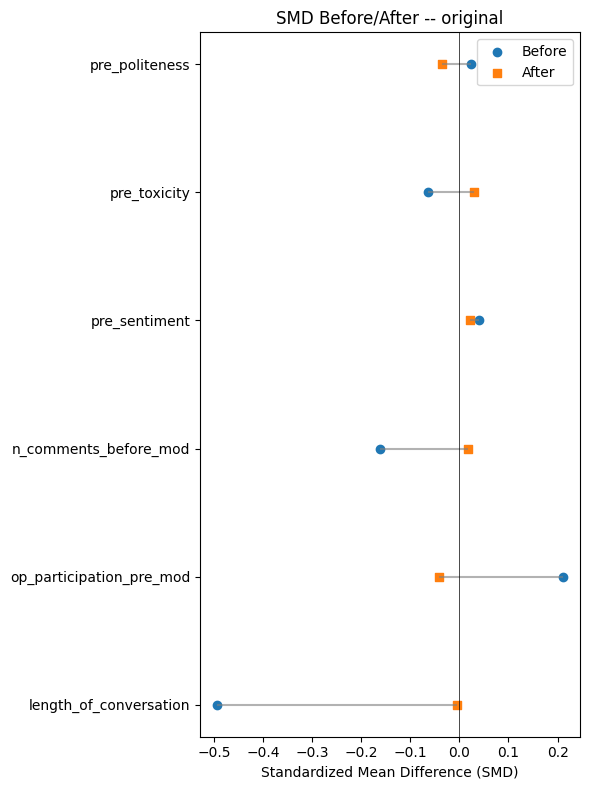

In [44]:
best = 'original'  # choose based on printed SMDs
plot_smd_comparison(results[best]['smd_before'], results[best]['smd_after'],
                    title=f"SMD Before/After -- {best}")

In [45]:
matched_df = results['original']['matched_df']

In [46]:
matched_df.head()

,_orig_idx,link_id,authors,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation,precursor_text,post_text,pre_politeness,pre_toxicity,pre_sentiment,author_diversity,op_participation_pre_mod,op_participation_post_mod,treatment,_match_id,_is_treated
0,0,t3_4aiyjf,"[[deleted], Reichsstatthalter]","[[removed], http://www.sacred-texts.com/grim/b...","[t1_d136qv3, t3_4aiyjf]","[t1_d34l6ei, t1_d4b2au3]","[False, True]",1,2,[removed],,3.146268,0.000234,0.0000,0.500000,1.0,0.0,True,0,1
1,870,t3_4seqwz,"[[deleted], Cypress_Sam, babydolphin]","[[removed], [Waterboy-Paul Robeson](https://ww...","[t3_4seqwz, t3_4seqwz, t3_4seqwz]","[t1_d58q9lp, t1_d58ulor, t1_d58ylpy]","[False, True, True]",1,3,[removed],. They had Capri sun,3.146268,0.000234,0.0000,0.666667,1.0,0.0,False,0,0
2,1,t3_4c467k,"[buoninachos, [deleted]]","[I've been trying to find out too., [removed]]","[t3_4c467k, t1_d5lr0v7]","[t1_d5lr0v7, t1_d72jbvk]","[False, True]",1,2,I've been trying to find out too.,,3.269633,0.000231,0.0000,0.500000,1.0,0.0,True,1,1
3,98,t3_4il686,"[AutoModerator, [deleted], [deleted]]",[\n**If you are found guilty of vote manipulat...,"[t3_4il686, t3_4il686, t3_4il686]","[t1_d2yy5yh, t1_d2yy6f3, t1_d2yy7kk]","[False, True, True]",1,3,\n**If you are found guilty of vote manipulati...,,3.175874,0.001001,0.0093,0.333333,1.0,0.0,False,1,0
4,2,t3_4fvu8v,"[oculus_reparo, [deleted]]",[I hate Beck! One of their drivers stole my br...,"[t3_4fvu8v, t3_4fvu8v]","[t1_d31l398, t1_d4ss0nm]","[False, True]",1,2,I hate Beck! One of their drivers stole my bra...,,2.732918,0.042844,-0.8278,0.500000,1.0,0.0,True,2,1


In [47]:
matched_df[matched_df['_is_treated'] == 1]['post_text']

0                                                        
2                                                        
4                                                        
6                                               . Oh. lol
8       . the show doesnt show the uprising of the fai...
                              ...                        
1766    . So albums that are given a 10 are unanimousl...
1768    . Meeting up will lead to people beating up ot...
1770    . I actually understand this complaint, and it...
1772    . who cares if you didn't even catch the guy. ...
1774    . Yes and communism/socialism is a politically...
Name: post_text, Length: 888, dtype: object

In [48]:
# matched_df['post_text'] = matched_df['post_text'][2:]

matched_df

,_orig_idx,link_id,authors,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation,precursor_text,post_text,pre_politeness,pre_toxicity,pre_sentiment,author_diversity,op_participation_pre_mod,op_participation_post_mod,treatment,_match_id,_is_treated
0,0,t3_4aiyjf,"[[deleted], Reichsstatthalter]","[[removed], http://www.sacred-texts.com/grim/b...","[t1_d136qv3, t3_4aiyjf]","[t1_d34l6ei, t1_d4b2au3]","[False, True]",1,2,[removed],,3.146268,0.000234,0.0000,0.500000,1.000000,0.000000,True,0,1
1,870,t3_4seqwz,"[[deleted], Cypress_Sam, babydolphin]","[[removed], [Waterboy-Paul Robeson](https://ww...","[t3_4seqwz, t3_4seqwz, t3_4seqwz]","[t1_d58q9lp, t1_d58ulor, t1_d58ylpy]","[False, True, True]",1,3,[removed],. They had Capri sun,3.146268,0.000234,0.0000,0.666667,1.000000,0.000000,False,0,0
2,1,t3_4c467k,"[buoninachos, [deleted]]","[I've been trying to find out too., [removed]]","[t3_4c467k, t1_d5lr0v7]","[t1_d5lr0v7, t1_d72jbvk]","[False, True]",1,2,I've been trying to find out too.,,3.269633,0.000231,0.0000,0.500000,1.000000,0.000000,True,1,1
3,98,t3_4il686,"[AutoModerator, [deleted], [deleted]]",[\n**If you are found guilty of vote manipulat...,"[t3_4il686, t3_4il686, t3_4il686]","[t1_d2yy5yh, t1_d2yy6f3, t1_d2yy7kk]","[False, True, True]",1,3,\n**If you are found guilty of vote manipulati...,,3.175874,0.001001,0.0093,0.333333,1.000000,0.000000,False,1,0
4,2,t3_4fvu8v,"[oculus_reparo, [deleted]]",[I hate Beck! One of their drivers stole my br...,"[t3_4fvu8v, t3_4fvu8v]","[t1_d31l398, t1_d4ss0nm]","[False, True]",1,2,I hate Beck! One of their drivers stole my bra...,,2.732918,0.042844,-0.8278,0.500000,1.000000,0.000000,True,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1771,1872,t3_55n6xa,"[punkjazz, Booyacaja, 130i, Ladyblue42, [delet...","[TBH, it looks like a bad attempt at creating ...","[t3_55n6xa, t3_55n6xa, t3_55n6xa, t1_d8c0mvy, ...","[t1_d8c01ua, t1_d8c0gvs, t1_d8c0mvy, t1_d8c118...","[False, False, False, False, True, False, Fals...",4,35,"TBH, it looks like a bad attempt at creating a...",. Maybe if he curls into a fetal position.,3.211412,0.000304,0.0516,0.828571,0.250000,0.000000,False,885,0
1772,3917,t3_5wpplw,"[wedontswiminsoda, CrystalStilts, [deleted], 2...","[Wait, are unborn children considered persons ...","[t3_5wpplw, t1_debz19s, t3_5wpplw, t3_5wpplw, ...","[t1_debz19s, t1_debzh81, t1_debzwas, t1_debzz1...","[False, False, True, False, False, False, Fals...",2,44,"Wait, are unborn children considered persons u...",. who cares if you didn't even catch the guy. ...,3.403301,0.000382,0.1466,0.954545,0.500000,0.166667,True,886,1
1773,603,t3_4owkta,"[Djaul, PM_ME_YOUR_BEST_GIF, [deleted], [delet...","[ayayaye, Looks like a well wrapped...wrap. , ...","[t3_4owkta, t3_4owkta, t3_4owkta, t1_d4g8wbx, ...","[t1_d4g8jxy, t1_d4g8w89, t1_d4g8wbx, t1_d4g9ks...","[False, False, True, False, False, False, Fals...",2,44,ayayaye Looks like a well wrapped...wrap.,,3.258365,0.000251,0.5574,0.795455,0.500000,0.000000,False,886,0
1774,3920,t3_5wpwzt,"[Gourok, UGotSchlonged, politicalopinion, Broh...",[How would you measure violence?\n\nBy body co...,"[t3_5wpwzt, t3_5wpwzt, t3_5wpwzt, t3_5wpwzt, t...","[t1_dec26kb, t1_dec26x0, t1_dec27wm, t1_dec2nf...","[False, False, False, False, False, False, Fal...",7,50,How would you measure violence?\n\nBy body cou...,. Yes and communism/socialism is a politically...,3.351091,0.001067,-0.9970,0.960000,0.142857,0.069767,True,887,1


In [49]:
threads_with_matches = filtered_threads_with_authors_without_nulls.merge(
    matched_df[['_orig_idx', '_match_id', '_is_treated']],
    left_index=True, right_on='_orig_idx', how='left'
)

threads_with_matches.sort_values(by=['_match_id', '_orig_idx'], ascending=True, inplace=True)

In [50]:
def split_thread(row):
    body_list = row['body'] if isinstance(row['body'], list) else []
    body_list = [x for x in body_list if isinstance(x, str) and x.strip()]
    removed_list = row['removed'] if isinstance(row['removed'], list) else []
    n = min(int(row['n_comments_before_mod']), len(body_list))
    precursor = " ".join(body_list[:n])
    if n+1 > len(body_list):
        return pd.Series({'precursor_text': precursor, 'post_text': '', 'num_utterances_post_moderation': 0})
    post_utterances = body_list[n+1:]
    post_removals = removed_list[n+1:]
    print(f"post_removals: {post_removals}, post_utterances: {post_utterances}")
    post_text = ""
    num_utterances_post_moderation = 0
    for index, utterance in enumerate(post_utterances):
        if post_removals[index] == True:
            break
        post_text += utterance + "| "
        num_utterances_post_moderation += 1
    return pd.Series({'precursor_text': precursor, 'post_text': post_text, 'num_utterances_post_moderation': num_utterances_post_moderation})
threads_with_matches[['precursor_text', 'post_text', 'num_utterances_post_moderation']] = threads_with_matches.apply(split_thread, axis=1)

threads_with_matches

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



,link_id,authors,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation,precursor_text,post_text,...,pre_toxicity,pre_sentiment,author_diversity,op_participation_pre_mod,op_participation_post_mod,treatment,_orig_idx,_match_id,_is_treated,num_utterances_post_moderation
0.0,t3_4aiyjf,"[[deleted], Reichsstatthalter]","[[removed], http://www.sacred-texts.com/grim/b...","[t1_d136qv3, t3_4aiyjf]","[t1_d34l6ei, t1_d4b2au3]","[False, True]",1,2,[removed],,...,0.000234,0.0000,0.500000,1.000000,0.000000,True,0,0.0,1.0,0
1.0,t3_4seqwz,"[[deleted], Cypress_Sam, babydolphin]","[[removed], [Waterboy-Paul Robeson](https://ww...","[t3_4seqwz, t3_4seqwz, t3_4seqwz]","[t1_d58q9lp, t1_d58ulor, t1_d58ylpy]","[False, True, True]",1,3,[removed],,...,0.000234,0.0000,0.666667,1.000000,0.000000,False,870,0.0,0.0,0
2.0,t3_4c467k,"[buoninachos, [deleted]]","[I've been trying to find out too., [removed]]","[t3_4c467k, t1_d5lr0v7]","[t1_d5lr0v7, t1_d72jbvk]","[False, True]",1,2,I've been trying to find out too.,,...,0.000231,0.0000,0.500000,1.000000,0.000000,True,1,1.0,1.0,0
3.0,t3_4il686,"[AutoModerator, [deleted], [deleted]]",[\n**If you are found guilty of vote manipulat...,"[t3_4il686, t3_4il686, t3_4il686]","[t1_d2yy5yh, t1_d2yy6f3, t1_d2yy7kk]","[False, True, True]",1,3,\n**If you are found guilty of vote manipulati...,,...,0.001001,0.0093,0.333333,1.000000,0.000000,False,98,1.0,0.0,0
4.0,t3_4fvu8v,"[oculus_reparo, [deleted]]",[I hate Beck! One of their drivers stole my br...,"[t3_4fvu8v, t3_4fvu8v]","[t1_d31l398, t1_d4ss0nm]","[False, True]",1,2,I hate Beck! One of their drivers stole my bra...,,...,0.042844,-0.8278,0.500000,1.000000,0.000000,True,2,2.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,t3_5wlgvq,"[AutoModerator, [deleted], vs845]",[Hi there. I'm a bot. It looks like this submi...,"[t3_5wlgvq, t3_5wlgvq, t3_5wlgvq]","[t1_deb0cnv, t1_deb0csg, t1_debk7wz]","[False, True, False]",1,3,Hi there. I'm a bot. It looks like this submis...,Hi there. I'm a mod in /r/NeutralPolitics.\n\n...,...,0.000226,0.5815,0.666667,1.000000,0.000000,True,3908,NaN,NaN,1
NaN,t3_5wline,"[Johnny-Skitzo, [deleted], alexanderstears, de...",[To pass marijuana as legal and tax the hell o...,"[t3_5wline, t1_deb2mn1, t3_5wline, t3_5wline, ...","[t1_deb2mn1, t1_deb2qls, t1_deb2th9, t1_deb2zs...","[False, True, False, False, False, False, Fals...",1,55,To pass marijuana as legal and tax the hell ou...,Death penalty for everyone who was involved in...,...,0.031525,-0.5994,0.727273,1.000000,0.055556,False,3909,NaN,NaN,8
NaN,t3_5wpaw5,"[oneinfinitecreator, DeletesAccounts0ften, out...",[What does Seaman have to do with this?\n\nDud...,"[t3_5wpaw5, t3_5wpaw5, t1_debu5xs, t1_debus8m,...","[t1_debu5xs, t1_debu8ya, t1_debus8m, t1_debvs0...","[False, False, False, False, False, False, Fal...",30,37,What does Seaman have to do with this?\n\nDude...,&gt;but he clearly believes what he says.\n\nD...,...,0.089828,-0.9857,0.891892,0.066667,0.285714,True,3915,NaN,NaN,6
NaN,t3_5wpw72,"[[deleted], won_tolla, alt_for_saxx, [deleted]...","[[removed], Question. Is it still bullshit, ev...","[t3_5wpw72, t3_5wpw72, t3_5wpw72, t1_dec1gcn, ...","[t1_dec0qau, t1_dec0wyy, t1_dec1gcn, t1_dec1ts...","[False, False, False, False, False, False, Fal...",28,32,"[removed] Question. Is it still bullshit, even...",SHHHHHHHHH!!!!| SHHHHHHHHHHHHHH!| What the fuc...,...,0.065653,0.9880,0.656250,0.357143,0.000000,True,3919,NaN,NaN,3


We want to clean up `post_text` in the treatment row to be at most the length until the next moderation in the control pair.

In [51]:
threads_with_matches[threads_with_matches['_is_treated'] == 0]
threads_with_matches

,link_id,authors,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation,precursor_text,post_text,...,pre_toxicity,pre_sentiment,author_diversity,op_participation_pre_mod,op_participation_post_mod,treatment,_orig_idx,_match_id,_is_treated,num_utterances_post_moderation
0.0,t3_4aiyjf,"[[deleted], Reichsstatthalter]","[[removed], http://www.sacred-texts.com/grim/b...","[t1_d136qv3, t3_4aiyjf]","[t1_d34l6ei, t1_d4b2au3]","[False, True]",1,2,[removed],,...,0.000234,0.0000,0.500000,1.000000,0.000000,True,0,0.0,1.0,0
1.0,t3_4seqwz,"[[deleted], Cypress_Sam, babydolphin]","[[removed], [Waterboy-Paul Robeson](https://ww...","[t3_4seqwz, t3_4seqwz, t3_4seqwz]","[t1_d58q9lp, t1_d58ulor, t1_d58ylpy]","[False, True, True]",1,3,[removed],,...,0.000234,0.0000,0.666667,1.000000,0.000000,False,870,0.0,0.0,0
2.0,t3_4c467k,"[buoninachos, [deleted]]","[I've been trying to find out too., [removed]]","[t3_4c467k, t1_d5lr0v7]","[t1_d5lr0v7, t1_d72jbvk]","[False, True]",1,2,I've been trying to find out too.,,...,0.000231,0.0000,0.500000,1.000000,0.000000,True,1,1.0,1.0,0
3.0,t3_4il686,"[AutoModerator, [deleted], [deleted]]",[\n**If you are found guilty of vote manipulat...,"[t3_4il686, t3_4il686, t3_4il686]","[t1_d2yy5yh, t1_d2yy6f3, t1_d2yy7kk]","[False, True, True]",1,3,\n**If you are found guilty of vote manipulati...,,...,0.001001,0.0093,0.333333,1.000000,0.000000,False,98,1.0,0.0,0
4.0,t3_4fvu8v,"[oculus_reparo, [deleted]]",[I hate Beck! One of their drivers stole my br...,"[t3_4fvu8v, t3_4fvu8v]","[t1_d31l398, t1_d4ss0nm]","[False, True]",1,2,I hate Beck! One of their drivers stole my bra...,,...,0.042844,-0.8278,0.500000,1.000000,0.000000,True,2,2.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,t3_5wlgvq,"[AutoModerator, [deleted], vs845]",[Hi there. I'm a bot. It looks like this submi...,"[t3_5wlgvq, t3_5wlgvq, t3_5wlgvq]","[t1_deb0cnv, t1_deb0csg, t1_debk7wz]","[False, True, False]",1,3,Hi there. I'm a bot. It looks like this submis...,Hi there. I'm a mod in /r/NeutralPolitics.\n\n...,...,0.000226,0.5815,0.666667,1.000000,0.000000,True,3908,NaN,NaN,1
NaN,t3_5wline,"[Johnny-Skitzo, [deleted], alexanderstears, de...",[To pass marijuana as legal and tax the hell o...,"[t3_5wline, t1_deb2mn1, t3_5wline, t3_5wline, ...","[t1_deb2mn1, t1_deb2qls, t1_deb2th9, t1_deb2zs...","[False, True, False, False, False, False, Fals...",1,55,To pass marijuana as legal and tax the hell ou...,Death penalty for everyone who was involved in...,...,0.031525,-0.5994,0.727273,1.000000,0.055556,False,3909,NaN,NaN,8
NaN,t3_5wpaw5,"[oneinfinitecreator, DeletesAccounts0ften, out...",[What does Seaman have to do with this?\n\nDud...,"[t3_5wpaw5, t3_5wpaw5, t1_debu5xs, t1_debus8m,...","[t1_debu5xs, t1_debu8ya, t1_debus8m, t1_debvs0...","[False, False, False, False, False, False, Fal...",30,37,What does Seaman have to do with this?\n\nDude...,&gt;but he clearly believes what he says.\n\nD...,...,0.089828,-0.9857,0.891892,0.066667,0.285714,True,3915,NaN,NaN,6
NaN,t3_5wpw72,"[[deleted], won_tolla, alt_for_saxx, [deleted]...","[[removed], Question. Is it still bullshit, ev...","[t3_5wpw72, t3_5wpw72, t3_5wpw72, t1_dec1gcn, ...","[t1_dec0qau, t1_dec0wyy, t1_dec1gcn, t1_dec1ts...","[False, False, False, False, False, False, Fal...",28,32,"[removed] Question. Is it still bullshit, even...",SHHHHHHHHH!!!!| SHHHHHHHHHHHHHH!| What the fuc...,...,0.065653,0.9880,0.656250,0.357143,0.000000,True,3919,NaN,NaN,3


In [52]:
threads_with_matches.head()

,link_id,authors,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation,precursor_text,post_text,...,pre_toxicity,pre_sentiment,author_diversity,op_participation_pre_mod,op_participation_post_mod,treatment,_orig_idx,_match_id,_is_treated,num_utterances_post_moderation
0.0,t3_4aiyjf,"[[deleted], Reichsstatthalter]","[[removed], http://www.sacred-texts.com/grim/b...","[t1_d136qv3, t3_4aiyjf]","[t1_d34l6ei, t1_d4b2au3]","[False, True]",1,2,[removed],,...,0.000234,0.0000,0.500000,1.0,0.0,True,0,0.0,1.0,0
1.0,t3_4seqwz,"[[deleted], Cypress_Sam, babydolphin]","[[removed], [Waterboy-Paul Robeson](https://ww...","[t3_4seqwz, t3_4seqwz, t3_4seqwz]","[t1_d58q9lp, t1_d58ulor, t1_d58ylpy]","[False, True, True]",1,3,[removed],,...,0.000234,0.0000,0.666667,1.0,0.0,False,870,0.0,0.0,0
2.0,t3_4c467k,"[buoninachos, [deleted]]","[I've been trying to find out too., [removed]]","[t3_4c467k, t1_d5lr0v7]","[t1_d5lr0v7, t1_d72jbvk]","[False, True]",1,2,I've been trying to find out too.,,...,0.000231,0.0000,0.500000,1.0,0.0,True,1,1.0,1.0,0
3.0,t3_4il686,"[AutoModerator, [deleted], [deleted]]",[\n**If you are found guilty of vote manipulat...,"[t3_4il686, t3_4il686, t3_4il686]","[t1_d2yy5yh, t1_d2yy6f3, t1_d2yy7kk]","[False, True, True]",1,3,\n**If you are found guilty of vote manipulati...,,...,0.001001,0.0093,0.333333,1.0,0.0,False,98,1.0,0.0,0
4.0,t3_4fvu8v,"[oculus_reparo, [deleted]]",[I hate Beck! One of their drivers stole my br...,"[t3_4fvu8v, t3_4fvu8v]","[t1_d31l398, t1_d4ss0nm]","[False, True]",1,2,I hate Beck! One of their drivers stole my bra...,,...,0.042844,-0.8278,0.500000,1.0,0.0,True,2,2.0,1.0,0


I want to create a new column that counts the number of utterances post moderation before the next moderation in the control rows, and truncate treatment post_text to only be the length of the nudge window.

In [53]:
# Step 1: Group into match-level summaries
matched_df_summarized = (
    threads_with_matches.groupby('_match_id', as_index=False)
    .agg(
        num_utterances_post_mod_list=('num_utterances_post_moderation', list),
        _is_treated=('_is_treated', list),
        _orig_idx=('_orig_idx', list),
        post_text=('post_text', list)
    )
)

# Step 2: Function to produce truncated text for both control & treatment
def truncate_post_text(row):
    # Unpack lists for this match
    post_texts = row['post_text']
    num_utterances = row['num_utterances_post_mod_list']
    orig_idx = row['_orig_idx']
    is_treated_list = row['_is_treated']

    # Ensure consistent order: treated first
    if is_treated_list[0]:
        treated_idx, control_idx = 0, 1
    else:
        treated_idx, control_idx = 1, 0

    # Extract both texts
    treated_post = post_texts[treated_idx]
    control_post = post_texts[control_idx]

    # Extract the number of utterances in control before second moderation
    target_len = num_utterances[control_idx]

    # Split and truncate the treated text
    treated_utts = [u.strip() for u in treated_post.split('|') if u.strip()]
    truncated_treated_utts = treated_utts[:target_len]
    truncated_treated_post = "| ".join(truncated_treated_utts)

    # Return a small dataframe for both
    return pd.DataFrame([
        {'_orig_idx': orig_idx[treated_idx], 'truncated_post_text': truncated_treated_post},
        {'_orig_idx': orig_idx[control_idx], 'truncated_post_text': control_post}
    ])

# Step 3: Apply and concatenate results
truncated_post_text_df = pd.concat(
    matched_df_summarized.apply(truncate_post_text, axis=1).tolist(),
    ignore_index=True
)
truncated_post_text_df


,_orig_idx,truncated_post_text
0,0,
1,870,
2,1,
3,98,
4,2,
...,...,...
1771,1872,Maybe if he curls into a fetal position. | [r...
1772,3917,who cares if you didn't even catch the guy| Sm...
1773,603,"[removed]| Man, that place is the best. Did yo..."
1774,3920,Yes and communism/socialism is a politically l...


In [57]:
threads_with_matches = threads_with_matches.merge(
    truncated_post_text_df,
    on='_orig_idx',
    how='left'
)

threads_with_matches[threads_with_matches['_is_treated'] == 1]['truncated_post_text']

# threads_with_matches

0                                                        
2                                                        
4                                                        
6       Oh| lol| [removed]| [removed]| Lol| Wow. That'...
8                                                        
                              ...                        
1767    So albums that are given a 10 are unanimously ...
1769    Meeting up will lead to people beating up othe...
1771    I actually understand this complaint, and it's...
1773    who cares if you didn't even catch the guy| Sm...
1775    Yes and communism/socialism is a politically l...
Name: truncated_post_text, Length: 888, dtype: object

In [ ]:
threads_with_matches[threads_with_matches['_is_treated'] == 1][['_orig_idx', 'truncated_post_text']]

Saving the nudges for LLM coding.

In [59]:
threads_with_matches[threads_with_matches['_is_treated'] == 1][['_orig_idx', 'truncated_post_text']].to_csv('nudge_window_pushshift_treated_with_id.csv')


In [ ]:
threads_with_matches[['_orig_idx', 'truncated_post_text']].to_csv('nudge_window_pushshift_both_treated_and_unrecovered_with_id.csv')

Rerun post scores on the truncated post text.

In [61]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from politenessr import Politenessr
from detoxify import Detoxify
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# ========== Setup ==========
nltk.download('vader_lexicon', quiet=True)

politeness_model = Politenessr()
toxicity_model = Detoxify('original')
sentiment_model = SentimentIntensityAnalyzer()

# ========== Helper batch functions ==========

def batchify(series, batch_size=32):
    """Yield successive batches from a pandas Series."""
    for i in range(0, len(series), batch_size):
        yield series.iloc[i:i+batch_size]

def batch_politeness(texts):
    """Return list of politeness scores for a list of texts."""
    try:
        preds = politeness_model.predict(texts)
        # ensure it’s a flat list even for single input
        return np.atleast_1d(preds).tolist()
    except Exception as e:
        print("Politeness batch error:", e)
        return [np.nan] * len(texts)

def batch_toxicity(texts):
    """Return mean toxicity per text."""
    try:
        results = toxicity_model.predict(texts)
        # results = dict of {category: np.array([scores...])}
        toxicity_vals = np.mean(np.vstack(list(results.values())), axis=0)
        return toxicity_vals.tolist()
    except Exception as e:
        print("Detoxify batch error:", e)
        return [np.nan] * len(texts)

def batch_sentiment(texts):
    """Return VADER compound sentiment per text."""
    return [
        sentiment_model.polarity_scores(t)['compound']
        if isinstance(t, str) and t.strip() else np.nan
        for t in texts
    ]

# ========== Apply to dataframe in batches ==========

def apply_in_batches(df, text_col, prefix, batch_size=32):
    politeness_scores = []
    toxicity_scores = []
    sentiment_scores = []

    for batch in tqdm(batchify(df[text_col], batch_size=batch_size), desc=f"Processing {prefix}"):
        texts = batch.fillna("").tolist()
        batch_politeness_scores = batch_politeness(texts)
        batch_toxicity_scores = batch_toxicity(texts)
        batch_sentiment_scores = batch_sentiment(texts)

        politeness_scores.extend(batch_politeness_scores)
        toxicity_scores.extend(batch_toxicity_scores)
        sentiment_scores.extend(batch_sentiment_scores)

    df[f'{prefix}_politeness'] = politeness_scores
    df[f'{prefix}_toxicity'] = toxicity_scores
    df[f'{prefix}_sentiment'] = sentiment_scores

# ========== Run truncated post text ==========
apply_in_batches(threads_with_matches, 'truncated_post_text', 'post', batch_size=64)

# ========== Check output ==========
threads_with_matches[['post_toxicity',
          'pre_sentiment','post_sentiment']].head()

,post_text,num_utterances_post_moderation,truncated_post_text,post_sentiment,post_sentiment
0,,0,,NaN,NaN
1,,0,,NaN,NaN
2,,0,,NaN,NaN
3,,0,,NaN,NaN
4,,0,,NaN,NaN
...,...,...,...,...,...
3845,Hi there. I'm a mod in /r/NeutralPolitics.\n\n...,1,NaN,NaN,NaN
3846,Death penalty for everyone who was involved in...,8,NaN,NaN,NaN
3847,&gt;but he clearly believes what he says.\n\nD...,6,NaN,NaN,NaN
3848,SHHHHHHHHH!!!!| SHHHHHHHHHHHHHH!| What the fuc...,3,NaN,NaN,NaN


In [62]:
threads_with_matches[['post_text', 'num_utterances_post_moderation', 'truncated_post_text', 'post_sentiment', 'post_sentiment']]

In [ ]:
# truncate_post_text(threads_with_matches.iloc[1279])

## Analyzing pre/post scores

There are observations we can draw from these scores that could be insightful. Notably, we are interested in:
- the percentage of recovered conversations that see an improvement in those scores after moderation
- the percentage of unrecovered conversations that see a decline in those scores after the first moderation

In [ ]:
change_in_toxicity = threads_with_matches[threads_with_matches['_is_treated'] == 0]['post_toxicity']-threads_with_matches[threads_with_matches['_is_treated'] == 0]['pre_toxicity']
encoded_change_in_toxicity = change_in_toxicity.dropna().apply(lambda x: 0 if x <= 0 else 1)
np.unique_counts(encoded_change_in_toxicity)

# Regression framework

The goal is to understand which features in the data are most likely to contribute to a conversation recovering.

In [ ]:
threads_with_matches_without_nulls = threads_with_matches.dropna(subset=['post_politeness', 'post_toxicity', 'post_sentiment'])
threads_with_matches_without_nulls

What should the model look like? We have linguistic features such as:
- pre/post toxicity
- pre/post sentiment intensity
- pre/post politeness

We have conversational features such as:
- number of comments before moderation
- length of conversation
- op participation pre and post mod
- author diversity in conversation

We have an outcome variable:
- _is_treated (same as `treatment`)

Using a logistic regression model (since we have a binary outcome variable) we could represent and fit the following model:
$$logit(Conversation Recovers) = \beta_0 + \beta_1(post\_toxicity-pre\_toxicity) + \beta_2(post\_politeness - pre\_politeness) +$$

$$\beta_3(post\_sentiment - pre\_sentiment) + \beta_4(n\_comments\_before\_mod) + \beta_5(length\_of\_conversation) + \beta_6(op\_participation\_pre\_mod) + \beta_7(op\_participation\_post\_mod) + \beta_8(author\_diversity)$$

In [66]:
threads_with_matches_without_nulls['toxicity_difference'] = threads_with_matches_without_nulls['post_toxicity'] - threads_with_matches_without_nulls['pre_toxicity']
threads_with_matches_without_nulls['politeness_difference'] = threads_with_matches_without_nulls['post_politeness'] - threads_with_matches_without_nulls['pre_politeness']
threads_with_matches_without_nulls['sentiment_difference'] = threads_with_matches_without_nulls['post_sentiment'] - threads_with_matches_without_nulls['pre_sentiment']

,link_id,authors,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation,precursor_text,post_text,...,_match_id,_is_treated,num_utterances_post_moderation,truncated_post_text,post_politeness,post_toxicity,post_sentiment,toxicity_difference,politeness_difference,sentiment_difference
6,t3_4gfuqt,"[Coteup, [deleted], Yji, Rynocorn, [deleted], ...","[lol, [removed], Oh, lol, [removed], [removed]...","[t1_d2h6jie, t3_4gfuqt, t1_d2i2eeg, t1_d2hb1a2...","[t1_d78a6ty, t1_d78a6uo, t1_d78afcy, t1_d78afw...","[False, True, False, False, False, False, Fals...",1,61,lol,Oh| lol| [removed]| [removed]| Lol| Wow. That'...,...,3.0,1.0,59,Oh| lol| [removed]| [removed]| Lol| Wow. That'...,2.911784,0.111176,-0.0644,0.109332,-0.172083,-0.4859
7,t3_5gsi56,"[Mir_man, For-the_horde, SuponjiBobu, Mir_man,...",[Are these really JFS guys? That's big if true...,"[t3_5gsi56, t3_5gsi56, t1_daupcqv, t1_daupfrl,...","[t1_daupcqv, t1_daupedb, t1_daupfrl, t1_dauphl...","[False, True, False, False, False, False, Fals...",1,62,Are these really JFS guys? That's big if true ...,There are probably soldiers that are in for th...,...,3.0,0.0,12,There are probably soldiers that are in for th...,3.363032,0.002130,-0.9935,0.001696,0.207934,-1.4150
10,t3_4h8mhu,"[j3rry, DiddyKing, [deleted], -JAC, [deleted],...","[Watch that dude have cerebral palsy., Yeah I ...","[t3_4h8mhu, t1_d2ob3ha, t1_d2ob6l0, t3_4h8mhu,...","[t1_d2ob3ha, t1_d2ob6l0, t1_d2ob6wz, t1_d2oc36...","[False, False, False, False, False, False, Fal...",33,151,Watch that dude have cerebral palsy. Yeah I wa...,Still my favorite mixtape from Game\n\nHe went...,...,5.0,1.0,117,Still my favorite mixtape from Game\n\nHe went...,3.371788,0.107515,-0.9859,-0.209441,0.935629,-1.9026
11,t3_536xnj,"[Sojoez, HOT_WINGS_AT_KFC, Akoot, sorreh, [del...",[The pools also seem to respawn a lot slower t...,"[t3_536xnj, t3_536xnj, t3_536xnj, t3_536xnj, t...","[t1_d7qgyuo, t1_d7qh6tu, t1_d7qhc06, t1_d7qi3x...","[False, False, False, False, False, False, Fal...",34,149,The pools also seem to respawn a lot slower th...,I had to install server hop and it still took ...,...,5.0,0.0,34,I had to install server hop and it still took ...,3.274197,0.013932,0.9948,0.007818,0.185676,0.0309
16,t3_4hc9r3,"[kuslepirate, [deleted], twixerfan, toloseyour...","[Hi, here's the link to the original DVDs:\n\n...","[t3_4hc9r3, t3_4hc9r3, t3_4hc9r3, t3_4hc9r3, t...","[t1_d2padq3, t1_d2pasza, t1_d2pcbdf, t1_d2pf6k...","[False, True, False, False, False, False, Fals...",1,8,"Hi, here's the link to the original DVDs:\n\n[...",http://www.staples.ca/en/Rosetta-Stone-French-...,...,8.0,1.0,6,http://www.staples.ca/en/Rosetta-Stone-French-...,3.087158,0.000279,0.8105,0.000060,-0.875727,1.5987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1771,t3_5wj4px,"[Hustlerbojenkins, Liefglinde, HornyNeedles, [...",[wait til tomorrow and they'll all be back in ...,"[t3_5wj4px, t3_5wj4px, t3_5wj4px, t3_5wj4px, t...","[t1_deagc5f, t1_deagclc, t1_deagcr5, t1_deagem...","[False, False, False, True, False, False, Fals...",3,35,wait til tomorrow and they'll all be back in c...,"I actually understand this complaint, and it's...",...,885.0,1.0,31,"I actually understand this complaint, and it's...",3.435793,0.000459,0.9989,-0.004131,0.248363,0.9989
1772,t3_4owkta,"[Djaul, PM_ME_YOUR_BEST_GIF, [deleted], [delet...","[ayayaye, Looks like a well wrapped...wrap. , ...","[t3_4owkta, t3_4owkta, t3_4owkta, t1_d4g8wbx, ...","[t1_d4g8jxy, t1_d4g8w89, t1_d4g8wbx, t1_d4g9ks...","[False, False, True, False, False, False, Fals...",2,44,ayayaye Looks like a well wrapped...wrap.,"[removed]| Man, that place is the best. Did yo...",...,886.0,0.0,22,"[removed]| Man, that place is the best. Did yo...",3.404183,0.088663,0.9830,0.088411,0.145818,0.4256
1773,t3_5wpplw,"[wedontswiminsoda, CrystalStilts, [deleted], 2...","[Wait, are unborn children considered persons ...","[t3_5wpplw, t1_debz19s, t3_5wpplw, t3_5wpplw, ...","[t1_debz19s, t1_debz

In [3]:
threads_with_matches_without_nulls

In [68]:
import statsmodels.api as sm
from statsmodels.discrete.conditional_models import ConditionalLogit

/Users/himnish.hunma/Repos/CS 598/nudge-convo-back/nudge-convo-back-env/lib/python3.9/site-packages/statsmodels/discrete/conditional_models.py:205: UserWarning: Conditional models should not include an intercept
  warnings.warn("Conditional models should not include an intercept")
/Users/himnish.hunma/Repos/CS 598/nudge-convo-back/nudge-convo-back-env/lib/python3.9/site-packages/statsmodels/discrete/conditional_models.py:80: UserWarning: Dropped 6 groups and 6 observations for having no within-group variance
  warnings.warn(msg)


                  Conditional Logit Model Regression Results                  
Dep. Variable:            _is_treated   No. Observations:                 1164
Model:               ConditionalLogit   No. groups:                        582
Log-Likelihood:               -341.91   Min group size:                      2
Method:                          BFGS   Max group size:                      2
Date:                Fri, 07 Nov 2025   Mean group size:                   2.0
Time:                        01:20:33                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
toxicity_difference          -0.4585      0.554     -0.828      0.408      -1.543       0.626
politeness_difference         0.0056      0.133      0.042      0.967      -0.256       0.267
sentiment_difference         -0.1276      0.083     -1.536      0.125  

In [ ]:
features = ['toxicity_difference', 'politeness_difference', 'sentiment_difference', 'n_comments_before_mod', 'length_of_conversation', 'op_participation_pre_mod', 'op_participation_post_mod', 'author_diversity']
# model = smf.logit("_is_treated ~ toxicity_difference + politeness_difference + sentiment_difference + n_comments_before_mod + length_of_conversation + op_participation_pre_mod + op_participation_post_mod + author_diversity + C(_match_id)", data=threads_with_matches_without_nulls)
# result = model.fit()
# print(result.summary())

model = ConditionalLogit.from_formula(
    "_is_treated ~ toxicity_difference + politeness_difference + sentiment_difference + n_comments_before_mod + length_of_conversation + op_participation_pre_mod + op_participation_post_mod + author_diversity -1",
    groups="_match_id",
    data=threads_with_matches_without_nulls
)
result = model.fit()
print(result.summary())

We want to try a different model

$$logit(Conversation Recovers) = \beta_0 + \beta_1(post\_toxicity) + \beta_2(pre\_toxicity) + \beta_3(post\_politeness) + \beta_4(pre\_politeness) +$$

$$\beta_5(post\_sentiment) + \beta_6(pre\_sentiment) + \beta_7(n\_comments\_before\_mod) + \beta_8(length\_of\_conversation) + \beta_9(op\_participation\_pre\_mod) + \beta_{10}(op\_participation\_post\_mod) + \beta_{11}(author\_diversity)$$

In [70]:
features = ['pre_toxicity', 'post_toxicity', 'pre_politeness', 'post_politeness', 'pre_sentiment', 'post_sentiment', 'n_comments_before_mod', 'length_of_conversation', 'op_participation_pre_mod', 'op_participation_post_mod', 'author_diversity']
#
# X = threads_with_matches_without_nulls[features]
# X = sm.add_constant(X)
# y = threads_with_matches_without_nulls['treatment']
#
# logit_model = sm.Logit(y, X).fit()
# print(logit_model.summary())
model = ConditionalLogit.from_formula(
    "_is_treated ~ pre_toxicity + post_toxicity + pre_politeness + post_politeness + pre_sentiment + post_sentiment + n_comments_before_mod + length_of_conversation + op_participation_pre_mod + op_participation_post_mod + author_diversity -1",
    groups="_match_id",
    data=threads_with_matches_without_nulls
)
result = model.fit()
print(result.summary())


         Current function value: 0.584461
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:            _is_treated   No. Observations:                 1170
Model:                          Logit   Df Residuals:                      574
Method:                           MLE   Df Model:                          595
Date:                Fri, 07 Nov 2025   Pseudo R-squ.:                  0.1568
Time:                        01:20:34   Log-Likelihood:                -683.82
converged:                      False   LL-Null:                       -810.97
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -9.2959      2.750     -3.380      0.001     -14.686      -3.905
C(_match_id)[T.5.0] 

/Users/himnish.hunma/Repos/CS 598/nudge-convo-back/nudge-convo-back-env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
import statsmodels.formula.api as smf

model = smf.logit("_is_treated ~ toxicity_difference + politeness_difference + sentiment_difference + n_comments_before_mod + length_of_conversation + op_participation_pre_mod + op_participation_post_mod + author_diversity + C(_match_id)", data=threads_with_matches_without_nulls)
result = model.fit()
print(result.summary())

### Effect within subreddits



In [6]:
threads_with_matches_without_nulls = pd.read_csv('pushshift_reddit_matches_with_covariates_without_nulls.csv')

,Unnamed: 0,link_id,authors,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation,precursor_text,...,_match_id,_is_treated,num_utterances_post_moderation,truncated_post_text,post_politeness,post_toxicity,post_sentiment,toxicity_difference,politeness_difference,sentiment_difference
0,6,t3_4gfuqt,"['Coteup', '[deleted]', 'Yji', 'Rynocorn', '[d...","['lol', '[removed]', 'Oh', 'lol', '[removed]',...","['t1_d2h6jie', 't3_4gfuqt', 't1_d2i2eeg', 't1_...","['t1_d78a6ty', 't1_d78a6uo', 't1_d78afcy', 't1...","[False, True, False, False, False, False, Fals...",1,61,lol,...,3.0,1.0,59,Oh| lol| [removed]| [removed]| Lol| Wow. That'...,2.911784,0.111176,-0.0644,0.109332,-0.172083,-0.4859
1,7,t3_5gsi56,"['Mir_man', 'For-the_horde', 'SuponjiBobu', 'M...","[""Are these really JFS guys? That's big if tru...","['t3_5gsi56', 't3_5gsi56', 't1_daupcqv', 't1_d...","['t1_daupcqv', 't1_daupedb', 't1_daupfrl', 't1...","[False, True, False, False, False, False, Fals...",1,62,Are these really JFS guys? That's big if true ...,...,3.0,0.0,12,There are probably soldiers that are in for th...,3.363032,0.002130,-0.9935,0.001696,0.207934,-1.4150
2,10,t3_4h8mhu,"['j3rry', 'DiddyKing', '[deleted]', '-JAC', '[...","['Watch that dude have cerebral palsy.', 'Yeah...","['t3_4h8mhu', 't1_d2ob3ha', 't1_d2ob6l0', 't3_...","['t1_d2ob3ha', 't1_d2ob6l0', 't1_d2ob6wz', 't1...","[False, False, False, False, False, False, Fal...",33,151,Watch that dude have cerebral palsy. Yeah I wa...,...,5.0,1.0,117,Still my favorite mixtape from Game\n\nHe went...,3.371788,0.107515,-0.9859,-0.209441,0.935629,-1.9026
3,11,t3_536xnj,"['Sojoez', 'HOT_WINGS_AT_KFC', 'Akoot', 'sorre...",['The pools also seem to respawn a lot slower ...,"['t3_536xnj', 't3_536xnj', 't3_536xnj', 't3_53...","['t1_d7qgyuo', 't1_d7qh6tu', 't1_d7qhc06', 't1...","[False, False, False, False, False, False, Fal...",34,149,The pools also seem to respawn a lot slower th...,...,5.0,0.0,34,I had to install server hop and it still took ...,3.274197,0.013932,0.9948,0.007818,0.185676,0.0309
4,16,t3_4hc9r3,"['kuslepirate', '[deleted]', 'twixerfan', 'tol...","[""Hi, here's the link to the original DVDs:\n\...","['t3_4hc9r3', 't3_4hc9r3', 't3_4hc9r3', 't3_4h...","['t1_d2padq3', 't1_d2pasza', 't1_d2pcbdf', 't1...","[False, True, False, False, False, False, Fals...",1,8,"Hi, here's the link to the original DVDs:\n\n[...",...,8.0,1.0,6,http://www.staples.ca/en/Rosetta-Stone-French-...,3.087158,0.000279,0.8105,0.000060,-0.875727,1.5987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,1771,t3_5wj4px,"['Hustlerbojenkins', 'Liefglinde', 'HornyNeedl...","[""wait til tomorrow and they'll all be back in...","['t3_5wj4px', 't3_5wj4px', 't3_5wj4px', 't3_5w...","['t1_deagc5f', 't1_deagclc', 't1_deagcr5', 't1...","[False, False, False, True, False, False, Fals...",3,35,wait til tomorrow and they'll all be back in c...,...,885.0,1.0,31,"I actually understand this complaint, and it's...",3.435793,0.000459,0.9989,-0.004131,0.248363,0.9989
1166,1772,t3_4owkta,"['Djaul', 'PM_ME_YOUR_BEST_GIF', '[deleted]', ...","['ayayaye', 'Looks like a well wrapped...wrap....","['t3_4owkta', 't3_4owkta', 't3_4owkta', 't1_d4...","['t1_d4g8jxy', 't1_d4g8w89', 't1_d4g8wbx', 't1...","[False, False, True, False, False, False, Fals...",2,44,ayayaye Looks like a well wrapped...wrap.,...,886.0,0.0,22,"[removed]| Man, that place is the best. Did yo...",3.404183,0.088663,0.9830,0.088411,0.145818,0.4256
1167,1773,t3_5wpplw,"['wedontswiminsoda', 'CrystalStilts', '[delete...","['Wait, are unborn children considered persons...","['t3_5wpplw', 't1_debz19s', 't3_5wpplw', 't3_5...","['t1_debz19s', 't1_debzh81', 't1_debzwas', 't1...","[False, False, True, False, False, False, Fals...",2,44,"Wait, are unborn children considered persons u...",...,886.0,1.0,41,who cares if you didn't even catch the guy| Sm...,3.082042,0.013159,-0.9999,0.012777,-0.321259,-1.1465
1168,1774,t3_4spgct,"['SRScreenshot', 'LIATG', 'LynxEsper', '

In [ ]:
threads_with_matches_without_nulls# threads_with_matches_without_nulls.to_csv('pushshift_reddit_matches_with_covariates_without_nulls.csv')

### Do matching with subreddit

Are subreddit level effects more significant. First do the matching based on the same covariates, and also the subreddit, then perform the following logistic regression.

$$logit(Conversation Recovers) = \beta_0 + \beta_1(post\_toxicity-pre\_toxicity) + \beta_2(post\_politeness - pre\_politeness) +$$

$$\beta_3(post\_sentiment - pre\_sentiment) + \beta_4(n\_comments\_before\_mod) + \beta_5(length\_of\_conversation) + \beta_6(op\_participation\_pre\_mod) + \beta_7(op\_participation\_post\_mod) + \beta_8(author\_diversity)$$

In [122]:
subreddit_matching_df = threads_with_matches_without_nulls[['link_id', 'authors', 'body', 'parent_id', 'name', 'removed', 'n_comments_before_mod', 'length_of_conversation', 'precursor_text', 'truncated_post_text', 'pre_politeness', 'pre_toxicity', 'pre_sentiment', 'author_diversity', 'op_participation_pre_mod', 'op_participation_post_mod', 'treatment', 'post_politeness', 'post_toxicity', 'post_sentiment', 'num_utterances_post_moderation']]

In [123]:
subreddit_df = moderated_df.groupby(['link_id'])['subreddit'].agg(pd.Series.mode)

In [124]:
subreddit_df

link_id
t1_d31s2kg             0.0
t1_d320i5n             0.0
t1_d3ww4xm             0.0
t1_d4oh8sc             0.0
t1_d4sfygd             0.0
                  ...     
t3_5wqdcz             tifu
t3_5wqwqs           bestof
t3_5wr5po     TheSilphRoad
t3_5wr5ww       askscience
t3_5wrgua     changemyview
Name: subreddit, Length: 10709, dtype: object

In [125]:
# filtered_threads_with_authors_without_nulls.merge(
#     matched_df[['_orig_idx', '_match_id', '_is_treated']],
#     left_index=True, right_on='_orig_idx', how='left'
# )
# moderated_df['positional_id'] = moderated_df.iloc[:, 0]
#
# subreddit_matching_df.merge(moderated_df[['link_id', 'subreddit']], on='link_id', how='left')
new_match_df = pd.merge(subreddit_matching_df, subreddit_df, on='link_id', how='inner')
new_match_df

,link_id,authors,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation,precursor_text,truncated_post_text,...,pre_sentiment,author_diversity,op_participation_pre_mod,op_participation_post_mod,treatment,post_politeness,post_toxicity,post_sentiment,num_utterances_post_moderation,subreddit
0,t3_4gfuqt,"['Coteup', '[deleted]', 'Yji', 'Rynocorn', '[d...","['lol', '[removed]', 'Oh', 'lol', '[removed]',...","['t1_d2h6jie', 't3_4gfuqt', 't1_d2i2eeg', 't1_...","['t1_d78a6ty', 't1_d78a6uo', 't1_d78afcy', 't1...","[False, True, False, False, False, False, Fals...",1,61,lol,Oh| lol| [removed]| [removed]| Lol| Wow. That'...,...,0.4215,0.950820,1.000000,0.000000,True,2.911784,0.111176,-0.0644,59,nfl
1,t3_5gsi56,"['Mir_man', 'For-the_horde', 'SuponjiBobu', 'M...","[""Are these really JFS guys? That's big if tru...","['t3_5gsi56', 't3_5gsi56', 't1_daupcqv', 't1_d...","['t1_daupcqv', 't1_daupedb', 't1_daupfrl', 't1...","[False, True, False, False, False, False, Fals...",1,62,Are these really JFS guys? That's big if true ...,There are probably soldiers that are in for th...,...,0.4215,0.967742,1.000000,0.032787,False,3.363032,0.002130,-0.9935,12,syriancivilwar
2,t3_4h8mhu,"['j3rry', 'DiddyKing', '[deleted]', '-JAC', '[...","['Watch that dude have cerebral palsy.', 'Yeah...","['t3_4h8mhu', 't1_d2ob3ha', 't1_d2ob6l0', 't3_...","['t1_d2ob3ha', 't1_d2ob6l0', 't1_d2ob6wz', 't1...","[False, False, False, False, False, False, Fal...",33,151,Watch that dude have cerebral palsy. Yeah I wa...,Still my favorite mixtape from Game\n\nHe went...,...,0.9167,0.907285,0.030303,0.000000,True,3.371788,0.107515,-0.9859,117,hiphopheads
3,t3_536xnj,"['Sojoez', 'HOT_WINGS_AT_KFC', 'Akoot', 'sorre...",['The pools also seem to respawn a lot slower ...,"['t3_536xnj', 't3_536xnj', 't3_536xnj', 't3_53...","['t1_d7qgyuo', 't1_d7qh6tu', 't1_d7qhc06', 't1...","[False, False, False, False, False, False, Fal...",34,149,The pools also seem to respawn a lot slower th...,I had to install server hop and it still took ...,...,0.9639,0.966443,0.029412,0.008696,False,3.274197,0.013932,0.9948,34,wow
4,t3_4hc9r3,"['kuslepirate', '[deleted]', 'twixerfan', 'tol...","[""Hi, here's the link to the original DVDs:\n\...","['t3_4hc9r3', 't3_4hc9r3', 't3_4hc9r3', 't3_4h...","['t1_d2padq3', 't1_d2pasza', 't1_d2pcbdf', 't1...","[False, True, False, False, False, False, Fals...",1,8,"Hi, here's the link to the original DVDs:\n\n[...",http://www.staples.ca/en/Rosetta-Stone-French-...,...,-0.7882,0.875000,1.000000,0.000000,True,3.087158,0.000279,0.8105,6,history
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,t3_5wj4px,"['Hustlerbojenkins', 'Liefglinde', 'HornyNeedl...","[""wait til tomorrow and they'll all be back in...","['t3_5wj4px', 't3_5wj4px', 't3_5wj4px', 't3_5w...","['t1_deagc5f', 't1_deagclc', 't1_deagcr5', 't1...","[False, False, False, True, False, False, Fals...",3,35,wait til tomorrow and they'll all be back in c...,"I actually understand this complaint, and it's...",...,0.0000,0.971429,0.333333,0.093750,True,3.435793,0.000459,0.9989,31,Overwatch
1166,t3_4owkta,"['Djaul', 'PM_ME_YOUR_BEST_GIF', '[deleted]', ...","['ayayaye', 'Looks like a well wrapped...wrap....","['t3_4owkta', 't3_4owkta', 't3_4owkta', 't1_d4...","['t1_d4g8jxy', 't1_d4g8w89', 't1_d4g8wbx', 't1...","[False, False, True, False, False, False, Fals...",2,44,ayayaye Looks like a well wrapped...wrap.,"[removed]| Man, that place is the best. Did yo...",...,0.5574,0.795455,0.500000,0.000000,False,3.404183,0.088663,0.9830,22,food
1167,t3_5wpplw,"['wedontswiminsoda', 'CrystalStilts', '[delete...","['Wait, are unborn children considered persons...","['t3_5wpplw', 't1_debz19s', 't3_5wpplw', 't3_5...","['t1_debz19s', 't1_debzh81', 't1_debzwas', 't1...","[False, False, True, False, False, False, Fals...",2,44,"Wait, are unborn children considered persons u...",who cares if you didn't even catch the guy| Sm...,...,0.1466,0.954545,0.500000,0.166667,True,3.082042,0.013159

In [96]:
# new_match_df = pd.get_dummies(new_match_df, columns=['subreddit'], drop_first=False)
# new_match_df

,link_id,authors,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation,precursor_text,truncated_post_text,...,subreddit_spacex,subreddit_syriancivilwar,subreddit_technology,subreddit_television,subreddit_tifu,subreddit_toronto,subreddit_videos,subreddit_whatisthisthing,subreddit_worldnews,subreddit_wow
0,t3_4gfuqt,"['Coteup', '[deleted]', 'Yji', 'Rynocorn', '[d...","['lol', '[removed]', 'Oh', 'lol', '[removed]',...","['t1_d2h6jie', 't3_4gfuqt', 't1_d2i2eeg', 't1_...","['t1_d78a6ty', 't1_d78a6uo', 't1_d78afcy', 't1...","[False, True, False, False, False, False, Fals...",1,61,lol,Oh| lol| [removed]| [removed]| Lol| Wow. That'...,...,False,False,False,False,False,False,False,False,False,False
1,t3_5gsi56,"['Mir_man', 'For-the_horde', 'SuponjiBobu', 'M...","[""Are these really JFS guys? That's big if tru...","['t3_5gsi56', 't3_5gsi56', 't1_daupcqv', 't1_d...","['t1_daupcqv', 't1_daupedb', 't1_daupfrl', 't1...","[False, True, False, False, False, False, Fals...",1,62,Are these really JFS guys? That's big if true ...,There are probably soldiers that are in for th...,...,False,True,False,False,False,False,False,False,False,False
2,t3_4h8mhu,"['j3rry', 'DiddyKing', '[deleted]', '-JAC', '[...","['Watch that dude have cerebral palsy.', 'Yeah...","['t3_4h8mhu', 't1_d2ob3ha', 't1_d2ob6l0', 't3_...","['t1_d2ob3ha', 't1_d2ob6l0', 't1_d2ob6wz', 't1...","[False, False, False, False, False, False, Fal...",33,151,Watch that dude have cerebral palsy. Yeah I wa...,Still my favorite mixtape from Game\n\nHe went...,...,False,False,False,False,False,False,False,False,False,False
3,t3_536xnj,"['Sojoez', 'HOT_WINGS_AT_KFC', 'Akoot', 'sorre...",['The pools also seem to respawn a lot slower ...,"['t3_536xnj', 't3_536xnj', 't3_536xnj', 't3_53...","['t1_d7qgyuo', 't1_d7qh6tu', 't1_d7qhc06', 't1...","[False, False, False, False, False, False, Fal...",34,149,The pools also seem to respawn a lot slower th...,I had to install server hop and it still took ...,...,False,False,False,False,False,False,False,False,False,True
4,t3_4hc9r3,"['kuslepirate', '[deleted]', 'twixerfan', 'tol...","[""Hi, here's the link to the original DVDs:\n\...","['t3_4hc9r3', 't3_4hc9r3', 't3_4hc9r3', 't3_4h...","['t1_d2padq3', 't1_d2pasza', 't1_d2pcbdf', 't1...","[False, True, False, False, False, False, Fals...",1,8,"Hi, here's the link to the original DVDs:\n\n[...",http://www.staples.ca/en/Rosetta-Stone-French-...,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,t3_5wj4px,"['Hustlerbojenkins', 'Liefglinde', 'HornyNeedl...","[""wait til tomorrow and they'll all be back in...","['t3_5wj4px', 't3_5wj4px', 't3_5wj4px', 't3_5w...","['t1_deagc5f', 't1_deagclc', 't1_deagcr5', 't1...","[False, False, False, True, False, False, Fals...",3,35,wait til tomorrow and they'll all be back in c...,"I actually understand this complaint, and it's...",...,False,False,False,False,False,False,False,False,False,False
1166,t3_4owkta,"['Djaul', 'PM_ME_YOUR_BEST_GIF', '[deleted]', ...","['ayayaye', 'Looks like a well wrapped...wrap....","['t3_4owkta', 't3_4owkta', 't3_4owkta', 't1_d4...","['t1_d4g8jxy', 't1_d4g8w89', 't1_d4g8wbx', 't1...","[False, False, True, False, False, False, Fals...",2,44,ayayaye Looks like a well wrapped...wrap.,"[removed]| Man, that place is the best. Did yo...",...,False,False,False,False,False,False,False,False,False,False
1167,t3_5wpplw,"['wedontswiminsoda', 'CrystalStilts', '[delete...","['Wait, are unborn children considered persons...","['t3_5wpplw', 't1_debz19s', 't3_5wpplw', 't3_5...","['t1_debz19s', 't1_debzh81', 't1_debzwas', 't1...","[False, False, True, False, False, False, Fals...",2,44,"Wait, are unborn children considered persons u...",who cares if you didn't even catch the guy| Sm...,...,False,False,False,False,False,True,False,False,False,False
1168,t3_4spgct,"['SRScreenshot', 'LIATG', 'LynxEsper', 'Vorpal...",['**A girl getting screamed at

In [318]:
def nn_match(df, covariates, treat_col='treatment',
             replace=False, n_neighbors=1, caliper=None, random_state=0):
    """
    Nearest-neighbor matching on covariates.
    - df: DataFrame with covariates + treatment column
    - covariates: list of column names to match on (should be numeric)
    - replace: if False, control units are taken without replacement
    - n_neighbors: neighbors per treated (usually 1)
    - caliper: optional numeric caliper on propensity score (requires propensity_score in df)
    Returns: matched_df with columns: _match_id, _is_treated, original_index
    """
    df = df.reset_index(drop=False).rename(columns={'index': '_orig_idx'})  # preserve original idx
    treated = df[df[treat_col] == 1].copy().reset_index(drop=True)
    control = df[df[treat_col] == 0].copy().reset_index(drop=True)

    # ensure numeric arrays
    X_control = control[covariates].astype(float).fillna(0).values
    X_treat = treated[covariates].astype(float).fillna(0).values

    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(X_control)
    dists, idxs = nbrs.kneighbors(X_treat)  # shape: (n_treated, n_neighbors)

    matched_control_indices = []
    matched_treated_indices = []
    matched_distances = []

    used_control = set()
    for i_t, (dist_row, idx_row) in enumerate(zip(dists, idxs)):
        for k, (d, idx_c) in enumerate(zip(dist_row, idx_row)):
            # if caliper on propensity score is requested, check it
            if caliper is not None:
                if 'propensity_score' not in treated.columns or 'propensity_score' not in control.columns:
                    raise ValueError("Caliper requested but 'propensity_score' column not found in df.")
                ps_t = treated.loc[i_t, 'propensity_score']
                ps_c = control.loc[idx_c, 'propensity_score']
                if abs(ps_t - ps_c) > caliper:
                    continue

            if not replace:
                if idx_c in used_control:
                    # if control already used and no replacement allowed, skip this control
                    continue
                used_control.add(idx_c)

            matched_control_indices.append(control.loc[idx_c, '_orig_idx'])
            matched_treated_indices.append(treated.loc[i_t, '_orig_idx'])
            matched_distances.append(d)
            # if not replacing and we only want 1 neighbor, break early
            if not replace:
                break

    # Build matched DataFrame
    matched = pd.DataFrame({
        '_treated_idx': matched_treated_indices,
        '_control_idx': matched_control_indices,
        '_distance': matched_distances
    })

    # Create matched sample: rows with original indices
    # treated_matched = df[df['_orig_idx'].isin(matched['_treated_idx'])].copy()
    # control_matched = df[df['_orig_idx'].isin(matched['_control_idx'])].copy()

    # mark pair ids
    # For pairing, map each treated occurrence to the control chosen; if multiple matches per treated exist, they appear multiple rows
    pair_ids = []
    for pair_id, (_, r) in enumerate(matched.iterrows()):
        pair_ids.append((r['_treated_idx'], r['_control_idx'], pair_id))

    matched_rows = []
    for treated_idx, control_idx, pid in pair_ids:
        tr = df[df['_orig_idx'] == treated_idx].copy()
        co = df[df['_orig_idx'] == control_idx].copy()
        tr['_match_id'] = pid
        co['_match_id'] = pid
        tr['_is_treated'] = 1
        co['_is_treated'] = 0
        matched_rows.append(tr)
        matched_rows.append(co)

    if len(matched_rows) == 0:
        return pd.DataFrame()  # no matches
    matched_df = pd.concat(matched_rows, axis=0).reset_index(drop=True)
    return matched_df


def try_transformations_and_match(df, covariates, treat_col='treatment', transforms=None,
                                  match_fn=nn_match, match_kwargs=None):
    """
    transforms: dict of name -> function that takes DataFrame and covariate list, returns transformed DataFrame (or tuple(df_trans, covariates_trans))
    match_fn: function that performs matching and returns matched_df
    Returns: dict{name: {'smd_before':df, 'smd_after':df, 'matched_df': matched_df}}
    """
    if transforms is None:
        transforms = {
            'original': lambda D, covs: (D.copy(), covs),
            'standardized': lambda D, covs: _standardize_df(D, covs),
            'log1p': lambda D, covs: _log1p_df(D, covs)
        }

    results = {}
    for name, fn in transforms.items():
        df_trans, covs_trans = fn(df.copy(), covariates)
        # optional: add propensity score if using caliper - do it on transformed covariates
        try:
            df_ps, _ = add_propensity_score(df_trans, covs_trans, treat_col=treat_col)
            df_trans['propensity_score'] = df_ps['propensity_score']
        except Exception:
            # if log1p/standardize creates NaNs or all-zeros, ignore PS
            pass

        smd_before = smd_table(df_trans, covs_trans, treat_col=treat_col)
        # match
        mkargs = match_kwargs or {}
        matched_df = match_fn(df_trans, covs_trans, treat_col=treat_col, **mkargs)
        if matched_df.empty:
            smd_after = pd.DataFrame({'smd': [np.nan] * len(covs_trans)}, index=covs_trans)
        else:
            smd_after = smd_table(matched_df, covs_trans, treat_col='_is_treated')
        results[name] = {
            'smd_before': smd_before,
            'smd_after': smd_after,
            'matched_df': matched_df
        }
    return results


def _standardize_df(df, covariates):
    df2 = df.copy()
    scaler = StandardScaler()
    X = df2[covariates].astype(float).fillna(0).values
    Xs = scaler.fit_transform(X)
    df2[covariates] = Xs
    return df2, covariates


def _log1p_df(df, covariates):
    df2 = df.copy()
    for c in covariates:
        # shift if negative values present: add (abs(min)+1)
        col = pd.to_numeric(df2[c], errors='coerce').fillna(0)
        minv = col.min()
        if minv <= 0:
            shift = abs(minv) + 1.0
            col = col + shift
        df2[c] = np.log1p(col)
    return df2, covariates


def plot_smd_comparison(smd_before, smd_after, covs, title=None, figsize=(6, 8)):
    before = smd_before.values
    after = smd_after.values
    y = np.arange(len(covs))
    plt.figure(figsize=figsize)
    plt.hlines(y, xmin=before, xmax=after, color='grey', alpha=0.6)
    plt.scatter(before, y, label='Before', marker='o')
    plt.scatter(after, y, label='After', marker='s')
    plt.yticks(y, covs)
    plt.axvline(0, color='k', linewidth=0.5)
    plt.xlabel('Standardized Mean Difference (SMD)')
    plt.legend()
    if title:
        plt.title(title)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


def add_propensity_score(df, covariates, treat_col='treatment', random_state=0):
    """Fit logistic regression on covariates and add column 'propensity_score' to df."""
    df2 = df.copy()
    X = df2[covariates].astype(float).fillna(0).values
    y = df2[treat_col].astype(int).values
    model = LogisticRegression(max_iter=1000, random_state=random_state)
    model.fit(X, y)
    ps = model.predict_proba(X)[:, 1]
    df2['propensity_score'] = ps
    return df2, model


def aggregate_smds(result_list):
    smd_records = []
    for sub_result in result_list:
        for transform_name, result_dict in sub_result.items():
            smd_after = result_dict.get('smd_after')
            smd_before = result_dict.get('smd_before')
            if smd_after is None or smd_before is None:
                continue
            if smd_after.empty or smd_before.empty:
                continue

            # align before/after by covariate index
            combined = smd_after.join(smd_before, lsuffix='_after', rsuffix='_before', how='outer')
            combined = combined.reset_index().rename(columns={'index': 'covariate'})
            combined['transform'] = transform_name
            smd_records.append(combined[['covariate', 'smd_after', 'smd_before', 'transform']])

    if not smd_records:
        print("⚠️ No SMDs found.")
        return pd.DataFrame(), pd.DataFrame()

    smd_all = pd.concat(smd_records, ignore_index=True)

    # compute average across subreddits per covariate and transform
    smd_summary = (
        smd_all.groupby(['covariate', 'transform'])[['smd_before', 'smd_after']]
        .mean()
        .reset_index()
    )

    return smd_summary, smd_all

In [ ]:
import math

covariates = ['pre_politeness', 'pre_toxicity', 'pre_sentiment', 'n_comments_before_mod', 'op_participation_pre_mod', 'length_of_conversation']

match_kwargs = {
    'replace': False,
    'n_neighbors': 3,
    'caliper': 0.05  # optional: requires propensity_score present (add_propensity_score runs automatically inside the try)
}

grouped_subreddit_df = new_match_df.groupby('subreddit')
matched_results_subreddit = []
increment_match_id_by = 0
for subreddit, sub_df in grouped_subreddit_df:
    num_possible_matches = sub_df.shape[0]
    if num_possible_matches <= 1:
        continue  # skip if only one row total

    # Count treated and control units
    n_treated = sub_df[sub_df['treatment'] == 1].shape[0]
    n_control = sub_df[sub_df['treatment'] == 0].shape[0]

    # Skip if no control or no treated observations
    if n_treated == 0 or n_control == 0:
        continue

    # Adjust neighbors dynamically
    n_neighbors_sub = min(3, n_control)

    subreddit_match_kwargs = match_kwargs.copy()
    subreddit_match_kwargs['n_neighbors'] = n_neighbors_sub

    print(f"Matching in subreddit: {subreddit}, treated={n_treated}, control={n_control}, neighbors={n_neighbors_sub}")

    try:
        subreddit_results = try_transformations_and_match(
            sub_df,
            covariates,
            treat_col='treatment',
            transforms=None,
            match_fn=nn_match,
            match_kwargs=subreddit_match_kwargs
        )
        print(subreddit_results['original']['matched_df'].columns)

        subreddit_results['original']['matched_df']['_match_id'] = subreddit_results['original']['matched_df']['_match_id'] + increment_match_id_by

        increment = subreddit_results['original']['matched_df'].shape[0]//2
        increment_match_id_by += increment
        # smd_after_values = subreddit_results['original']['smd_after']['smd'].values
        # print(smd_after_values)
        # skip = False
        #
        # if any(pd.isna(v) for v in smd_after_values):
        #     skip = True
        # if abs(smd_after_values[0]) > 0.3:
        #     skip = True
        # if not skip:
        #     matched_results_subreddit.append(subreddit_results)
        matched_results_subreddit.append(subreddit_results)
    except Exception as e:
        print(f"Skipping {subreddit} due to error: {e}")
        continue

finalized_original_matched_df = pd.concat(
    [res['original']['matched_df'] for res in matched_results_subreddit if 'original' in res],
    ignore_index=True
)
finalized_standardized_matched_df = pd.concat(
    [res['standardized']['matched_df'] for res in matched_results_subreddit if 'standardized' in res],
    ignore_index=True
)
finalized_log1p_matched_df = pd.concat(
     [res['log1p']['matched_df'] for res in matched_results_subreddit if 'log1p' in res],
    ignore_index=True
)

In [336]:
finalized_original_matched_df

,_orig_idx,link_id,authors,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation,precursor_text,...,op_participation_post_mod,treatment,post_politeness,post_toxicity,post_sentiment,num_utterances_post_moderation,subreddit,propensity_score,_match_id,_is_treated
0,78,t3_4jqhj2,"['ZenRobots', 'mobius5', 'Desano', 'iAsmo', 'R...","[""Now that's a stream I'd watch. Pure entertai...","['t3_4jqhj2', 't3_4jqhj2', 't3_4jqhj2', 't3_4j...","['t1_d38o5ht', 't1_d38oebn', 't1_d38oprz', 't1...","[False, True, False, False, False, False, Fals...",1,12,Now that's a stream I'd watch. Pure entertainm...,...,0.00000,True,2.724555,0.021429,0.7096,10,2007scape,0.597780,0,1
1,927,t3_5namft,"['musamban', '[deleted]', '0101010101011111111...","['also because the raids hype for gear (dfs, a...","['t3_5namft', 't3_5namft', 't3_5namft', 't3_5n...","['t1_dc9zpo0', 't1_dc9zrjn', 't1_dc9zs5n', 't1...","[False, False, False, True, False, False, True...",3,16,"also because the raids hype for gear (dfs, acb...",...,0.00000,False,3.267951,0.000420,-0.5334,2,2007scape,0.565047,0,0
2,184,t3_4n46zd,"['Addy_Jihadi', '[deleted]', 'Dat_failskiller']",['Can you fuck off with these threads? Why can...,"['t3_4n46zd', 't3_4n46zd', 't3_4n46zd']","['t1_d40r46h', 't1_d40rvrh', 't1_d40uod7']","[False, True, False]",1,3,Can you fuck off with these threads? Why cant ...,...,0.00000,True,3.152863,0.003804,-0.4588,1,2007scape,0.583424,1,1
3,811,t3_5s7kbz,"['runeleg', '[deleted]', 'ProfessorHerbert', '...",['edgeville pking with 115 hp 3 tick 6 ways an...,"['t3_5s7kbz', 't3_5s7kbz', 't3_5s7kbz', 't1_dd...","['t1_ddcxsmt', 't1_ddcxxwn', 't1_ddczuqn', 't1...","[False, True, False, True, False]",1,5,edgeville pking with 115 hp 3 tick 6 ways and ...,...,0.00000,False,2.622896,0.443601,-0.2732,1,2007scape,0.584069,1,0
4,280,t3_4rtiie,"['GamingAlpaca', '[deleted]', 'lieutenantowned...",['Or maybe besides a clue scroll a random piec...,"['t3_4rtiie', 't3_4rtiie', 't3_4rtiie', 't3_4r...","['t1_d53zsn3', 't1_d53zsos', 't1_d53zsy1', 't1...","[False, True, False, False, False, False, Fals...",1,43,Or maybe besides a clue scroll a random piece ...,...,0.02381,True,3.826556,0.001383,0.8832,41,2007scape,0.531709,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,527,t3_5vdb2d,"['Flowseidon9', 'Kevo271', 'Rozurts', 'KamateK...","['What are you trying to get at here?', ""Proba...","['t3_5vdb2d', 't3_5vdb2d', 't3_5vdb2d', 't1_de...","['t1_de17p5c', 't1_de18e0b', 't1_de18xj6', 't1...","[False, False, False, False, False, False, Fal...",32,54,What are you trying to get at here? Probably b...,...,0.00000,False,2.988847,0.000416,0.6249,1,wow,0.547227,116,0
234,539,t3_4zcqr5,"['drycz', 'acederp', 'acederp', 'Hyoumu', 'Hyo...",['This is actually handy. You get to continue ...,"['t3_4zcqr5', 't3_4zcqr5', 't1_d6unxdb', 't1_d...","['t1_d6unshu', 't1_d6unxdb', 't1_d6uny7q', 't1...","[False, False, False, False, False, False, Fal...",25,56,This is actually handy. You get to continue li...,...,0.00000,True,3.247583,0.000244,0.6705,30,wow,0.545842,117,1
235,49,t3_4hhnno,"['beepborpimajorp', 'UselessWidget', 'BattleNu...","[""What, specifically, happened? This post does...","['t3_4hhnno', 't3_4hhnno', 't3_4hhnno', 't3_4h...","['t1_d2podzv', 't1_d2poks0', 't1_d2poqql', 't1...","[False, False, False, False, False, False, Fal...",18,75,"What, specifically, happened? This post doesn'...",...,0.00000,False,2.995642,0.089335,0.9992,42,wow,0.564959,117,0
236,578,t3_50h5ho,"['Tatooine_Getaway', 'WhiteLiquorJim', 'Roboti...",['Ashbringer is bad at this as well. I have a ...,"['t3_50h5ho', 't3_50h5ho', 't1_d73y9rj', 't1_d...","['t1_d73y7nd', 't1_d73y9rj', 't1_d73yc32', 't1...","[False, False, False, False, False, False, Fal...",469,650,Ashbringer is bad at this as well. I have a fe...,...,0.00000,True,2.909130,0.079812,0.9722,180,wow,0.899361,118,1


In [339]:
smd_summary, smd_all = aggregate_smds(matched_results_subreddit)
print("\nAverage SMDs across transformations:")
# summary = smd_all.groupby(['transform', 'covariate']).agg(avg_smd='mean', smd_std='std', n='count').reset_index().sort_values('avg_smd')
# summary
smd_summary[smd_summary['transform'] == 'log1p']


Average SMDs across transformations:


,covariate,transform,smd_before,smd_after
0,length_of_conversation,log1p,0.480954,0.309131
3,n_comments_before_mod,log1p,0.461727,0.240146
6,op_participation_pre_mod,log1p,0.519590,0.413935
9,pre_politeness,log1p,0.441286,0.895962
12,pre_sentiment,log1p,0.497756,0.683857
15,pre_toxicity,log1p,0.481491,0.768543


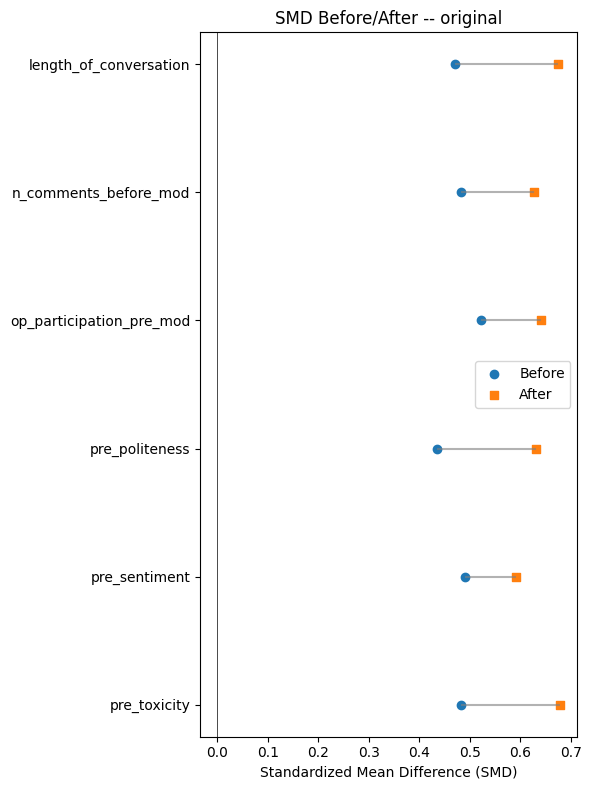

In [340]:
best = 'original'  # choose based on printed SMDs
plot_smd_comparison(smd_summary[smd_summary['transform'] == best]['smd_before'], smd_summary[smd_summary['transform'] == best]['smd_after'],
                    title=f"SMD Before/After -- {best}", covs=smd_summary[smd_summary['transform'] == best]['covariate'])

In [215]:
smd_summary[smd_summary['transform'] == best]


,covariate,transform,smd_before,smd_after
1,length_of_conversation,original,-0.486133,-0.350696
4,n_comments_before_mod,original,-0.380980,-0.125337
7,op_participation_pre_mod,original,0.324842,0.190205
10,pre_politeness,original,0.024158,-0.005850
13,pre_sentiment,original,-0.019399,-0.145797
16,pre_toxicity,original,-0.084869,-0.039364


In [324]:
threads_with_matches_subreddit = pd.merge(covariates_df_without_matches,
    finalized_original_matched_df[['_orig_idx', '_match_id', '_is_treated', 'subreddit']],
    left_index=True, right_on='_orig_idx', how='inner'
)

threads_with_matches_subreddit.sort_values(by=['_match_id_y', '_orig_idx_y'], ascending=True, inplace=True)

In [343]:
finalized_original_matched_df[finalized_original_matched_df['_match_id']==110]

,_orig_idx,link_id,authors,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation,precursor_text,...,op_participation_post_mod,treatment,post_politeness,post_toxicity,post_sentiment,num_utterances_post_moderation,subreddit,propensity_score,_match_id,_is_treated
220,600,t3_50w8k2,"['thegingermullet', 'KubrickIsMyCopilot', 'joe...",['It was also the most accurate judicial show ...,"['t3_50w8k2', 't3_50w8k2', 't3_50w8k2', 't1_d7...","['t1_d77fph0', 't1_d77frvb', 't1_d77g1xn', 't1...","[False, False, False, False, False, False, Fal...",31,87,It was also the most accurate judicial show of...,...,0.0,True,3.690361,0.024836,0.9727,55,television,0.306072,110,1
221,674,t3_4z1uwq,"['JessieJ577', 'EdKord', 'ChameleonTwist', 'sa...",['Oh great another Netflix comedy to feel emot...,"['t3_4z1uwq', 't3_4z1uwq', 't3_4z1uwq', 't3_4z...","['t1_d6s7y5o', 't1_d6s96vq', 't1_d6s9ygl', 't1...","[False, False, False, False, False, False, Fal...",33,70,Oh great another Netflix comedy to feel emotio...,...,0.0,False,3.581304,0.219122,-0.6868,7,television,0.323905,110,0


In [325]:
threads_with_matches_subreddit

,_orig_idx,link_id,authors,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation,precursor_text,...,pre_politeness,post_politeness,post_sentiment,post_toxicity,truncated_post_text,cleaned_truncated_post_text,_orig_idx_y,_match_id_y,_is_treated_y,subreddit
0,78,t3_4jqhj2,"[ZenRobots, mobius5, Desano, iAsmo, ResidentSl...",[Now that's a stream I'd watch. Pure entertain...,"[t3_4jqhj2, t3_4jqhj2, t3_4jqhj2, t3_4jqhj2, t...","[t1_d38o5ht, t1_d38oebn, t1_d38oprz, t1_d38p17...","[False, True, False, False, False, False, Fals...",1,12,Now that's a stream I'd watch. Pure entertainm...,...,3.283022,2.724555,0.7096,0.021429,Cringe| That guys a legend.| Hope he gets bann...,Cringe| That guys a legend.| Hope he gets bann...,78,0,1,2007scape
1,927,t3_5namft,"[musamban, [deleted], 01010101010111111111, [d...","[also because the raids hype for gear (dfs, ac...","[t3_5namft, t3_5namft, t3_5namft, t3_5namft, t...","[t1_dc9zpo0, t1_dc9zrjn, t1_dc9zs5n, t1_dca00z...","[False, False, False, True, False, False, True...",3,16,"also because the raids hype for gear (dfs, acb...",...,3.362162,3.267951,-0.5334,0.000420,The rarity combined with the fact its only 30%...,The rarity combined with the fact its only 30%...,927,0,0,2007scape
2,184,t3_4n46zd,"[Addy_Jihadi, [deleted], Dat_failskiller]",[Can you fuck off with these threads? Why cant...,"[t3_4n46zd, t3_4n46zd, t3_4n46zd]","[t1_d40r46h, t1_d40rvrh, t1_d40uod7]","[False, True, False]",1,3,Can you fuck off with these threads? Why cant ...,...,1.528020,3.152863,-0.4588,0.003804,"I mean, i got perm banned twice for flaming so...","I mean, i got perm banned twice for flaming so...",184,1,1,2007scape
3,811,t3_5s7kbz,"[runeleg, [deleted], ProfessorHerbert, [delete...",[edgeville pking with 115 hp 3 tick 6 ways and...,"[t3_5s7kbz, t3_5s7kbz, t3_5s7kbz, t1_ddczuqn, ...","[t1_ddcxsmt, t1_ddcxxwn, t1_ddczuqn, t1_ddd1z5...","[False, True, False, True, False]",1,5,edgeville pking with 115 hp 3 tick 6 ways and ...,...,3.031831,2.622896,-0.2732,0.443601,you got 1 kill this whole vid. you probably lo...,you got 1 kill this whole vid. you probably lo...,811,1,0,2007scape
4,280,t3_4rtiie,"[GamingAlpaca, [deleted], lieutenantowned, [de...",[Or maybe besides a clue scroll a random piece...,"[t3_4rtiie, t3_4rtiie, t3_4rtiie, t3_4rtiie, t...","[t1_d53zsn3, t1_d53zsos, t1_d53zsy1, t1_d53ztb...","[False, True, False, False, False, False, Fals...",1,43,Or maybe besides a clue scroll a random piece ...,...,3.559370,3.826556,0.8832,0.001383,meme/10\n\nwould support jamflex pls| [removed...,meme/10 would support jamflex pls| [removed]|...,280,2,1,2007scape
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,527,t3_5vdb2d,"[Flowseidon9, Kevo271, Rozurts, KamateKaora, K...","[What are you trying to get at here?, Probably...","[t3_5vdb2d, t3_5vdb2d, t3_5vdb2d, t1_de18e0b, ...","[t1_de17p5c, t1_de18e0b, t1_de18xj6, t1_de18xl...","[False, False, False, False, False, False, Fal...",32,54,What are you trying to get at here? Probably b...,...,3.862190,2.988847,0.6249,0.000416,You really just can;t handle being wrong can y...,You really just can;t handle being wrong can y...,527,116,0,wow
235,49,t3_4hhnno,"[beepborpimajorp, UselessWidget, BattleNub89, ...","[What, specifically, happened? This post doesn...","[t3_4hhnno, t3_4hhnno, t3_4hhnno, t3_4hhnno, t...","[t1_d2podzv, t1_d2poks0, t1_d2poqql, t1_d2pow2...","[False, False, False, False, False, False, Fal...",18,75,"What, specifically, happened? This post doesn'...",...,3.178753,2.995642,0.9992,0.089335,Honestly that's probably the reason right ther...,Honestly that's probably the reason right ther...,49,117,0,wow
234,539,t3_4zcqr5,"[drycz, acederp, acederp, Hyoumu, Hyoumu, XGDr...",[This is actually handy. You get to continue l...,"[t3_4zcqr5, t3_4zcqr5, t1_d6unxdb, t1_d6uny7q,...","[t1_d6unshu, t1_d6unxdb, t1_d6uny7q, t1_d6uo6a...","[False, False, False, False, False, False, Fal...",25,56,This is actually handy. You get to

In [326]:
matched_df_summarized_subreddit = (
    threads_with_matches_subreddit.groupby('_match_id_y', as_index=False)
    .agg(
        num_utterances_post_mod_list=('num_utterances_post_moderation', list),
        _is_treated=('_is_treated_y', list),
        _orig_idx=('_orig_idx_y', list),
        post_text=('post_text', list)
    )
)

# Step 2: Function to produce truncated text for both control & treatment
def truncate_post_text(row):
    # Unpack lists for this match
    post_texts = row['post_text']
    num_utterances = row['num_utterances_post_mod_list']
    orig_idx = row['_orig_idx']
    is_treated_list = row['_is_treated']

    # Ensure consistent order: treated first
    if is_treated_list[0]:
        treated_idx, control_idx = 0, 1
    else:
        treated_idx, control_idx = 1, 0

    # Extract both texts
    treated_post = post_texts[treated_idx]
    control_post = post_texts[control_idx]

    # Extract the number of utterances in control before second moderation
    target_len = num_utterances[control_idx]

    # Split and truncate the treated text
    treated_utts = [u.strip().replace('\n', ' ').replace('"', '') for u in treated_post.split('|') if u.strip()]
    truncated_treated_utts = treated_utts[:target_len]
    truncated_treated_post = "| ".join(truncated_treated_utts)

    # Return a small dataframe for both
    return pd.DataFrame([
        {'_original_id': orig_idx[treated_idx], 'final_truncated_post_text': truncated_treated_post},
        {'_original_id': orig_idx[control_idx], 'final_truncated_post_text': control_post}
    ])

# Step 3: Apply and concatenate results
truncated_post_text_df = pd.concat(
    matched_df_summarized_subreddit.apply(truncate_post_text, axis=1).tolist(),
    ignore_index=True
)
truncated_post_text_df

,_original_id,final_truncated_post_text
0,78,Cringe| That guys a legend.
1,927,The rarity combined with the fact its only 30%...
2,184,"I mean, i got perm banned twice for flaming so..."
3,811,you got 1 kill this whole vid. you probably lo...
4,280,meme/10 would support jamflex pls| [removed]
...,...,...
233,527,You really just can;t handle being wrong can y...
234,539,And if you want to save different talent build...
235,49,Honestly that's probably the reason right ther...
236,578,"Yup, very annoying :( can't even see them duri..."


In [327]:
threads_with_matches_subreddit = threads_with_matches_subreddit.merge(
    truncated_post_text_df,
    right_on='_original_id',
    left_on='_orig_idx_y',
    how='left'
)
threads_with_matches_subreddit[threads_with_matches_subreddit['_is_treated_y'] == 1]


,_orig_idx,link_id,authors,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation,precursor_text,...,post_sentiment,post_toxicity,truncated_post_text,cleaned_truncated_post_text,_orig_idx_y,_match_id_y,_is_treated_y,subreddit,_original_id,final_truncated_post_text
0,78,t3_4jqhj2,"[ZenRobots, mobius5, Desano, iAsmo, ResidentSl...",[Now that's a stream I'd watch. Pure entertain...,"[t3_4jqhj2, t3_4jqhj2, t3_4jqhj2, t3_4jqhj2, t...","[t1_d38o5ht, t1_d38oebn, t1_d38oprz, t1_d38p17...","[False, True, False, False, False, False, Fals...",1,12,Now that's a stream I'd watch. Pure entertainm...,...,0.7096,0.021429,Cringe| That guys a legend.| Hope he gets bann...,Cringe| That guys a legend.| Hope he gets bann...,78,0,1,2007scape,78,Cringe| That guys a legend.
2,184,t3_4n46zd,"[Addy_Jihadi, [deleted], Dat_failskiller]",[Can you fuck off with these threads? Why cant...,"[t3_4n46zd, t3_4n46zd, t3_4n46zd]","[t1_d40r46h, t1_d40rvrh, t1_d40uod7]","[False, True, False]",1,3,Can you fuck off with these threads? Why cant ...,...,-0.4588,0.003804,"I mean, i got perm banned twice for flaming so...","I mean, i got perm banned twice for flaming so...",184,1,1,2007scape,184,"I mean, i got perm banned twice for flaming so..."
4,280,t3_4rtiie,"[GamingAlpaca, [deleted], lieutenantowned, [de...",[Or maybe besides a clue scroll a random piece...,"[t3_4rtiie, t3_4rtiie, t3_4rtiie, t3_4rtiie, t...","[t1_d53zsn3, t1_d53zsos, t1_d53zsy1, t1_d53ztb...","[False, True, False, False, False, False, Fals...",1,43,Or maybe besides a clue scroll a random piece ...,...,0.8832,0.001383,meme/10\n\nwould support jamflex pls| [removed...,meme/10 would support jamflex pls| [removed]|...,280,2,1,2007scape,280,meme/10 would support jamflex pls| [removed]
7,1135,t3_5u4qoq,"[drvgonzord, beastskitta, spanky250, sakamake,...",[it isn't a lie if they believe it. that chang...,"[t3_5u4qoq, t3_5u4qoq, t3_5u4qoq, t3_5u4qoq, t...","[t1_ddrbwmw, t1_ddrbya9, t1_ddrbyes, t1_ddrc2i...","[False, False, False, False, False, False, Fal...",112,205,it isn't a lie if they believe it. that change...,...,0.7282,0.010590,"The method of ""Identify your self-sabotaging b...",The method of Identify your self-sabotaging be...,1135,3,1,AskReddit,1135,The method of Identify your self-sabotaging be...
8,172,t3_4mshe5,"[Hoplite99, AwayWeGo112, Supah_sTrump, dmirtyg...",[You're talking about it as are lots of other ...,"[t3_4mshe5, t3_4mshe5, t1_d3xxm0q, t1_d3xy49q,...","[t1_d3xxm0q, t1_d3xy49q, t1_d3xybaa, t1_d3xyey...","[False, False, False, True, False, False, Fals...",3,92,You're talking about it as are lots of other p...,...,-0.9786,0.030435,OP kind of looks like a concern troll from his...,OP kind of looks like a concern troll from his...,172,4,1,AskTrumpSupporters,172,OP kind of looks like a concern troll from his...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,300,t3_4s6e6r,"[brock_lee, rhombusleech, [deleted], jiggernau...",[That is a drill. It was run off of cables fr...,"[t3_4s6e6r, t3_4s6e6r, t1_d56u4pq, t1_d56u4pq,...","[t1_d56u4pq, t1_d56u530, t1_d56uv5t, t1_d56yzb...","[False, False, True, False, False, False, False]",2,7,That is a drill. It was run off of cables fro...,...,0.0000,0.045239,whoa! What a contraption,whoa! What a contraption,300,114,1,whatisthisthing,300,whoa! What a contraption| [removed]| Solved!
231,636,t3_52tohm,"[[deleted], biyaaatch, Blibbobletto, alyons108...","[[removed], Title made me laugh a lot, Looks l...","[t3_52tohm, t3_52tohm, t3_52tohm, t1_d7n7ub8, ...","[t1_d7n718h, t1_d7n7f6z, t1_d7n7ub8, t1_d7n8xt...","[False, True, False, False, False, False, False]",1,7,[removed],...,0.3612,0.000871,Looks like a [pickle fork](https://www.picklea...,Looks like a [pickle fork](https://www.picklea...,636,115,1,whatisthisthing,636,Looks like a [pickle fork](https://www.picklea...
232,76,t3_4jq92j,"[Snichy, xAdvex, Calamity_gg, DTfan82, Rockete...",[Not everyone has the disposable income to spe...,"[t3_4jq92j, t

In [297]:
# threads_with_matches_subreddit.to_csv("pushshift_matches_with_subreddit_and_covariates.csv")

In [328]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from politenessr import Politenessr
from detoxify import Detoxify
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# ========== Setup ==========
nltk.download('vader_lexicon', quiet=True)

politeness_model = Politenessr()
toxicity_model = Detoxify('original')
sentiment_model = SentimentIntensityAnalyzer()

# ========== Helper batch functions ==========

def batchify(series, batch_size=32):
    """Yield successive batches from a pandas Series."""
    for i in range(0, len(series), batch_size):
        yield series.iloc[i:i+batch_size]

def batch_politeness(texts):
    """Return list of politeness scores for a list of texts."""
    try:
        preds = politeness_model.predict(texts)
        # ensure it’s a flat list even for single input
        return np.atleast_1d(preds).tolist()
    except Exception as e:
        print("Politeness batch error:", e)
        return [np.nan] * len(texts)

def batch_toxicity(texts):
    """Return mean toxicity per text."""
    try:
        results = toxicity_model.predict(texts)
        # results = dict of {category: np.array([scores...])}
        toxicity_vals = np.mean(np.vstack(list(results.values())), axis=0)
        return toxicity_vals.tolist()
    except Exception as e:
        print("Detoxify batch error:", e)
        return [np.nan] * len(texts)

def batch_sentiment(texts):
    """Return VADER compound sentiment per text."""
    return [
        sentiment_model.polarity_scores(t)['compound']
        if isinstance(t, str) and t.strip() else np.nan
        for t in texts
    ]

# ========== Apply to dataframe in batches ==========

def apply_in_batches(df, text_col, prefix, batch_size=32):
    politeness_scores = []
    toxicity_scores = []
    sentiment_scores = []

    for batch in tqdm(batchify(df[text_col], batch_size=batch_size), desc=f"Processing {prefix}"):
        texts = batch.fillna("").tolist()
        batch_politeness_scores = batch_politeness(texts)
        batch_toxicity_scores = batch_toxicity(texts)
        batch_sentiment_scores = batch_sentiment(texts)

        politeness_scores.extend(batch_politeness_scores)
        toxicity_scores.extend(batch_toxicity_scores)
        sentiment_scores.extend(batch_sentiment_scores)

    df[f'{prefix}_politeness'] = politeness_scores
    df[f'{prefix}_toxicity'] = toxicity_scores
    df[f'{prefix}_sentiment'] = sentiment_scores

# ========== Run truncated post text ==========
apply_in_batches(threads_with_matches_subreddit, 'final_truncated_post_text', 'post', batch_size=64)

11/13/2025 16:06:11 - INFO - pytorch_transformers.modeling_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at /Users/himnish.hunma/.cache/torch/pytorch_transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.9da767be51e1327499df13488672789394e2ca38b877837e52618a67d7002391
11/13/2025 16:06:11 - INFO - pytorch_transformers.modeling_utils -   Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "pad_token_id": 0,
  "pruned_heads": {},
  "torchscript": false,
  "

In [377]:
threads_with_matches_without_nulls_subreddit

,_orig_idx,link_id,authors,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation,precursor_text,...,cleaned_truncated_post_text,_orig_idx_y,_match_id_y,_is_treated_y,subreddit,_original_id,final_truncated_post_text,toxicity_difference,politeness_difference,sentiment_difference
0,78,t3_4jqhj2,"[ZenRobots, mobius5, Desano, iAsmo, ResidentSl...",[Now that's a stream I'd watch. Pure entertain...,"[t3_4jqhj2, t3_4jqhj2, t3_4jqhj2, t3_4jqhj2, t...","[t1_d38o5ht, t1_d38oebn, t1_d38oprz, t1_d38p17...","[False, True, False, False, False, False, Fals...",1,12,Now that's a stream I'd watch. Pure entertainm...,...,Cringe| That guys a legend.| Hope he gets bann...,78,0,1,2007scape,78,Cringe| That guys a legend.,0.003418,-0.350353,-0.4215
1,927,t3_5namft,"[musamban, [deleted], 01010101010111111111, [d...","[also because the raids hype for gear (dfs, ac...","[t3_5namft, t3_5namft, t3_5namft, t3_5namft, t...","[t1_dc9zpo0, t1_dc9zrjn, t1_dc9zs5n, t1_dca00z...","[False, False, False, True, False, False, True...",3,16,"also because the raids hype for gear (dfs, acb...",...,The rarity combined with the fact its only 30%...,927,0,0,2007scape,927,The rarity combined with the fact its only 30%...,0.000198,-0.094211,-1.3460
2,184,t3_4n46zd,"[Addy_Jihadi, [deleted], Dat_failskiller]",[Can you fuck off with these threads? Why cant...,"[t3_4n46zd, t3_4n46zd, t3_4n46zd]","[t1_d40r46h, t1_d40rvrh, t1_d40uod7]","[False, True, False]",1,3,Can you fuck off with these threads? Why cant ...,...,"I mean, i got perm banned twice for flaming so...",184,1,1,2007scape,184,"I mean, i got perm banned twice for flaming so...",-0.511516,1.624843,0.3034
3,811,t3_5s7kbz,"[runeleg, [deleted], ProfessorHerbert, [delete...",[edgeville pking with 115 hp 3 tick 6 ways and...,"[t3_5s7kbz, t3_5s7kbz, t3_5s7kbz, t1_ddczuqn, ...","[t1_ddcxsmt, t1_ddcxxwn, t1_ddczuqn, t1_ddd1z5...","[False, True, False, True, False]",1,5,edgeville pking with 115 hp 3 tick 6 ways and ...,...,you got 1 kill this whole vid. you probably lo...,811,1,0,2007scape,811,you got 1 kill this whole vid. you probably lo...,0.430826,-0.408935,-0.2732
4,280,t3_4rtiie,"[GamingAlpaca, [deleted], lieutenantowned, [de...",[Or maybe besides a clue scroll a random piece...,"[t3_4rtiie, t3_4rtiie, t3_4rtiie, t3_4rtiie, t...","[t1_d53zsn3, t1_d53zsos, t1_d53zsy1, t1_d53ztb...","[False, True, False, False, False, False, Fals...",1,43,Or maybe besides a clue scroll a random piece ...,...,meme/10 would support jamflex pls| [removed]|...,280,2,1,2007scape,280,meme/10 would support jamflex pls| [removed],0.000015,-0.428288,-0.5636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,527,t3_5vdb2d,"[Flowseidon9, Kevo271, Rozurts, KamateKaora, K...","[What are you trying to get at here?, Probably...","[t3_5vdb2d, t3_5vdb2d, t3_5vdb2d, t1_de18e0b, ...","[t1_de17p5c, t1_de18e0b, t1_de18xj6, t1_de18xl...","[False, False, False, False, False, False, Fal...",32,54,What are you trying to get at here? Probably b...,...,You really just can;t handle being wrong can y...,527,116,0,wow,527,You really just can;t handle being wrong can y...,-0.249888,-0.873343,-0.3617
234,49,t3_4hhnno,"[beepborpimajorp, UselessWidget, BattleNub89, ...","[What, specifically, happened? This post doesn...","[t3_4hhnno, t3_4hhnno, t3_4hhnno, t3_4hhnno, t...","[t1_d2podzv, t1_d2poks0, t1_d2poqql, t1_d2pow2...","[False, False, False, False, False, False, Fal...",18,75,"What, specifically, happened? This post doesn'...",...,Honestly that's probably the reason right ther...,49,117,0,wow,49,Honestly that's probably the reason right ther...,0.088987,-0.334028,0.0022
235,539,t3_4zcqr5,"[drycz, acederp, acederp, Hyoumu, Hyoumu, XGDr...",[This is actually handy. You get to continue l...,"[t3_4zcqr5, t3_4zcqr5, t1_d6unxdb, t1_d6uny7q,...","[t1_d6unshu, t1_d6unxdb, t1_d6uny7q, t1_d6uo6a...","[False, False, False, False, False, False, Fal...",25,56,This is actually handy. You get to continue li...,...,And if you w

In [382]:
# threads_with_matches_without_nulls_subreddit[threads_with_matches_without_nulls_subreddit['_is_treated_y'] == 1][['_orig_idx_y', 'final_truncated_post_text']].to_csv("nudge_window_treated_with_id_subreddit.csv")
# threads_with_matches_without_nulls_subreddit[['_orig_idx_y', 'final_truncated_post_text']].to_csv("nudge_window_both_recovered_unrecovered_with_id_subreddit.csv")

In [329]:
threads_with_matches_without_nulls_subreddit = threads_with_matches_subreddit.dropna(subset=['post_politeness', 'post_toxicity', 'post_sentiment'])
threads_with_matches_without_nulls_subreddit

,_orig_idx,link_id,authors,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation,precursor_text,...,post_sentiment,post_toxicity,truncated_post_text,cleaned_truncated_post_text,_orig_idx_y,_match_id_y,_is_treated_y,subreddit,_original_id,final_truncated_post_text
0,78,t3_4jqhj2,"[ZenRobots, mobius5, Desano, iAsmo, ResidentSl...",[Now that's a stream I'd watch. Pure entertain...,"[t3_4jqhj2, t3_4jqhj2, t3_4jqhj2, t3_4jqhj2, t...","[t1_d38o5ht, t1_d38oebn, t1_d38oprz, t1_d38p17...","[False, True, False, False, False, False, Fals...",1,12,Now that's a stream I'd watch. Pure entertainm...,...,0.0000,0.003651,Cringe| That guys a legend.| Hope he gets bann...,Cringe| That guys a legend.| Hope he gets bann...,78,0,1,2007scape,78,Cringe| That guys a legend.
1,927,t3_5namft,"[musamban, [deleted], 01010101010111111111, [d...","[also because the raids hype for gear (dfs, ac...","[t3_5namft, t3_5namft, t3_5namft, t3_5namft, t...","[t1_dc9zpo0, t1_dc9zrjn, t1_dc9zs5n, t1_dca00z...","[False, False, False, True, False, False, True...",3,16,"also because the raids hype for gear (dfs, acb...",...,-0.5334,0.000420,The rarity combined with the fact its only 30%...,The rarity combined with the fact its only 30%...,927,0,0,2007scape,927,The rarity combined with the fact its only 30%...
2,184,t3_4n46zd,"[Addy_Jihadi, [deleted], Dat_failskiller]",[Can you fuck off with these threads? Why cant...,"[t3_4n46zd, t3_4n46zd, t3_4n46zd]","[t1_d40r46h, t1_d40rvrh, t1_d40uod7]","[False, True, False]",1,3,Can you fuck off with these threads? Why cant ...,...,-0.4588,0.003804,"I mean, i got perm banned twice for flaming so...","I mean, i got perm banned twice for flaming so...",184,1,1,2007scape,184,"I mean, i got perm banned twice for flaming so..."
3,811,t3_5s7kbz,"[runeleg, [deleted], ProfessorHerbert, [delete...",[edgeville pking with 115 hp 3 tick 6 ways and...,"[t3_5s7kbz, t3_5s7kbz, t3_5s7kbz, t1_ddczuqn, ...","[t1_ddcxsmt, t1_ddcxxwn, t1_ddczuqn, t1_ddd1z5...","[False, True, False, True, False]",1,5,edgeville pking with 115 hp 3 tick 6 ways and ...,...,-0.2732,0.443601,you got 1 kill this whole vid. you probably lo...,you got 1 kill this whole vid. you probably lo...,811,1,0,2007scape,811,you got 1 kill this whole vid. you probably lo...
4,280,t3_4rtiie,"[GamingAlpaca, [deleted], lieutenantowned, [de...",[Or maybe besides a clue scroll a random piece...,"[t3_4rtiie, t3_4rtiie, t3_4rtiie, t3_4rtiie, t...","[t1_d53zsn3, t1_d53zsos, t1_d53zsy1, t1_d53ztb...","[False, True, False, False, False, False, Fals...",1,43,Or maybe besides a clue scroll a random piece ...,...,0.4019,0.000243,meme/10\n\nwould support jamflex pls| [removed...,meme/10 would support jamflex pls| [removed]|...,280,2,1,2007scape,280,meme/10 would support jamflex pls| [removed]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,527,t3_5vdb2d,"[Flowseidon9, Kevo271, Rozurts, KamateKaora, K...","[What are you trying to get at here?, Probably...","[t3_5vdb2d, t3_5vdb2d, t3_5vdb2d, t1_de18e0b, ...","[t1_de17p5c, t1_de18e0b, t1_de18xj6, t1_de18xl...","[False, False, False, False, False, False, Fal...",32,54,What are you trying to get at here? Probably b...,...,0.6249,0.000416,You really just can;t handle being wrong can y...,You really just can;t handle being wrong can y...,527,116,0,wow,527,You really just can;t handle being wrong can y...
234,49,t3_4hhnno,"[beepborpimajorp, UselessWidget, BattleNub89, ...","[What, specifically, happened? This post doesn...","[t3_4hhnno, t3_4hhnno, t3_4hhnno, t3_4hhnno, t...","[t1_d2podzv, t1_d2poks0, t1_d2poqql, t1_d2pow2...","[False, False, False, False, False, False, Fal...",18,75,"What, specifically, happened? This post doesn'...",...,0.9992,0.090241,Honestly that's probably the reason right ther...,Honestly that's probably the reason right ther...,49,117,0,wow,49,Honestly that's probably the reason right ther...
235,539,t3_4zcqr5,"[drycz, acederp, acederp, Hyoumu, Hyoumu, XGDr...",[This is actu

$$logit(Conversation Recovers) = \beta_0 + \beta_1(post\_toxicity-pre\_toxicity) + \beta_2(post\_politeness - pre\_politeness) +$$

$$\beta_3(post\_sentiment - pre\_sentiment) + \beta_4(n\_comments\_before\_mod) + \beta_5(length\_of\_conversation) + \beta_6(op\_participation\_pre\_mod) + \beta_7(op\_participation\_post\_mod) + \beta_8(author\_diversity)$$

In [330]:
threads_with_matches_without_nulls_subreddit['toxicity_difference'] = threads_with_matches_without_nulls_subreddit['post_toxicity'] - threads_with_matches_without_nulls_subreddit['pre_toxicity']
threads_with_matches_without_nulls_subreddit['politeness_difference'] = threads_with_matches_without_nulls_subreddit['post_politeness'] - threads_with_matches_without_nulls_subreddit['pre_politeness']
threads_with_matches_without_nulls_subreddit['sentiment_difference'] = threads_with_matches_without_nulls_subreddit['post_sentiment'] - threads_with_matches_without_nulls_subreddit['pre_sentiment']

In [331]:
threads_with_matches_without_nulls_subreddit

,_orig_idx,link_id,authors,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation,precursor_text,...,cleaned_truncated_post_text,_orig_idx_y,_match_id_y,_is_treated_y,subreddit,_original_id,final_truncated_post_text,toxicity_difference,politeness_difference,sentiment_difference
0,78,t3_4jqhj2,"[ZenRobots, mobius5, Desano, iAsmo, ResidentSl...",[Now that's a stream I'd watch. Pure entertain...,"[t3_4jqhj2, t3_4jqhj2, t3_4jqhj2, t3_4jqhj2, t...","[t1_d38o5ht, t1_d38oebn, t1_d38oprz, t1_d38p17...","[False, True, False, False, False, False, Fals...",1,12,Now that's a stream I'd watch. Pure entertainm...,...,Cringe| That guys a legend.| Hope he gets bann...,78,0,1,2007scape,78,Cringe| That guys a legend.,0.003418,-0.350353,-0.4215
1,927,t3_5namft,"[musamban, [deleted], 01010101010111111111, [d...","[also because the raids hype for gear (dfs, ac...","[t3_5namft, t3_5namft, t3_5namft, t3_5namft, t...","[t1_dc9zpo0, t1_dc9zrjn, t1_dc9zs5n, t1_dca00z...","[False, False, False, True, False, False, True...",3,16,"also because the raids hype for gear (dfs, acb...",...,The rarity combined with the fact its only 30%...,927,0,0,2007scape,927,The rarity combined with the fact its only 30%...,0.000198,-0.094211,-1.3460
2,184,t3_4n46zd,"[Addy_Jihadi, [deleted], Dat_failskiller]",[Can you fuck off with these threads? Why cant...,"[t3_4n46zd, t3_4n46zd, t3_4n46zd]","[t1_d40r46h, t1_d40rvrh, t1_d40uod7]","[False, True, False]",1,3,Can you fuck off with these threads? Why cant ...,...,"I mean, i got perm banned twice for flaming so...",184,1,1,2007scape,184,"I mean, i got perm banned twice for flaming so...",-0.511516,1.624843,0.3034
3,811,t3_5s7kbz,"[runeleg, [deleted], ProfessorHerbert, [delete...",[edgeville pking with 115 hp 3 tick 6 ways and...,"[t3_5s7kbz, t3_5s7kbz, t3_5s7kbz, t1_ddczuqn, ...","[t1_ddcxsmt, t1_ddcxxwn, t1_ddczuqn, t1_ddd1z5...","[False, True, False, True, False]",1,5,edgeville pking with 115 hp 3 tick 6 ways and ...,...,you got 1 kill this whole vid. you probably lo...,811,1,0,2007scape,811,you got 1 kill this whole vid. you probably lo...,0.430826,-0.408935,-0.2732
4,280,t3_4rtiie,"[GamingAlpaca, [deleted], lieutenantowned, [de...",[Or maybe besides a clue scroll a random piece...,"[t3_4rtiie, t3_4rtiie, t3_4rtiie, t3_4rtiie, t...","[t1_d53zsn3, t1_d53zsos, t1_d53zsy1, t1_d53ztb...","[False, True, False, False, False, False, Fals...",1,43,Or maybe besides a clue scroll a random piece ...,...,meme/10 would support jamflex pls| [removed]|...,280,2,1,2007scape,280,meme/10 would support jamflex pls| [removed],0.000015,-0.428288,-0.5636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,527,t3_5vdb2d,"[Flowseidon9, Kevo271, Rozurts, KamateKaora, K...","[What are you trying to get at here?, Probably...","[t3_5vdb2d, t3_5vdb2d, t3_5vdb2d, t1_de18e0b, ...","[t1_de17p5c, t1_de18e0b, t1_de18xj6, t1_de18xl...","[False, False, False, False, False, False, Fal...",32,54,What are you trying to get at here? Probably b...,...,You really just can;t handle being wrong can y...,527,116,0,wow,527,You really just can;t handle being wrong can y...,-0.249888,-0.873343,-0.3617
234,49,t3_4hhnno,"[beepborpimajorp, UselessWidget, BattleNub89, ...","[What, specifically, happened? This post doesn...","[t3_4hhnno, t3_4hhnno, t3_4hhnno, t3_4hhnno, t...","[t1_d2podzv, t1_d2poks0, t1_d2poqql, t1_d2pow2...","[False, False, False, False, False, False, Fal...",18,75,"What, specifically, happened? This post doesn'...",...,Honestly that's probably the reason right ther...,49,117,0,wow,49,Honestly that's probably the reason right ther...,0.088987,-0.334028,0.0022
235,539,t3_4zcqr5,"[drycz, acederp, acederp, Hyoumu, Hyoumu, XGDr...",[This is actually handy. You get to continue l...,"[t3_4zcqr5, t3_4zcqr5, t1_d6unxdb, t1_d6uny7q,...","[t1_d6unshu, t1_d6unxdb, t1_d6uny7q, t1_d6uo6a...","[False, False, False, False, False, False, Fal...",25,56,This is actually handy. You get to continue li...,...,And if you w

In [332]:
from statsmodels.discrete.conditional_models import ConditionalLogit

features = ['toxicity_difference', 'politeness_difference', 'sentiment_difference', 'n_comments_before_mod', 'length_of_conversation', 'op_participation_pre_mod', 'op_participation_post_mod', 'author_diversity', 'subreddit']
# model = smf.logit("_is_treated ~ toxicity_difference + politeness_difference + sentiment_difference + n_comments_before_mod + length_of_conversation + op_participation_pre_mod + op_participation_post_mod + author_diversity + C(_match_id)", data=threads_with_matches_without_nulls)
# result = model.fit()
# print(result.summary())

model = ConditionalLogit.from_formula(
    "_is_treated_y ~ toxicity_difference + politeness_difference + sentiment_difference + n_comments_before_mod + length_of_conversation + op_participation_pre_mod + op_participation_post_mod + author_diversity -1",
    groups="_match_id_y",
    data=threads_with_matches_without_nulls_subreddit
)
result = model.fit()
print(result.summary())

                  Conditional Logit Model Regression Results                  
Dep. Variable:          _is_treated_y   No. Observations:                  238
Model:               ConditionalLogit   No. groups:                        119
Log-Likelihood:               -76.494   Min group size:                      2
Method:                          BFGS   Max group size:                      2
Date:                Thu, 13 Nov 2025   Mean group size:                   2.0
Time:                        16:06:53                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
toxicity_difference           0.0558      1.271      0.044      0.965      -2.435       2.546
politeness_difference         0.1856      0.314      0.591      0.555      -0.430       0.802
sentiment_difference          0.0068      0.215      0.032      0.975  

/Users/himnish.hunma/Repos/CS 598/nudge-convo-back/nudge-convo-back-env/lib/python3.9/site-packages/statsmodels/discrete/conditional_models.py:205: UserWarning: Conditional models should not include an intercept
  warnings.warn("Conditional models should not include an intercept")
/Users/himnish.hunma/Repos/CS 598/nudge-convo-back/nudge-convo-back-env/lib/python3.9/site-packages/statsmodels/discrete/conditional_models.py:266: RuntimeWarning: overflow encountered in exp
  exb = np.exp(np.dot(self._exog_grp[grp], params) + ofs)
/Users/himnish.hunma/Repos/CS 598/nudge-convo-back/nudge-convo-back-env/lib/python3.9/site-packages/statsmodels/discrete/conditional_models.py:296: RuntimeWarning: overflow encountered in exp
  exb = np.exp(np.dot(ex, params) + ofs)
/Users/himnish.hunma/Repos/CS 598/nudge-convo-back/nudge-convo-back-env/lib/python3.9/site-packages/statsmodels/discrete/conditional_models.py:317: RuntimeWarning: invalid value encountered in multiply
  d = c * h * ex[t - 1, :]
/Users

In [333]:
features = ['pre_toxicity', 'post_toxicity', 'pre_politeness', 'post_politeness', 'pre_sentiment', 'post_sentiment', 'n_comments_before_mod', 'length_of_conversation', 'op_participation_pre_mod', 'op_participation_post_mod', 'author_diversity']
#
# X = threads_with_matches_without_nulls[features]
# X = sm.add_constant(X)
# y = threads_with_matches_without_nulls['treatment']
#
# logit_model = sm.Logit(y, X).fit()
# print(logit_model.summary())
model = ConditionalLogit.from_formula(
    "_is_treated_y ~ pre_toxicity + post_toxicity + pre_politeness + post_politeness + pre_sentiment + post_sentiment + n_comments_before_mod + length_of_conversation + op_participation_pre_mod + op_participation_post_mod + author_diversity -1",
    groups="_match_id_y",
    data=threads_with_matches_without_nulls_subreddit
)
result = model.fit()
print(result.summary())

                  Conditional Logit Model Regression Results                  
Dep. Variable:          _is_treated_y   No. Observations:                  238
Model:               ConditionalLogit   No. groups:                        119
Log-Likelihood:               -73.354   Min group size:                      2
Method:                          BFGS   Max group size:                      2
Date:                Thu, 13 Nov 2025   Mean group size:                   2.0
Time:                        16:06:53                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
pre_toxicity                 -0.6398      1.673     -0.383      0.702      -3.918       2.639
post_toxicity                -1.1953      1.764     -0.678      0.498      -4.652       2.262
pre_politeness               -1.0539      0.507     -2.078      0.038  

/Users/himnish.hunma/Repos/CS 598/nudge-convo-back/nudge-convo-back-env/lib/python3.9/site-packages/statsmodels/discrete/conditional_models.py:205: UserWarning: Conditional models should not include an intercept
  warnings.warn("Conditional models should not include an intercept")
/Users/himnish.hunma/Repos/CS 598/nudge-convo-back/nudge-convo-back-env/lib/python3.9/site-packages/statsmodels/discrete/conditional_models.py:266: RuntimeWarning: overflow encountered in exp
  exb = np.exp(np.dot(self._exog_grp[grp], params) + ofs)
/Users/himnish.hunma/Repos/CS 598/nudge-convo-back/nudge-convo-back-env/lib/python3.9/site-packages/statsmodels/discrete/conditional_models.py:296: RuntimeWarning: overflow encountered in exp
  exb = np.exp(np.dot(ex, params) + ofs)
/Users/himnish.hunma/Repos/CS 598/nudge-convo-back/nudge-convo-back-env/lib/python3.9/site-packages/statsmodels/discrete/conditional_models.py:317: RuntimeWarning: invalid value encountered in multiply
  d = c * h * ex[t - 1, :]
/Users

# Rebuild dataset when needed

One issue we run into is the RAM getting cleared and the notebook having to regenerate the data every single time. I will create a section to reload key tables when needed.


In [303]:
import pandas as pd
import numpy as np

moderated_df = pd.read_csv('om-data-2.csv')

moderated_df["name"] = f"t1_"+ moderated_df['id']
names_df = moderated_df[moderated_df["name"].notna()]

names_df = names_df.sort_values(by=['created_utc'])

threads = (
    names_df.groupby('link_id')
    .agg({
        'body': list,
        'parent_id': list,
        'name': list,
        'removed': list
    })
    .reset_index()
)

def n_comments_before_mod(list, stop_value = True):
    counter = 0
    for element in list:
        if element == stop_value:
            return counter
        else:
            counter += 1
    return counter
threads["n_comments_before_mod"] = threads["removed"].apply(lambda x: n_comments_before_mod(x, True))

threads["length_of_conversation"] = threads["name"].apply(lambda x: len(x))

mask = threads['n_comments_before_mod'].apply(lambda x: x > 0)
mask1 = threads['length_of_conversation'].apply(lambda x: x > 1)
mask3 = threads['removed'].apply(lambda x: sum(x) >= 1 and np.prod(x) == 0)
combined_mask = mask & mask1 & mask3
filtered_threads = threads[combined_mask]

def split_thread(row):
    body_list = row['body'] if isinstance(row['body'], list) else []
    body_list = [x for x in body_list if isinstance(x, str) and x.strip()]
    removed_list = row['removed'] if isinstance(row['removed'], list) else []
    n = min(int(row['n_comments_before_mod']), len(body_list))
    precursor = " ".join(body_list[:n])
    if n+1 > len(body_list):
        return pd.Series({'precursor_text': precursor, 'post_text': '', 'num_utterances_post_moderation': 0})
    post_utterances = body_list[n+1:]
    post_removals = removed_list[n+1:]
    print(f"post_removals: {post_removals}, post_utterances: {post_utterances}")
    post_text = ""
    num_utterances_post_moderation = 0
    for index, utterance in enumerate(post_utterances):
        if post_removals[index] == True:
            break
        post_text += utterance.replace('\n', ' ').replace('"', '') + "| "
        num_utterances_post_moderation += 1
    return pd.Series({'precursor_text': precursor, 'post_text': post_text, 'num_utterances_post_moderation': num_utterances_post_moderation})

filtered_threads[['precursor_text', 'post_text', 'num_utterances_post_moderation']] = filtered_threads.apply(split_thread, axis=1)

aggregated_authors = names_df.groupby('link_id').agg(authors=('author', list))
filtered_threads_with_authors = pd.merge(aggregated_authors, filtered_threads, on='link_id', how='right')

def count_op_appearances(row):
    n_comments_before_mod = row['n_comments_before_mod'] if isinstance(row['n_comments_before_mod'], int) else 0
    authors = row['authors'] if isinstance(row['authors'], list) else []

    op_author = authors[0]
    op_appearances_pre_mod = 1
    op_appearances_post_mod = 0

    for index, author in enumerate(authors[1:]):
        if author == op_author and index+1 < n_comments_before_mod:
            op_appearances_pre_mod += 1
        elif author == op_author and index+1 > n_comments_before_mod:
            op_appearances_post_mod += 1

    post_mod_comments = len(authors)-n_comments_before_mod
    op_participation_pre_mod = op_appearances_pre_mod/n_comments_before_mod if n_comments_before_mod > 0 else 0
    op_appearances_post_mod = op_appearances_post_mod/post_mod_comments if post_mod_comments > 0 else 0
    return pd.Series({'op_participation_pre_mod': op_participation_pre_mod, 'op_participation_post_mod': op_appearances_post_mod})

def count_unique_authors(authors_list):
    unique_counts = np.unique_counts(authors_list)
    try:
        specific_value = '[deleted]'
        index = np.where(unique_counts.values == specific_value)[0][0]
        # Get the count using the found index
        count_of_specific_value = unique_counts.counts[index]
        filtered_count = np.sum(unique_counts.counts) - count_of_specific_value
    except IndexError:
        filtered_count = np.sum(unique_counts.counts)
    return filtered_count/len(authors_list)

filtered_threads_with_authors['author_diversity'] = filtered_threads_with_authors['authors'].apply(lambda x: count_unique_authors(x))
filtered_threads_with_authors[['op_participation_pre_mod', 'op_participation_post_mod']] = filtered_threads_with_authors.apply(count_op_appearances, axis=1)

filtered_threads_with_authors_without_nulls = filtered_threads_with_authors.dropna(subset=['author_diversity', 'op_participation_pre_mod', 'op_participation_post_mod'])



/var/folders/hk/y1pwj3gd6k777h83dfxkll_00000gn/T/ipykernel_28500/980171954.py:4: DtypeWarning: Columns (0,18,19,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  moderated_df = pd.read_csv('om-data-2.csv')
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

/var/folders/hk/y1pwj3gd6k777h83dfxkll_00000gn/T/ipykernel_28500/980171954.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_threads[['precursor_text', 'post_text', 'num_utterances_pos

In [304]:
filtered_threads_with_authors_without_nulls

,link_id,authors,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation,precursor_text,post_text,num_utterances_post_moderation,author_diversity,op_participation_pre_mod,op_participation_post_mod
0,t3_4aiyjf,"[[deleted], Reichsstatthalter]","[[removed], http://www.sacred-texts.com/grim/b...","[t1_d136qv3, t3_4aiyjf]","[t1_d34l6ei, t1_d4b2au3]","[False, True]",1,2,[removed],,0,0.500000,1.000000,0.000000
1,t3_4c467k,"[buoninachos, [deleted]]","[I've been trying to find out too., [removed]]","[t3_4c467k, t1_d5lr0v7]","[t1_d5lr0v7, t1_d72jbvk]","[False, True]",1,2,I've been trying to find out too.,,0,0.500000,1.000000,0.000000
2,t3_4fvu8v,"[oculus_reparo, [deleted]]",[I hate Beck! One of their drivers stole my br...,"[t3_4fvu8v, t3_4fvu8v]","[t1_d31l398, t1_d4ss0nm]","[False, True]",1,2,I hate Beck! One of their drivers stole my bra...,,0,0.500000,1.000000,0.000000
3,t3_4gfuqt,"[Coteup, [deleted], Yji, Rynocorn, [deleted], ...","[lol, [removed], Oh, lol, [removed], [removed]...","[t1_d2h6jie, t3_4gfuqt, t1_d2i2eeg, t1_d2hb1a2...","[t1_d78a6ty, t1_d78a6uo, t1_d78afcy, t1_d78afw...","[False, True, False, False, False, False, Fals...",1,61,lol,Oh| lol| [removed]| [removed]| Lol| Wow. That'...,59,0.950820,1.000000,0.000000
4,t3_4h5hbj,"[Searocksandtrees, [deleted], [deleted], [dele...",[&gt; comment suggesting shadowbanning\n\nComm...,"[t1_d2nvbm7, t3_4h5hbj, t1_d2nw1va, t3_4h5hbj,...","[t1_d2nvqq4, t1_d2nw1va, t1_d2nw9ez, t1_d2nwa4...","[False, True, True, True, True, True, True, Tr...",1,64,&gt; comment suggesting shadowbanning\n\nComme...,,0,0.437500,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3917,t3_5wpplw,"[wedontswiminsoda, CrystalStilts, [deleted], 2...","[Wait, are unborn children considered persons ...","[t3_5wpplw, t1_debz19s, t3_5wpplw, t3_5wpplw, ...","[t1_debz19s, t1_debzh81, t1_debzwas, t1_debzz1...","[False, False, True, False, False, False, Fals...",2,44,"Wait, are unborn children considered persons u...",who cares if you didn't even catch the guy| Sm...,41,0.954545,0.500000,0.166667
3918,t3_5wptho,"[LocationBot, frehsprints, jellicle, KingKidd,...",[---\n\n&gt;\n&gt; **http://imgur.com/a/myIAb*...,"[t3_5wptho, t3_5wptho, t3_5wptho, t1_dec0it6, ...","[t1_debzsgc, t1_dec0it6, t1_dec0nz6, t1_dec0ob...","[False, False, False, False, False, True, Fals...",5,17,---\n\n&gt;\n&gt; **http://imgur.com/a/myIAb**...,Did you just make a typo in an answer telling ...,11,0.941176,0.200000,0.000000
3919,t3_5wpw72,"[[deleted], won_tolla, alt_for_saxx, [deleted]...","[[removed], Question. Is it still bullshit, ev...","[t3_5wpw72, t3_5wpw72, t3_5wpw72, t1_dec1gcn, ...","[t1_dec0qau, t1_dec0wyy, t1_dec1gcn, t1_dec1ts...","[False, False, False, False, False, False, Fal...",28,32,"[removed] Question. Is it still bullshit, even...",SHHHHHHHHH!!!!| SHHHHHHHHHHHHHH!| What the fuc...,3,0.656250,0.357143,0.000000
3920,t3_5wpwzt,"[Gourok, UGotSchlonged, politicalopinion, Broh...",[How would you measure violence?\n\nBy body co...,"[t3_5wpwzt, t3_5wpwzt, t3_5wpwzt, t3_5wpwzt, t...","[t1_dec26kb, t1_dec26x0, t1_dec27wm, t1_dec2nf...","[False, False, False, False, False, False, Fal...",7,50,How would you measure violence?\n\nBy body cou...,Yes and communism/socialism is a politically l...,42,0.960000,0.142857,0.069767


In [ ]:
# "| ".join(filtered_threads_with_authors_without_nulls['body'][117]).replace('\n', ' ').replace('"', '')

In [306]:
threads_with_matches_without_nulls = pd.read_csv('pushshift_reddit_matches_with_covariates_without_nulls.csv')
threads_with_matches_without_nulls[threads_with_matches_without_nulls['_orig_idx']==3]

,Unnamed: 0.1,Unnamed: 0,link_id,authors,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation,...,_match_id,_is_treated,num_utterances_post_moderation,truncated_post_text,post_politeness,post_toxicity,post_sentiment,toxicity_difference,politeness_difference,sentiment_difference
0,0,6,t3_4gfuqt,"['Coteup', '[deleted]', 'Yji', 'Rynocorn', '[d...","['lol', '[removed]', 'Oh', 'lol', '[removed]',...","['t1_d2h6jie', 't3_4gfuqt', 't1_d2i2eeg', 't1_...","['t1_d78a6ty', 't1_d78a6uo', 't1_d78afcy', 't1...","[False, True, False, False, False, False, Fals...",1,61,...,3.0,1.0,59,Oh| lol| [removed]| [removed]| Lol| Wow. That'...,2.911784,0.111176,-0.0644,0.109332,-0.172083,-0.4859


In [307]:
covariates_df_without_matches = pd.merge(filtered_threads_with_authors_without_nulls, threads_with_matches_without_nulls[['_orig_idx', '_is_treated', '_match_id', 'pre_sentiment', 'pre_toxicity', 'pre_politeness', 'post_politeness', 'post_sentiment', 'post_toxicity', 'truncated_post_text']], left_index=True, right_on='_orig_idx', how='inner')

In [308]:
covariates_df_without_matches["cleaned_truncated_post_text"] = covariates_df_without_matches["truncated_post_text"].apply(lambda x: x.replace('\n', ' ').replace('"', ''))
covariates_df_without_matches

,link_id,authors,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation,precursor_text,post_text,...,_is_treated,_match_id,pre_sentiment,pre_toxicity,pre_politeness,post_politeness,post_sentiment,post_toxicity,truncated_post_text,cleaned_truncated_post_text
0,t3_4gfuqt,"[Coteup, [deleted], Yji, Rynocorn, [deleted], ...","[lol, [removed], Oh, lol, [removed], [removed]...","[t1_d2h6jie, t3_4gfuqt, t1_d2i2eeg, t1_d2hb1a2...","[t1_d78a6ty, t1_d78a6uo, t1_d78afcy, t1_d78afw...","[False, True, False, False, False, False, Fals...",1,61,lol,Oh| lol| [removed]| [removed]| Lol| Wow. That'...,...,1.0,3.0,0.4215,0.001844,3.083867,2.911784,-0.0644,0.111176,Oh| lol| [removed]| [removed]| Lol| Wow. That'...,Oh| lol| [removed]| [removed]| Lol| Wow. That'...
104,t3_4h7h9p,"[ItsZizk, tonynumber4, cocksOverTigers, Chapin...",[A thread about SEC teams in the draft? I'm su...,"[t3_4h7h9p, t3_4h7h9p, t3_4h7h9p, t1_d2o1ks6, ...","[t1_d2o1ks6, t1_d2o1mc2, t1_d2o1ou1, t1_d2o1qn...","[False, False, False, False, False, False, Fal...",72,156,A thread about SEC teams in the draft? I'm sur...,For two years in a row now. | What were his nu...,...,0.0,123.0,0.9992,0.001265,2.966091,3.175127,0.9879,0.010699,For two years in a row now. | What were his nu...,For two years in a row now. | What were his nu...
2,t3_4h8mhu,"[j3rry, DiddyKing, [deleted], -JAC, [deleted],...","[Watch that dude have cerebral palsy., Yeah I ...","[t3_4h8mhu, t1_d2ob3ha, t1_d2ob6l0, t3_4h8mhu,...","[t1_d2ob3ha, t1_d2ob6l0, t1_d2ob6wz, t1_d2oc36...","[False, False, False, False, False, False, Fal...",33,151,Watch that dude have cerebral palsy. Yeah I wa...,Still my favorite mixtape from Game He went b...,...,1.0,5.0,0.9167,0.316956,2.436159,3.371788,-0.9859,0.107515,Still my favorite mixtape from Game\n\nHe went...,Still my favorite mixtape from Game He went b...
4,t3_4hc9r3,"[kuslepirate, [deleted], twixerfan, toloseyour...","[Hi, here's the link to the original DVDs:\n\n...","[t3_4hc9r3, t3_4hc9r3, t3_4hc9r3, t3_4hc9r3, t...","[t1_d2padq3, t1_d2pasza, t1_d2pcbdf, t1_d2pf6k...","[False, True, False, False, False, False, Fals...",1,8,"Hi, here's the link to the original DVDs:\n\n[...",http://www.staples.ca/en/Rosetta-Stone-French-...,...,1.0,8.0,-0.7882,0.000219,3.962885,3.087158,0.8105,0.000279,http://www.staples.ca/en/Rosetta-Stone-French-...,http://www.staples.ca/en/Rosetta-Stone-French-...
6,t3_4hddcn,"[AutoModerator, Loofie, Jamesbird0290, xspaces...","[I added topic flair to your post, but you may...","[t3_4hddcn, t3_4hddcn, t3_4hddcn, t3_4hddcn, t...","[t1_d2p4jt5, t1_d2p4quj, t1_d2p5ckx, t1_d2p5k8...","[False, False, False, False, False, False, Fal...",93,107,"I added topic flair to your post, but you may ...",Yeah that's what I just found out now :( I th...,...,1.0,9.0,0.9999,0.000250,3.737639,3.409386,0.9885,0.000375,Yeah that's what I just found out now :(\n\nI ...,Yeah that's what I just found out now :( I th...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053,t3_5wnsos,"[OlmecsTempleGuard, NoontideMelody, TattMee, K...",[Feint Attack + Foul Play is best. The quick a...,"[t3_5wnsos, t3_5wnsos, t1_debic9r, t1_debhf78,...","[t1_debhf78, t1_debic9r, t1_debimdv, t1_debld5...","[False, False, False, False, True, False, Fals...",4,34,Feint Attack + Foul Play is best. The quick at...,"This is a good point, it's kinda like, Well PB...",...,0.0,813.0,0.9909,0.000425,3.374077,3.207670,0.9995,0.002271,"This is a good point, it's kinda like, ""Well P...","This is a good point, it's kinda like, Well PB..."
455,t3_5womvs,"[myrmekochoria, [deleted], WalterWhitesLeftNut...",[[Video](https://www.youtube.com/watch?v=bCSzr...,"[t3_5womvs, t3_5womvs, t3_5womvs, t3_5womvs, t...","[t1_debnhon, t1_debtetr, t1_dec26rq, t1_dec6u8...","[False, True, False, False, False, True, True,...",1,13,[Video](https://www.youtube.com/watch?v=bCSzrU...,"I know it's an old black and white photo, but ...",...,0.0,435.0,0.0000,0.000229,3.223076,3.260240,0

In [309]:
import csv

covariates_df_without_matches[covariates_df_without_matches['_is_treated']==1][['_orig_idx', 'cleaned_truncated_post_text']].to_csv('nudge_window_pushshift_treated_with_id.csv', quoting=csv.QUOTE_ALL, sep=',', index=False)

In [310]:
covariates_df_without_matches[['_orig_idx', 'cleaned_truncated_post_text']].to_csv('nudge_window_pushshift_both_treated_and_unrecovered_with_id.csv', quoting=csv.QUOTE_ALL, sep=',', index=False)

In [311]:
covariates_df_without_matches[covariates_df_without_matches['_orig_idx']==3881].cleaned_truncated_post_text

1157    I think that anyone, man or woman, who cries o...
Name: cleaned_truncated_post_text, dtype: object

# Logistic Regression with Nudges

Now that we have a tagged dataset, we can perform a logistic regression with nudges as a categorical variable.
$$logit(Conversation Recovers) = \beta_0 + \beta_1(post\_toxicity) + \beta_2(pre\_toxicity) + \beta_3(post\_politeness) + \beta_4(pre\_politeness) +$$

$$\beta_5(post\_sentiment) + \beta_6(pre\_sentiment) + \beta_7(n\_comments\_before\_mod) + \beta_8(length\_of\_conversation) + $$

$$\beta_9(op\_participation\_pre\_mod) + \beta_{10}(op\_participation\_post\_mod) + \beta_{11}(author\_diversity) + C(nudges)$$


In [387]:
tagged_matched_threads = pd.read_csv('full_dataset_valid_11_13.csv')

In [350]:
tagged_matched_threads_without_nulls = tagged_matched_threads.dropna(subset=['theme', 'layer'])
tagged_matched_threads_without_nulls

,_orig_idx,cleaned_truncated_post_text,theme,layer
0,3.0,Oh| lol| [removed]| [removed]| Lol| Wow. That'...,Humorous Deflection,Interactional Regulation Layer
1,7.0,For two years in a row now. | What were his nu...,Affective Repair,Emotional Repair Layer
2,9.0,Still my favorite mixtape from Game He went b...,Respect Assertion,Emotional Repair Layer
4,15.0,Yeah that's what I just found out now :( I th...,Defensive Divergence,Resistance Layer
6,18.0,[removed]| What good reason is there for actor...,Respect Assertion,Emotional Repair Layer
...,...,...,...,...
1177,3911.0,They're the worst kind of Evil to breathe our ...,Affective Repair,Emotional Repair Layer
1178,3912.0,"This is a good point, it's kinda like, Well PB...",Affective Repair,Emotional Repair Layer
1180,3914.0,2meta2fast| That's a lot of dong making... YOU...,Affective Repair,Emotional Repair Layer
1181,3917.0,who cares if you didn't even catch the guy| Sm...,Respect Assertion,Emotional Repair Layer


In [351]:
threads_with_matches_without_nulls[threads_with_matches_without_nulls['_orig_idx']==215]

,Unnamed: 0.1,Unnamed: 0,link_id,authors,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation,...,_match_id,_is_treated,num_utterances_post_moderation,truncated_post_text,post_politeness,post_toxicity,post_sentiment,toxicity_difference,politeness_difference,sentiment_difference
93,93,228,t3_4jymog,"['Purgal', 'cieldarko', 'spaniard_daniel', 'k1...","[""Could've made it 30 just now, amazing save f...","['t3_4jymog', 't3_4jymog', 't3_4jymog', 't3_4j...","['t1_d3ao3q8', 't1_d3ao46d', 't1_d3apxph', 't1...","[False, False, False, False, False, False, Fal...",12,31,...,114.0,1.0,18,The PL is not tougher than La Liga. How are pe...,3.245148,0.000223,0.7169,-0.003949,-0.187093,-0.1066


In [352]:
threads_with_matches_with_nudges = pd.merge(threads_with_matches_without_nulls, tagged_matched_threads_without_nulls, on='_orig_idx', how='inner')
threads_with_matches_with_nudges

,Unnamed: 0.1,Unnamed: 0,link_id,authors,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation,...,truncated_post_text,post_politeness,post_toxicity,post_sentiment,toxicity_difference,politeness_difference,sentiment_difference,cleaned_truncated_post_text,theme,layer
0,0,6,t3_4gfuqt,"['Coteup', '[deleted]', 'Yji', 'Rynocorn', '[d...","['lol', '[removed]', 'Oh', 'lol', '[removed]',...","['t1_d2h6jie', 't3_4gfuqt', 't1_d2i2eeg', 't1_...","['t1_d78a6ty', 't1_d78a6uo', 't1_d78afcy', 't1...","[False, True, False, False, False, False, Fals...",1,61,...,Oh| lol| [removed]| [removed]| Lol| Wow. That'...,2.911784,0.111176,-0.0644,0.109332,-0.172083,-0.4859,Oh| lol| [removed]| [removed]| Lol| Wow. That'...,Humorous Deflection,Interactional Regulation Layer
1,1,7,t3_5gsi56,"['Mir_man', 'For-the_horde', 'SuponjiBobu', 'M...","[""Are these really JFS guys? That's big if tru...","['t3_5gsi56', 't3_5gsi56', 't1_daupcqv', 't1_d...","['t1_daupcqv', 't1_daupedb', 't1_daupfrl', 't1...","[False, True, False, False, False, False, Fals...",1,62,...,There are probably soldiers that are in for th...,3.363032,0.002130,-0.9935,0.001696,0.207934,-1.4150,There are probably soldiers that are in for th...,Affective Repair,Emotional Repair Layer
2,2,10,t3_4h8mhu,"['j3rry', 'DiddyKing', '[deleted]', '-JAC', '[...","['Watch that dude have cerebral palsy.', 'Yeah...","['t3_4h8mhu', 't1_d2ob3ha', 't1_d2ob6l0', 't3_...","['t1_d2ob3ha', 't1_d2ob6l0', 't1_d2ob6wz', 't1...","[False, False, False, False, False, False, Fal...",33,151,...,Still my favorite mixtape from Game\n\nHe went...,3.371788,0.107515,-0.9859,-0.209441,0.935629,-1.9026,Still my favorite mixtape from Game He went b...,Respect Assertion,Emotional Repair Layer
3,3,11,t3_536xnj,"['Sojoez', 'HOT_WINGS_AT_KFC', 'Akoot', 'sorre...",['The pools also seem to respawn a lot slower ...,"['t3_536xnj', 't3_536xnj', 't3_536xnj', 't3_53...","['t1_d7qgyuo', 't1_d7qh6tu', 't1_d7qhc06', 't1...","[False, False, False, False, False, False, Fal...",34,149,...,I had to install server hop and it still took ...,3.274197,0.013932,0.9948,0.007818,0.185676,0.0309,I had to install server hop and it still took ...,Respect Assertion,Emotional Repair Layer
4,5,17,t3_5jr900,"['Dangerousfox', 'Fugbugget', 'Chestypuller502...",['1. It took me a bit to realize that that was...,"['t3_5jr900', 't1_dbib340', 't1_dbibee1', 't1_...","['t1_dbib340', 't1_dbibee1', 't1_dbic8g8', 't1...","[False, True, False, False, False, False, True...",1,8,...,You may be taking shower thoughts a little too...,2.361541,0.108235,-0.7888,0.107980,-1.004967,-0.7888,You may be taking shower thoughts a little too...,Affective Repair,Emotional Repair Layer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,1165,1771,t3_5wj4px,"['Hustlerbojenkins', 'Liefglinde', 'HornyNeedl...","[""wait til tomorrow and they'll all be back in...","['t3_5wj4px', 't3_5wj4px', 't3_5wj4px', 't3_5w...","['t1_deagc5f', 't1_deagclc', 't1_deagcr5', 't1...","[False, False, False, True, False, False, Fals...",3,35,...,"I actually understand this complaint, and it's...",3.435793,0.000459,0.9989,-0.004131,0.248363,0.9989,"I actually understand this complaint, and it's...",Affective Repair,Emotional Repair Layer
884,1166,1772,t3_4owkta,"['Djaul', 'PM_ME_YOUR_BEST_GIF', '[deleted]', ...","['ayayaye', 'Looks like a well wrapped...wrap....","['t3_4owkta', 't3_4owkta', 't3_4owkta', 't1_d4...","['t1_d4g8jxy', 't1_d4g8w89', 't1_d4g8wbx', 't1...","[False, False, True, False, False, False, Fals...",2,44,...,"[removed]| Man, that place is the best. Did yo...",3.404183,0.088663,0.9830,0.088411,0.145818,0.4256,"[removed]| Man, that place is the best. Did yo...",Respect Assertion,Emotional Repair Layer
885,1167,1773,t3_5wpplw,"['wedontswiminsoda', 'CrystalStilts', '[delete...","['Wait, are unborn children considered persons...","['t3_5wpplw', 't1_debz19s', 't3_5wpplw', 't3_5...","['t1_debz19s', 't1_debzh81', 't1_debzwas', 't1...","[False, False, 

In [355]:
group_sizes = (
    threads_with_matches_with_nudges     # keep only rows with classifier labels
    .groupby('_match_id')
    .size()
)

# Keep only match_ids with exactly 2 rows
valid_ids = group_sizes[group_sizes == 2].index

# Filter the dataset
threads_with_complete_matches_with_nudges = threads_with_matches_with_nudges[threads_with_matches_with_nudges['_match_id'].isin(valid_ids)]
threads_with_complete_matches_with_nudges

,Unnamed: 0.1,Unnamed: 0,link_id,authors,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation,...,truncated_post_text,post_politeness,post_toxicity,post_sentiment,toxicity_difference,politeness_difference,sentiment_difference,cleaned_truncated_post_text,theme,layer
0,0,6,t3_4gfuqt,"['Coteup', '[deleted]', 'Yji', 'Rynocorn', '[d...","['lol', '[removed]', 'Oh', 'lol', '[removed]',...","['t1_d2h6jie', 't3_4gfuqt', 't1_d2i2eeg', 't1_...","['t1_d78a6ty', 't1_d78a6uo', 't1_d78afcy', 't1...","[False, True, False, False, False, False, Fals...",1,61,...,Oh| lol| [removed]| [removed]| Lol| Wow. That'...,2.911784,0.111176,-0.0644,0.109332,-0.172083,-0.4859,Oh| lol| [removed]| [removed]| Lol| Wow. That'...,Humorous Deflection,Interactional Regulation Layer
1,1,7,t3_5gsi56,"['Mir_man', 'For-the_horde', 'SuponjiBobu', 'M...","[""Are these really JFS guys? That's big if tru...","['t3_5gsi56', 't3_5gsi56', 't1_daupcqv', 't1_d...","['t1_daupcqv', 't1_daupedb', 't1_daupfrl', 't1...","[False, True, False, False, False, False, Fals...",1,62,...,There are probably soldiers that are in for th...,3.363032,0.002130,-0.9935,0.001696,0.207934,-1.4150,There are probably soldiers that are in for th...,Affective Repair,Emotional Repair Layer
2,2,10,t3_4h8mhu,"['j3rry', 'DiddyKing', '[deleted]', '-JAC', '[...","['Watch that dude have cerebral palsy.', 'Yeah...","['t3_4h8mhu', 't1_d2ob3ha', 't1_d2ob6l0', 't3_...","['t1_d2ob3ha', 't1_d2ob6l0', 't1_d2ob6wz', 't1...","[False, False, False, False, False, False, Fal...",33,151,...,Still my favorite mixtape from Game\n\nHe went...,3.371788,0.107515,-0.9859,-0.209441,0.935629,-1.9026,Still my favorite mixtape from Game He went b...,Respect Assertion,Emotional Repair Layer
3,3,11,t3_536xnj,"['Sojoez', 'HOT_WINGS_AT_KFC', 'Akoot', 'sorre...",['The pools also seem to respawn a lot slower ...,"['t3_536xnj', 't3_536xnj', 't3_536xnj', 't3_53...","['t1_d7qgyuo', 't1_d7qh6tu', 't1_d7qhc06', 't1...","[False, False, False, False, False, False, Fal...",34,149,...,I had to install server hop and it still took ...,3.274197,0.013932,0.9948,0.007818,0.185676,0.0309,I had to install server hop and it still took ...,Respect Assertion,Emotional Repair Layer
5,6,18,t3_4hddcn,"['AutoModerator', 'Loofie', 'Jamesbird0290', '...","['I added topic flair to your post, but you ma...","['t3_4hddcn', 't3_4hddcn', 't3_4hddcn', 't3_4h...","['t1_d2p4jt5', 't1_d2p4quj', 't1_d2p5ckx', 't1...","[False, False, False, False, False, False, Fal...",93,107,...,Yeah that's what I just found out now :(\n\nI ...,3.409386,0.000375,0.9885,0.000125,-0.328253,-0.0114,Yeah that's what I just found out now :( I th...,Defensive Divergence,Resistance Layer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,1165,1771,t3_5wj4px,"['Hustlerbojenkins', 'Liefglinde', 'HornyNeedl...","[""wait til tomorrow and they'll all be back in...","['t3_5wj4px', 't3_5wj4px', 't3_5wj4px', 't3_5w...","['t1_deagc5f', 't1_deagclc', 't1_deagcr5', 't1...","[False, False, False, True, False, False, Fals...",3,35,...,"I actually understand this complaint, and it's...",3.435793,0.000459,0.9989,-0.004131,0.248363,0.9989,"I actually understand this complaint, and it's...",Affective Repair,Emotional Repair Layer
884,1166,1772,t3_4owkta,"['Djaul', 'PM_ME_YOUR_BEST_GIF', '[deleted]', ...","['ayayaye', 'Looks like a well wrapped...wrap....","['t3_4owkta', 't3_4owkta', 't3_4owkta', 't1_d4...","['t1_d4g8jxy', 't1_d4g8w89', 't1_d4g8wbx', 't1...","[False, False, True, False, False, False, Fals...",2,44,...,"[removed]| Man, that place is the best. Did yo...",3.404183,0.088663,0.9830,0.088411,0.145818,0.4256,"[removed]| Man, that place is the best. Did yo...",Respect Assertion,Emotional Repair Layer
885,1167,1773,t3_5wpplw,"['wedontswiminsoda', 'CrystalStilts', '[delete...","['Wait, are unborn children considered persons...","['t3_5wpplw', 't1_debz19s', 't3_5wpplw', 't3_5...","['t1_debz19s', 't1_debzh81', 't1_debzwas', 't1...","[False, False,

In [360]:
model = ConditionalLogit.from_formula(
    "_is_treated ~ toxicity_difference + politeness_difference + sentiment_difference + n_comments_before_mod + length_of_conversation + op_participation_pre_mod + op_participation_post_mod + author_diversity + C(layer) -1",
    groups="_match_id",
    data=threads_with_complete_matches_with_nudges
)
result = model.fit()
print(result.summary())

/Users/himnish.hunma/Repos/CS 598/nudge-convo-back/nudge-convo-back-env/lib/python3.9/site-packages/statsmodels/discrete/conditional_models.py:205: UserWarning: Conditional models should not include an intercept
  warnings.warn("Conditional models should not include an intercept")


                  Conditional Logit Model Regression Results                  
Dep. Variable:            _is_treated   No. Observations:                  752
Model:               ConditionalLogit   No. groups:                        376
Log-Likelihood:               -217.51   Min group size:                      2
Method:                          BFGS   Max group size:                      2
Date:                Fri, 14 Nov 2025   Mean group size:                   2.0
Time:                        14:37:57                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
C(layer)[Collaborative Momentum Layer]      -0.2344    700.612     -0.000      1.000   -1373.409    1372.940
C(layer)[Emotional Repair Layer]            -0.3209    700.612     -0.000      1.000   -1373.495    1372.853
C(layer)[In

Theme is the more granular nudge tag so we can drop rows with no in-group variation of theme

In [361]:
theme_var = (
    threads_with_complete_matches_with_nudges
    .groupby("_match_id")["theme"]
    .nunique()
)
valid_groups = theme_var[theme_var > 1].index
threads_with_complete_matches_with_nudges_with_theme_variation = threads_with_complete_matches_with_nudges[
    threads_with_complete_matches_with_nudges["_match_id"].isin(valid_groups)
]
threads_with_complete_matches_with_nudges_with_theme_variation

,Unnamed: 0.1,Unnamed: 0,link_id,authors,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation,...,truncated_post_text,post_politeness,post_toxicity,post_sentiment,toxicity_difference,politeness_difference,sentiment_difference,cleaned_truncated_post_text,theme,layer
0,0,6,t3_4gfuqt,"['Coteup', '[deleted]', 'Yji', 'Rynocorn', '[d...","['lol', '[removed]', 'Oh', 'lol', '[removed]',...","['t1_d2h6jie', 't3_4gfuqt', 't1_d2i2eeg', 't1_...","['t1_d78a6ty', 't1_d78a6uo', 't1_d78afcy', 't1...","[False, True, False, False, False, False, Fals...",1,61,...,Oh| lol| [removed]| [removed]| Lol| Wow. That'...,2.911784,0.111176,-0.0644,0.109332,-0.172083,-0.4859,Oh| lol| [removed]| [removed]| Lol| Wow. That'...,Humorous Deflection,Interactional Regulation Layer
1,1,7,t3_5gsi56,"['Mir_man', 'For-the_horde', 'SuponjiBobu', 'M...","[""Are these really JFS guys? That's big if tru...","['t3_5gsi56', 't3_5gsi56', 't1_daupcqv', 't1_d...","['t1_daupcqv', 't1_daupedb', 't1_daupfrl', 't1...","[False, True, False, False, False, False, Fals...",1,62,...,There are probably soldiers that are in for th...,3.363032,0.002130,-0.9935,0.001696,0.207934,-1.4150,There are probably soldiers that are in for th...,Affective Repair,Emotional Repair Layer
5,6,18,t3_4hddcn,"['AutoModerator', 'Loofie', 'Jamesbird0290', '...","['I added topic flair to your post, but you ma...","['t3_4hddcn', 't3_4hddcn', 't3_4hddcn', 't3_4h...","['t1_d2p4jt5', 't1_d2p4quj', 't1_d2p5ckx', 't1...","[False, False, False, False, False, False, Fal...",93,107,...,Yeah that's what I just found out now :(\n\nI ...,3.409386,0.000375,0.9885,0.000125,-0.328253,-0.0114,Yeah that's what I just found out now :( I th...,Defensive Divergence,Resistance Layer
6,7,19,t3_4wrowi,"['AutoModerator', 'Fuck-You-Dave', 'Justjoking...","['Users, please be wary of proof. You are welc...","['t3_4wrowi', 't3_4wrowi', 't1_d69c54j', 't3_4...","['t1_d69by0b', 't1_d69c54j', 't1_d69c8v6', 't1...","[False, False, False, False, False, False, Fal...",94,107,...,I wasn't being rude! I was clarifying who I as...,3.147050,0.000346,0.9120,-0.000174,-1.193062,-0.0879,I wasn't being rude! I was clarifying who I as...,Respect Assertion,Emotional Repair Layer
14,21,42,t3_4hjdk0,"['[deleted]', 'thepatman', 'sambres8', '[delet...","['[removed]', '[Here](https://www.youtube.com/...","['t3_4hjdk0', 't3_4hjdk0', 't1_d2q6gf2', 't3_4...","['t1_d2q5pwe', 't1_d2q6gf2', 't1_d2q6tbf', 't1...","[False, False, False, True, False, False, Fals...",3,54,...,So the panel was leaning against free speech?\...,3.297497,0.000785,-0.8636,0.000549,-0.679932,-1.4047,So the panel was leaning against free speech? ...,Humorous Deflection,Interactional Regulation Layer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,1159,1765,t3_5wcd7x,"['AutoModerator', 'Dr_Poopybutthole', '[delete...","['Hello, trader! Your post is up and running. ...","['t3_5wcd7x', 't3_5wcd7x', 't3_5wcd7x', 't3_5w...","['t1_de8ybqr', 't1_de90dwn', 't1_de92sui', 't1...","[False, False, True, False, False, False, Fals...",2,20,...,"Any specific Pokemon, or maybe a list of Pokem...",3.426791,0.000709,0.9872,-0.000033,-0.722143,1.3982,"Any specific Pokemon, or maybe a list of Pokem...",Affective Repair,Emotional Repair Layer
880,1162,1768,t3_55lr9c,"['ultimateF_21', 'PhantasmEDM', 'EnsignRedshir...","[""A+ title, good shit that's some good shit"", ...","['t3_55lr9c', 't3_55lr9c', 't1_d8bo6h4', 't3_5...","['t1_d8bnx2v', 't1_d8bo6h4', 't1_d8bovqz', 't1...","[False, False, False, False, False, False, Fal...",77,136,...,"Finding Emo, a documentary about me when I was...",2.419346,0.337113,-0.9308,-0.367827,0.642931,0.0456,"Finding Emo, a documentary about me when I was...",Defensive Divergence,Resistance Layer
881,1163,1769,t3_5wgjm1,"['mortuus82', 'Mormegil1971', 'TeamDogfight', ...",['it will most like be that u have to be in ra...,"['t3_5wgjm1', 't3_5wgjm1', 't3_5wgjm1', 't3_5w...","['t1_de9uw50', 't1_de9uy0y', 't1_de9v3d1', 't1...

In [364]:
model = ConditionalLogit.from_formula(
    "_is_treated ~ toxicity_difference + politeness_difference + sentiment_difference + n_comments_before_mod + length_of_conversation + op_participation_pre_mod + op_participation_post_mod + author_diversity + C(theme) - 1",
    groups="_match_id",
    data=threads_with_complete_matches_with_nudges_with_theme_variation
)
result = model.fit()
print(result.summary())

/Users/himnish.hunma/Repos/CS 598/nudge-convo-back/nudge-convo-back-env/lib/python3.9/site-packages/statsmodels/discrete/conditional_models.py:205: UserWarning: Conditional models should not include an intercept
  warnings.warn("Conditional models should not include an intercept")
/Users/himnish.hunma/Repos/CS 598/nudge-convo-back/nudge-convo-back-env/lib/python3.9/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/himnish.hunma/Repos/CS 598/nudge-convo-back/nudge-convo-back-env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ValueError: need covariance of parameters for computing (unnormalized) covariances

In [366]:
import statsmodels.formula.api as smf
model = smf.logit(
    "_is_treated ~ toxicity_difference + politeness_difference + sentiment_difference + "
    "n_comments_before_mod + length_of_conversation + op_participation_pre_mod + "
    "op_participation_post_mod + author_diversity + C(theme) + C(_match_id)",
    data=threads_with_complete_matches_with_nudges
).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.574588
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            _is_treated   No. Observations:                  752
Model:                          Logit   Df Residuals:                      360
Method:                           MLE   Df Model:                          391
Date:                Fri, 14 Nov 2025   Pseudo R-squ.:                  0.1710
Time:                        14:45:16   Log-Likelihood:                -432.09
converged:                       True   LL-Null:                       -521.25
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                          -12.9164      3.344     -3.86

In [384]:
import statsmodels.formula.api as smf
model = smf.logit(
    "_is_treated_y ~ toxicity_difference + politeness_difference + sentiment_difference + "
    "n_comments_before_mod + length_of_conversation + op_participation_pre_mod + "
    "op_participation_post_mod + author_diversity + C(subreddit)",
    groups="_match_id_y",
    data=threads_with_matches_without_nulls_subreddit
).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.663095
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          _is_treated_y   No. Observations:                  238
Model:                          Logit   Df Residuals:                      167
Method:                           MLE   Df Model:                           70
Date:                Fri, 14 Nov 2025   Pseudo R-squ.:                 0.04336
Time:                        15:05:36   Log-Likelihood:                -157.82
converged:                       True   LL-Null:                       -164.97
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -5.0679      1.8

/Users/himnish.hunma/Repos/CS 598/nudge-convo-back/nudge-convo-back-env/lib/python3.9/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)
/Users/himnish.hunma/Repos/CS 598/nudge-convo-back/nudge-convo-back-env/lib/python3.9/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


# Within subreddit tagging

In [386]:
tagged_matched_threads_subreddit = pd.read_csv('nudge_window_tagged-11-14.csv')

In [390]:
tagged_matched_threads_without_nulls_subreddit = tagged_matched_threads.dropna(subset=['theme', 'layer'])
threads_with_matches_without_nulls_subreddit['_orig_idx'] = threads_with_matches_without_nulls_subreddit['_orig_idx_y']

threads_with_matches_with_nudges_subreddit = pd.merge(threads_with_matches_without_nulls_subreddit, tagged_matched_threads_without_nulls_subreddit,
                                            on='_orig_idx', how='inner')

group_sizes = (
    threads_with_matches_with_nudges_subreddit  # keep only rows with classifier labels
    .groupby('_match_id_y')
    .size()
)

# Keep only match_ids with exactly 2 rows
valid_ids = group_sizes[group_sizes == 2].index

# Filter the dataset
threads_with_complete_matches_with_nudges_subreddit = threads_with_matches_with_nudges_subreddit[
    threads_with_matches_with_nudges_subreddit['_match_id_y'].isin(valid_ids)]



In [393]:
threads_with_complete_matches_with_nudges_subreddit

,_orig_idx,link_id,authors,body,parent_id,name,removed,n_comments_before_mod,length_of_conversation,precursor_text,...,_is_treated_y,subreddit,_original_id,final_truncated_post_text,toxicity_difference,politeness_difference,sentiment_difference,cleaned_truncated_post_text_y,theme,layer
1,172,t3_4mshe5,"[Hoplite99, AwayWeGo112, Supah_sTrump, dmirtyg...",[You're talking about it as are lots of other ...,"[t3_4mshe5, t3_4mshe5, t1_d3xxm0q, t1_d3xy49q,...","[t1_d3xxm0q, t1_d3xy49q, t1_d3xybaa, t1_d3xyey...","[False, False, False, True, False, False, Fals...",3,92,You're talking about it as are lots of other p...,...,1,AskTrumpSupporters,172,OP kind of looks like a concern troll from his...,0.030227,-0.212125,-1.2710,If you didn't have only 12 keys maybe you coul...,Affective Repair,Emotional Repair Layer
2,951,t3_5rwdcm,"[unkleman, MangoBongoCongo, cd66312, [deleted]...",[Nations are antithetical to capitalism becaus...,"[t3_5rwdcm, t1_ddaof5k, t1_ddaof5k, t1_ddaof5k...","[t1_ddaof5k, t1_ddapc3k, t1_ddapix1, t1_ddaptx...","[False, False, False, True, False, False, Fals...",3,28,Nations are antithetical to capitalism because...,...,0,AskTrumpSupporters,951,&gt;a truly free market requires no borders or...,0.000024,0.007135,0.0349,Honestly from my perspective she wanted to bre...,Defensive Divergence,Resistance Layer
3,105,t3_4k64f3,"[The_Irish_Lefty, Conceptizual, xcarex, on-the...","[Personally, I'm a night shower person. , Morn...","[t3_4k64f3, t3_4k64f3, t3_4k64f3, t3_4k64f3, t...","[t1_d3cgaxp, t1_d3cgf90, t1_d3cgg4l, t1_d3cggx...","[False, False, False, False, False, False, Fal...",71,152,"Personally, I'm a night shower person. Mornin...",...,1,AskWomen,105,Living in the tropics I am a four showers a da...,0.041822,-0.802144,0.0016,I like to think that they did it because they ...,Affective Repair,Emotional Repair Layer
4,1060,t3_4mq7h4,"[PekingSaint, 12HoneyBeeHives, mahayana, wingi...",[I'm a nanny and was recently driving this 11 ...,"[t3_4mq7h4, t3_4mq7h4, t3_4mq7h4, t1_d3xgcc6, ...","[t1_d3xfiti, t1_d3xga2d, t1_d3xgcc6, t1_d3xgg0...","[False, False, False, False, False, False, Fal...",78,131,I'm a nanny and was recently driving this 11 y...,...,0,AskWomen,1060,The mental picture in my head had the autistic...,0.126848,0.009026,-0.3637,Call them back and ask because the blood bank ...,Respect Assertion,Emotional Repair Layer
6,223,t3_4nv7hq,"[AnosmicAvenger, napoleonicbonerparty, [delete...",[What kind of causes do you want to donate to?...,"[t3_4nv7hq, t1_d476d60, t1_d476eoj, t3_4nv7hq,...","[t1_d476d60, t1_d476eoj, t1_d476kvw, t1_d476pz...","[False, False, False, False, False, False, Fal...",9,40,What kind of causes do you want to donate to? ...,...,1,AskWomen,223,"[removed]| Good local ones are the best, inclu...",-0.009120,0.773702,-0.1340,"Pretty damn close to the top.| I love GSP, but...",Community Solidarity,Resistance Layer
7,310,t3_4qctxc,"[[deleted], happyclam0603, [deleted], areyouin...","[[removed], I just started using the keranique...","[t3_4qctxc, t3_4qctxc, t3_4qctxc, t1_d4rysan, ...","[t1_d4ryqgk, t1_d4rysan, t1_d4ryxg9, t1_d4rz0b...","[False, False, False, False, True, False, Fals...",4,52,[removed] I just started using the keranique l...,...,0,AskWomen,310,"Olaplex, aphogee 2minute keratin reconstructor...",0.000740,-0.341526,0.2228,This is a good question. I'd like to hear from...,Affective Repair,Emotional Repair Layer
14,188,t3_4n644x,"[Typhooni, [deleted], JamesIG, ARTIFICIAL_SAPI...",[I don't understand this subreddit at all. In ...,"[t3_4n644x, t3_4n644x, t3_4n644x, t1_d4142xo, ...","[t1_d413ym5, t1_d414211, t1_d4142xo, t1_d41481...","[False, False, False, False, True, False, Fals...",4,12,I don't understand this subreddit at all. In m...,...,1,Games,188,Developers and publishers are completely diffe...,0.026297,-0.622946,-1.4316,Because Blizzard is mainly a PC titled company...,Respect Assertion,Emotional Repair Layer
15,700,t3_4w7d63,"[JustCallMeJonny, [deleted], Bigardo, Globagoz...",[I played s

In [395]:
import statsmodels.formula.api as smf
model = smf.logit(
    "_is_treated_y ~ toxicity_difference + politeness_difference + sentiment_difference + "
    "n_comments_before_mod + length_of_conversation + op_participation_pre_mod + "
    "op_participation_post_mod + author_diversity + C(theme) + C(_match_id_y)",
    data=threads_with_complete_matches_with_nudges_subreddit
).fit()

print(model.summary())

         Current function value: 0.000000
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:          _is_treated_y   No. Observations:                   16
Model:                          Logit   Df Residuals:                        0
Method:                           MLE   Df Model:                           15
Date:                Fri, 14 Nov 2025   Pseudo R-squ.:                   1.000
Time:                        15:14:33   Log-Likelihood:            -2.1949e-07
converged:                      False   LL-Null:                       -11.090
Covariance Type:            nonrobust   LLR p-value:                    0.1032
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -9.9679   1.41e+11  -7.09e-11      1.000   -2.75e+11    2.75e+11

/Users/himnish.hunma/Repos/CS 598/nudge-convo-back/nudge-convo-back-env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Improving match quality

Our results so far don't seem to be as significant as we would like. We also observe that SMD of the matches is pretty large for both subreddit and non subreddit level matches. There are a couple of options we can pursue here:
- thinking about dropping matches based on SMD value
- thinking of many-to-many matches and then doing a strata variable in the logistic regression

Separately, the stratified logistic regression on match ID needs to receive Bonferoni correction in order to accurately evaluate the p-values.

If we manage to find a paper that does the regression this way that would also help our methodology.